In [1]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model

# Skip this if already have the data file

In [ ]:
# pip install wrds

In [3]:
import wrds

In [ ]:
# Connect to WRDS
db = wrds.Connection(wrds_username='simengut')

Enter your WRDS username [simengut]:simengut
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [ ]:
renewwable_tickers = ['ICLN', 'PBW', 'QCLN']
nonrenewable_tickers = ['XLE']
benchmark = ["SPY"]

# SQL query to fetch the data
sql_query = """
SELECT
    a.permno,
    a.date,
    b.ticker,
    b.comnam,
    b.cusip,
    a.prc,
    a.vol,
    a.ret
FROM
    crsp.dsf AS a
JOIN
    crsp.dsenames AS b
ON
    a.permno = b.permno
WHERE
    b.ticker IN ('ICLN', 'PBW', 'QCLN', 'XLE', 'SPY')
    AND a.date BETWEEN '2007-01-01' AND '2024-12-31'
    AND a.date >= b.namedt
    AND a.date <= b.nameendt
ORDER BY
    b.ticker,
    a.date;
"""

# Execute query and get results
df = db.raw_sql(sql_query)

# Display the first few rows
df.head()

permno        date ticker         comnam     cusip     prc      vol  \
0   92720  2008-06-25   ICLN  ISHARES TRUST  46428822   52.77   1935.0   
1   92720  2008-06-26   ICLN  ISHARES TRUST  46428822   51.06   8722.0   
2   92720  2008-06-27   ICLN  ISHARES TRUST  46428822  50.157   7588.0   
3   92720  2008-06-30   ICLN  ISHARES TRUST  46428822   50.25  16765.0   
4   92720  2008-07-01   ICLN  ISHARES TRUST  46428822  48.797  14393.0   

        ret  
0      <NA>  
1 -0.032405  
2 -0.017685  
3  0.001854  
4 -0.028915

In [ ]:
# Pivot the DataFrame
returns_df = df.pivot(index='date', columns='ticker', values='ret')

# Sort the index (dates)
returns_df = returns_df.sort_index()

# Display the first few rows
print("Returns DataFrame (dates as index, tickers as columns):")
returns_df.head()

Returns DataFrame (dates as index, tickers as columns):


ticker      ICLN       PBW  QCLN       SPY       XLE
date                                                
2007-01-03  <NA> -0.005774  <NA> -0.001765 -0.034965
2007-01-04  <NA>  0.009292  <NA>  0.002122 -0.018204
2007-01-05  <NA> -0.023015  <NA> -0.007976  0.006661
2007-01-08  <NA>  0.006478  <NA>  0.004625       0.0
2007-01-09  <NA> -0.005266  <NA>  -0.00085 -0.008584

In [ ]:
# Find the latest start date among all ETFs
latest_start_date = df.groupby('ticker')['date'].min().max()
print(f"Latest start date among all ETFs: {latest_start_date}")

# Filter the data to start from the latest start date
df_filtered = df[df['date'] >= latest_start_date]

# Pivot the filtered data
returns_df = df_filtered.pivot(index='date', columns='ticker', values='ret')

# Sort the index (dates)
returns_df = returns_df.sort_index()

# Display the first few rows
print("\nReturns DataFrame (starting from latest common date):")
returns_df.head()

Latest start date among all ETFs: 2008-06-25

Returns DataFrame (starting from latest common date):


ticker          ICLN       PBW      QCLN       SPY       XLE
date                                                        
2008-06-25      <NA>  0.008435  0.004221  0.004726 -0.003774
2008-06-26 -0.032405 -0.047398 -0.037065  -0.02716 -0.007231
2008-06-27 -0.017685 -0.015122 -0.012302 -0.005459  0.008787
2008-06-30  0.001854 -0.031699 -0.006669  0.003529  0.014098
2008-07-01 -0.028915 -0.014322 -0.021599  0.003126  0.004182

In [ ]:
# check for null values
returns_df.isnull().sum()
returns_df.dropna(inplace=True)
returns_df.head()
returns_df.isnull().sum()
returns_df.dropna(inplace=True)
returns_df

ticker          ICLN       PBW      QCLN       SPY       XLE
date                                                        
2008-06-26 -0.032405 -0.047398 -0.037065  -0.02716 -0.007231
2008-06-27 -0.017685 -0.015122 -0.012302 -0.005459  0.008787
2008-06-30  0.001854 -0.031699 -0.006669  0.003529  0.014098
2008-07-01 -0.028915 -0.014322 -0.021599  0.003126  0.004182
2008-07-02 -0.026375  -0.05397  -0.04382 -0.017137 -0.030163
...              ...       ...       ...       ...       ...
2024-12-24  0.003448  0.026706  0.017939  0.011115  0.008459
2024-12-26 -0.003436  0.026012 -0.001399  0.000067 -0.000827
2024-12-27 -0.006035 -0.016901 -0.015966 -0.010527 -0.000118
2024-12-30 -0.008673 -0.021012 -0.018787 -0.011412 -0.000118
2024-12-31 -0.004374 -0.023902 -0.015666 -0.003638  0.013128

[4157 rows x 5 columns]

In [ ]:
# Create separate DataFrames for renewable and non-renewable ETFs
nonrenewable_df = returns_df[['XLE', 'SPY']].copy()
renewable_df = returns_df.drop('XLE', axis=1).copy()
renewable_df = renewable_df.drop('SPY', axis=1).copy()

# Save both DataFrames to separate CSV files
nonrenewable_df.to_csv('nonrenewable_etf_returns.csv')
renewable_df.to_csv('renewable_etfs_returns.csv')

print("Non-renewable ETF (XLE) data:")
print(nonrenewable_df.head())
print("\nRenewable ETFs data:")
print(renewable_df.head())

Non-renewable ETF (XLE) data:
ticker           XLE       SPY
date                          
2008-06-26 -0.007231  -0.02716
2008-06-27  0.008787 -0.005459
2008-06-30  0.014098  0.003529
2008-07-01  0.004182  0.003126
2008-07-02 -0.030163 -0.017137

Renewable ETFs data:
ticker          ICLN       PBW      QCLN
date                                    
2008-06-26 -0.032405 -0.047398 -0.037065
2008-06-27 -0.017685 -0.015122 -0.012302
2008-06-30  0.001854 -0.031699 -0.006669
2008-07-01 -0.028915 -0.014322 -0.021599
2008-07-02 -0.026375  -0.05397  -0.04382


In [ ]:
# write the returns code to a file
nonrenewable_df.to_csv('data/nonrenewable_etfs_returns.csv')
renewable_df.to_csv('data/renewable_etfs_returns.csv')

# Retrieve data from csv files

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
cd drive/MyDrive/Math583/FinalProject

/content/drive/MyDrive/Math583/FinalProject


In [5]:
# nonrenewable_df = pd.read_csv('data/nonrenewable_etfs_returns.csv', index_col=0, parse_dates=True)
# renewable_df = pd.read_csv('data/renewable_etfs_returns.csv', index_col=0, parse_dates=True)
returns_df = pd.read_csv('data/daily_returns_df.csv', index_col=0, parse_dates=True)

renewable_df = returns_df[['ICLN', 'PBW', 'QCLN']]
nonrenewable_df = returns_df[['XLE', 'SPY']]
spy = returns_df["SPY"]

bond_returns = pd.read_csv("data/bond_returns.csv", index_col=0, parse_dates=True)
bond_df = bond_returns[bond_returns.index.isin(renewable_df.index)]

#Exploratory analysis

Annualized Mean Return     Std σ      Skew   Kurtosis   VaR 95%  \
ICLN               -0.017369  0.329604 -0.158869  13.036006 -0.032021   
PBW                -0.011598  0.377549 -0.059112   7.084018 -0.036692   
QCLN                0.087106  0.351930 -0.110562   7.446725 -0.035979   
XLE                 0.081758  0.308712 -0.271867  15.743196 -0.028671   
SPY                 0.138144  0.199717 -0.082509  17.644425 -0.019048   

      CVaR 95%    Max-DD  
ICLN -0.043847 -0.867209  
PBW  -0.048965 -0.856444  
QCLN -0.046902 -0.688095  
XLE  -0.040702 -0.712611  
SPY  -0.027312 -0.471747

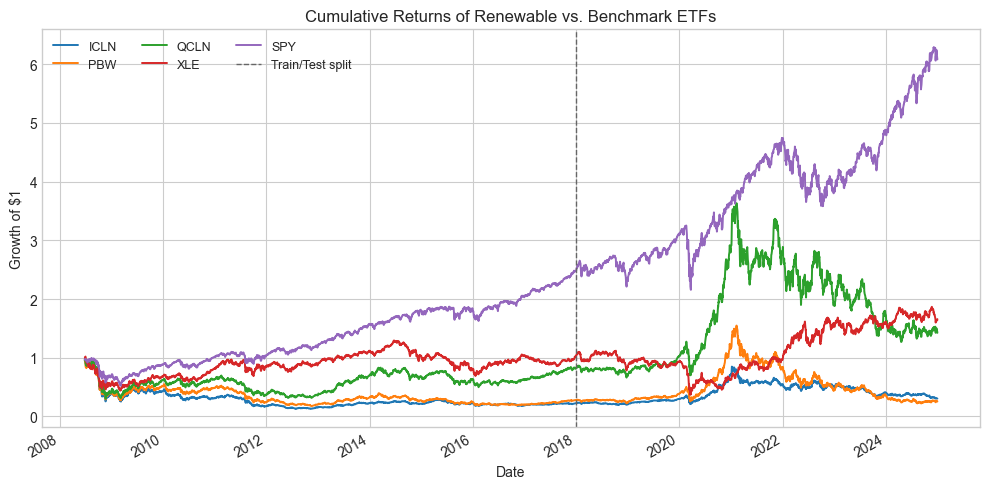

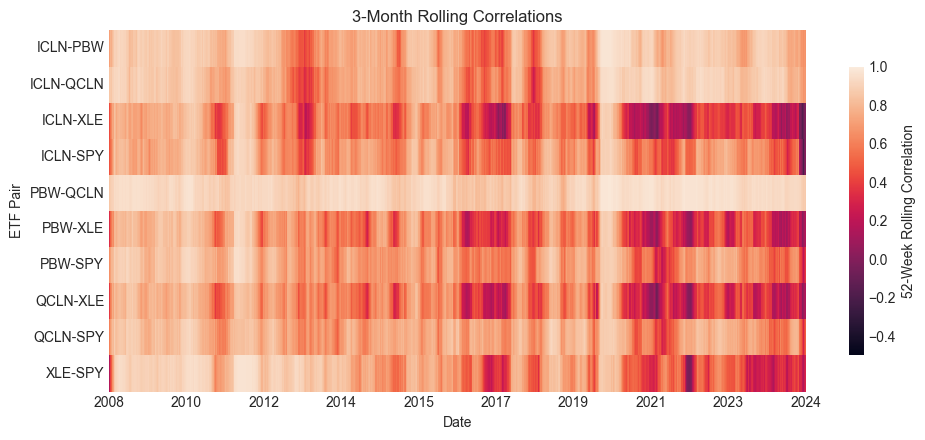

In [ ]:
# -----------------------------  SET-UP  ------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
plt.style.use("seaborn-v0_8-whitegrid")      # journal-friendly look

# YOUR dataframes -----------------------------------------------------------
# renewable_df      : daily decimal returns for ['ICLN','PBW','QCLN']
# nonrenewable_df   : daily decimal returns for ['SPY','XLE']
# If indexes are not datetime, convert:
renewable_df.index     = pd.to_datetime(renewable_df.index)
nonrenewable_df.index  = pd.to_datetime(nonrenewable_df.index)

# align & merge
returns_df = (
    pd.concat([renewable_df, nonrenewable_df], axis=1)
      .sort_index()
      .dropna()
)

# -------------------  1)  DESCRIPTIVE-STATS TABLE  -------------------------
def yearly_var(series, alpha=0.05):
    """Average 1-tail VaR by computing it for each calendar year, then mean."""
    vals = []
    for yr, grp in series.groupby(series.index.year):
        if len(grp) < 50:        # skip partial years
            continue
        vals.append(grp.quantile(alpha))
    return np.mean(vals)

def yearly_cvar(series, alpha=0.05):
    vals = []
    for yr, grp in series.groupby(series.index.year):
        if len(grp) < 50:
            continue
        var = grp.quantile(alpha)
        vals.append(grp[grp <= var].mean())
    return np.mean(vals)

def max_drawdown(series):
    path = (1 + series).cumprod()
    return (path / path.cummax() - 1).min()



stats = []
for col in returns_df.columns:
    r = returns_df[col]
    stats.append({
        "Annualized Mean Return": (1+r.mean())**252-1, # annualized mean
        "Std σ":     r.std(ddof=0)*np.sqrt(252),
        "Skew":      skew(r),
        "Kurtosis":  kurtosis(r, fisher=False),
        "VaR 95%":   yearly_var(r, 0.05),     # average yearly VaR
        "CVaR 95%":  yearly_cvar(r, 0.05),    # average yearly CVaR
        "Max-DD":    max_drawdown(r)
    })

table1 = pd.DataFrame(stats, index=returns_df.columns)
display(table1)

# (optionally) save to CSV for LaTeX / Markdown
table1.to_csv("tables/descriptive_stats.csv")

# -------------------  2)  FIGURE 1 – CUMULATIVE RETURNS  -------------------
start_plot = returns_df.index.min()
end_plot   = returns_df.index.max()
train_end  = pd.Timestamp("2017-12-31")

cum = (1 + returns_df).cumprod()
fig, ax = plt.subplots(figsize=(10,5))
cum.plot(ax=ax, linewidth=1.4)
ax.axvline(train_end, color="0.4", ls="--", lw=1, label="Train/Test split")
ax.set(title="Cumulative Returns of Renewable vs. Benchmark ETFs",
       xlabel="Date", ylabel="Growth of $1")
ax.legend(frameon=False, ncol=3, fontsize=9)
fig.tight_layout()
fig.savefig("fig/cumulative_returns.png", dpi=300)

# -------------------  3)  FIGURE 2 – 52-WEEK ROLLING CORR  -----------------
roll_corr = (
    returns_df
      .rolling(window=63, min_periods=50)
      .corr()
      .dropna()
      .unstack()
)

# reshape to long → pivot so seaborn heatmap needs Date × Pair matrix
pairs = []
for i, j in zip(*np.triu_indices(len(returns_df.columns), k=1)):
    pairs.append((returns_df.columns[i], returns_df.columns[j]))

frames = []
for a, b in pairs:
    tmp = roll_corr[a][b].rename(f"{a}-{b}")
    frames.append(tmp)

corr_mat = pd.concat(frames, axis=1)
import matplotlib.dates as mdates

fig2, ax2 = plt.subplots(figsize=(10,4.5))

sns.heatmap(corr_mat.T,
            cmap="rocket",          #  smoother color transition
            vmin=-0.5, vmax=1,      # tighter color range (cut off extreme low/high)
            cbar_kws={"shrink": .8, "label": "52-Week Rolling Correlation"},
            ax=ax2)


# Now manually fix the x-ticks
n_dates = corr_mat.index  # REAL dates
ax2.set_xticks(np.linspace(0, len(n_dates)-1, 10))  # 10 evenly spaced ticks
ax2.set_xticklabels([pd.to_datetime(d).year for d in np.linspace(n_dates.min().value, n_dates.max().value, 10, dtype='datetime64[ns]')], rotation=0)

ax2.set(title="3-Month Rolling Correlations",
        xlabel="Date", ylabel="ETF Pair")

fig2.tight_layout()
fig2.savefig("fig/rolling_corr_heatmap_fixed.png", dpi=300)

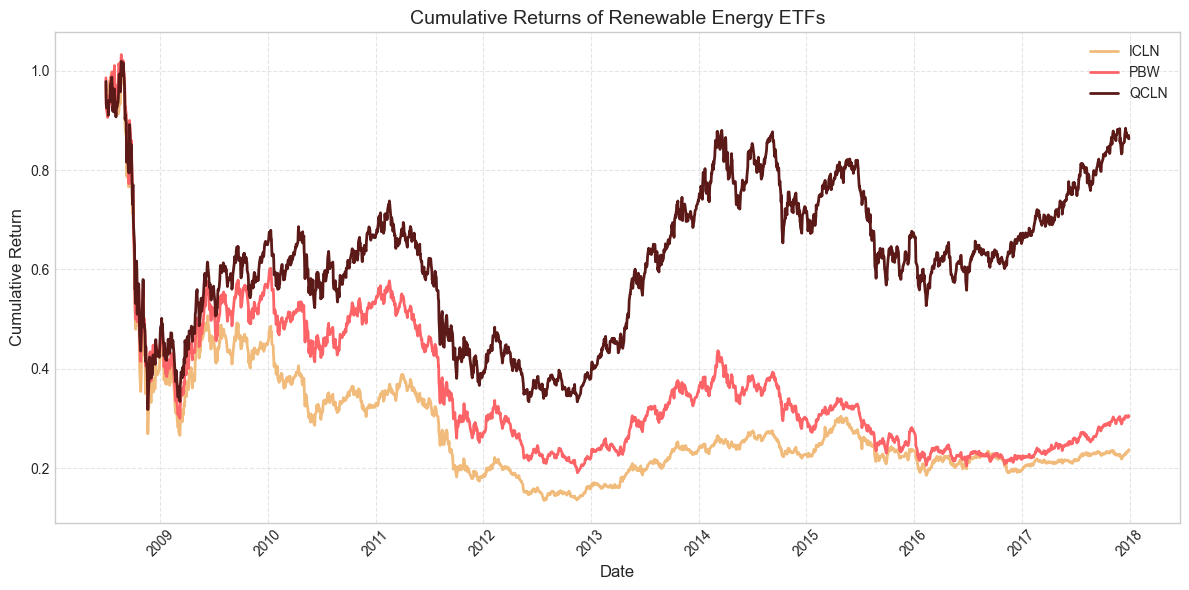

In [7]:
import matplotlib.dates as mdates

start_date = "2008-07-01"   # or pd.Timestamp("2015-01-01")
end_date   = "2017-12-31"


# Compute cumulative returns
cum_returns_r = (1 + renewable_df[start_date:end_date]).cumprod()
cum_returns_nr = (1 + nonrenewable_df[start_date:end_date]).cumprod()


dates_nr = pd.to_datetime(cum_returns_nr.index)
dates_r = pd.to_datetime(cum_returns_r.index)

# Plot


fig, ax = plt.subplots(figsize=(12,6))

# Set custom colors
colors = {
    "ICLN": "#F1BB7B",  # peachy-orange
    "PBW": "#FD6467",   # strong pinkish-red
    "QCLN": "#5B1A18",  # deep dark brown-red
}

for col in cum_returns_r.columns:
    plt.plot(cum_returns_r.index, cum_returns_r[col], label=col, color=colors.get(col, None), linewidth=2)

# Styling
plt.title("Cumulative Returns of Renewable Energy ETFs", fontsize=14)
plt.ylabel("Cumulative Return", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, which='major', linestyle='--', alpha=0.5)

# Set x-ticks to show only every 100th date
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

fig.tight_layout()
fig.savefig("fig/cum_returns_train.png", dpi=300)

In [ ]:
ret

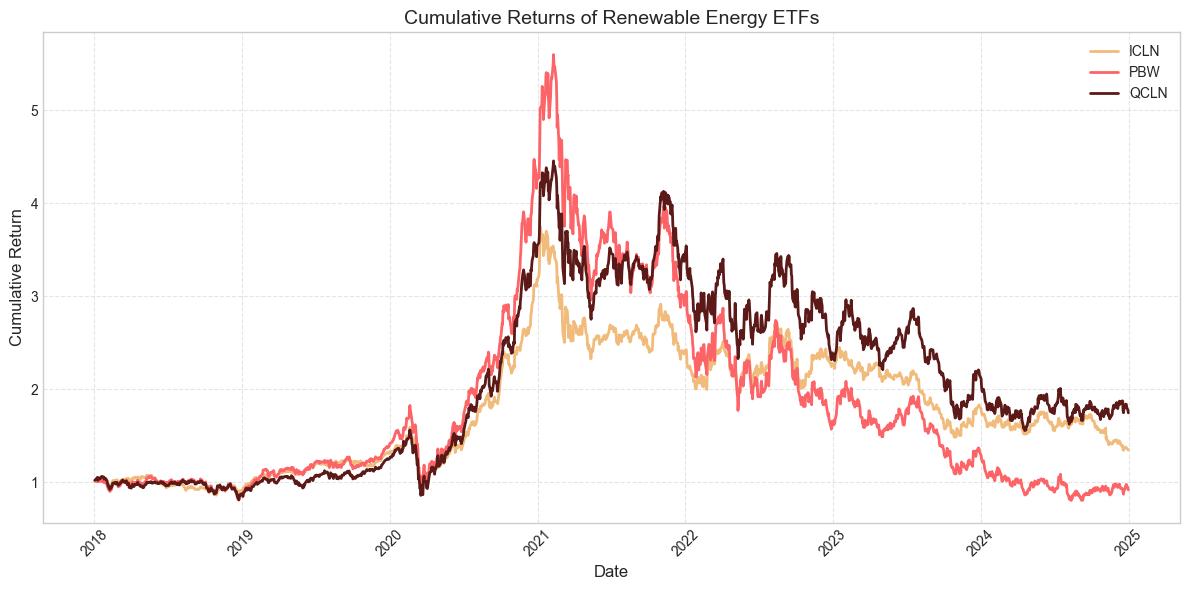

In [8]:
import matplotlib.dates as mdates

start_date = "2018-01-01"   # or pd.Timestamp("2015-01-01")
end_date   = "2024-12-31"


# Compute cumulative returns
cum_returns_r = (1 + renewable_df[start_date:end_date]).cumprod()
cum_returns_nr = (1 + nonrenewable_df[start_date:end_date]).cumprod()


dates_nr = pd.to_datetime(cum_returns_nr.index)
dates_r = pd.to_datetime(cum_returns_r.index)

# Plot


fig, ax = plt.subplots(figsize=(12,6))

# Set custom colors
colors = {
    "ICLN": "#F1BB7B",  # peachy-orange
    "PBW": "#FD6467",   # strong pinkish-red
    "QCLN": "#5B1A18",  # deep dark brown-red
}

for col in cum_returns_r.columns:
    plt.plot(cum_returns_r.index, cum_returns_r[col], label=col, color=colors.get(col, None), linewidth=2)

# Styling
plt.title("Cumulative Returns of Renewable Energy ETFs", fontsize=14)
plt.ylabel("Cumulative Return", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, which='major', linestyle='--', alpha=0.5)

# Set x-ticks to show only every 100th date
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

fig.tight_layout()
fig.savefig("fig/cum_returns_test.png", dpi=300)

/Users/simenguttormsen/miniforge3/envs/test_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simenguttormsen/miniforge3/envs/test_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simenguttormsen/miniforge3/envs/test_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simenguttormsen/miniforge3/envs/test_env/lib/python3.10/site-packages/seaborn/_oldcore.py:111

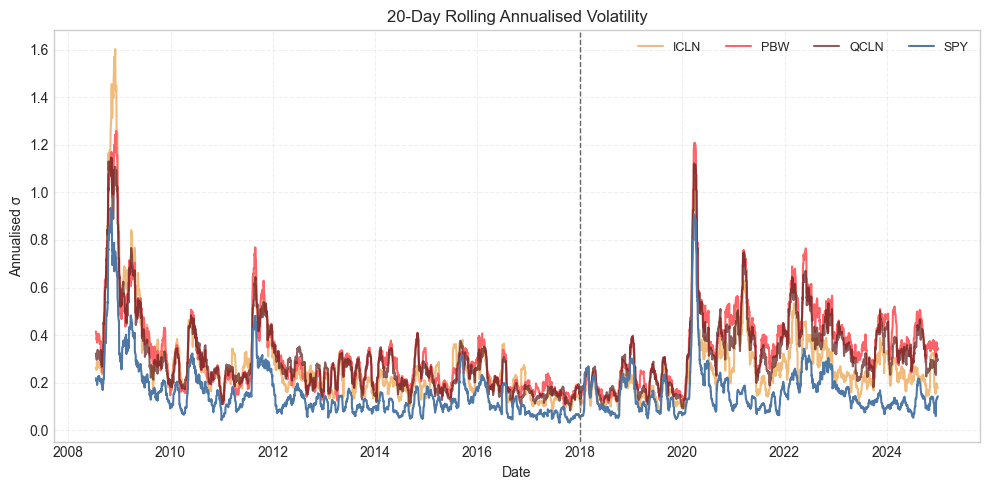

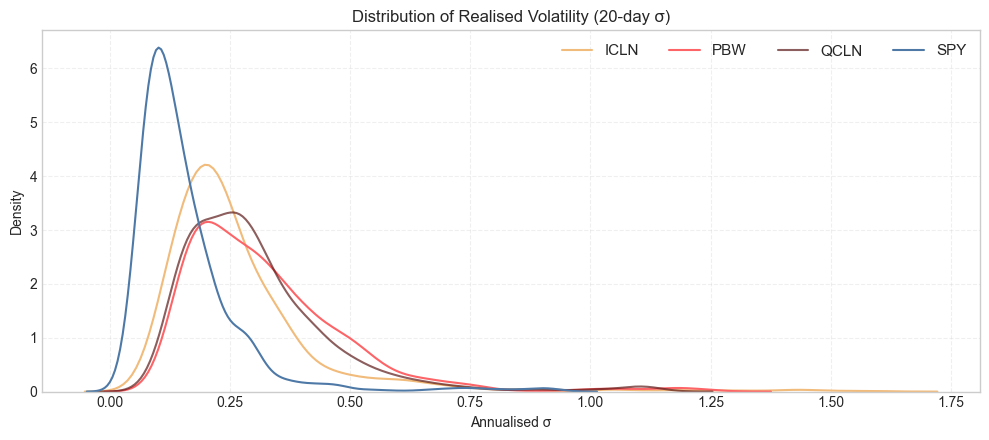

In [9]:
# ------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------
ROLL_WIN   = 20
ANNUALISE  = np.sqrt(252)
SAVE_DPI   = 300
VOL_DIR    = "fig"

colors = {
    "ICLN": "#F1BB7B",  # peachy-orange
    "PBW": "#FD6467",   # strong pinkish-red
    "QCLN": "#5B1A18",  # deep dark brown-red
    "SPY": "#4E79A7",   # muted blue (good for benchmark!)
}

# ------------------------------------------------------------------
# A) 20-day Rolling Annualised Volatility
# ------------------------------------------------------------------
rolling_vol = (
    renewable_df.join(spy)
    .rolling(ROLL_WIN, min_periods=15)
    .std(ddof=0) * ANNUALISE
)

fig1, ax1 = plt.subplots(figsize=(10,5))

# Now plot all 4 assets
for etf in ["ICLN", "PBW", "QCLN", "SPY"]:
    opacity = 1.0 if etf != "QCLN" else 0.7  # QCLN slightly transparent
    ax1.plot(rolling_vol.index, rolling_vol[etf], label=etf,
             color=colors.get(etf), lw=1.5, alpha=opacity)

ax1.set(title=f"{ROLL_WIN}-Day Rolling Annualised Volatility",
        ylabel="Annualised σ",
        xlabel="Date")
ax1.axvline(pd.Timestamp("2017-12-31"), ls="--", lw=1, color="0.4")
ax1.legend(frameon=False, ncol=4, fontsize=9)
ax1.grid(alpha=0.3, linestyle="--")
fig1.tight_layout()
fig1.savefig(f"{VOL_DIR}/rolling_volatility.png", dpi=SAVE_DPI)

# ------------------------------------------------------------------
# B) Distribution of Daily σ (Kernel Density)
# ------------------------------------------------------------------
daily_sigma = (
    renewable_df.join(spy)
    .rolling(ROLL_WIN, min_periods=15)
    .std(ddof=0) * ANNUALISE
).stack().reset_index()
daily_sigma.columns = ["Date", "ETF", "Sigma"]

fig2, ax2 = plt.subplots(figsize=(10,4.5))

# KDE plot for all 4 assets
for etf in ["ICLN", "PBW", "QCLN", "SPY"]:
    subset = daily_sigma[daily_sigma["ETF"] == etf]
    opacity = 1.0 if etf != "QCLN" else 0.7
    sns.kdeplot(data=subset, x="Sigma", ax=ax2, label=etf,
                color=colors.get(etf), lw=1.5, bw_adjust=1.2, alpha=opacity)

ax2.set(title="Distribution of Realised Volatility (20-day σ)",
        xlabel="Annualised σ", ylabel="Density")
ax2.grid(alpha=.3, ls="--")
ax2.legend(frameon=False, fontsize=11, ncol=4)
fig2.tight_layout()
fig2.savefig(f"{VOL_DIR}/vol_density.png", dpi=SAVE_DPI)

plt.show()


# Compute VaR, CVaR and Max Drawdown for ETFs

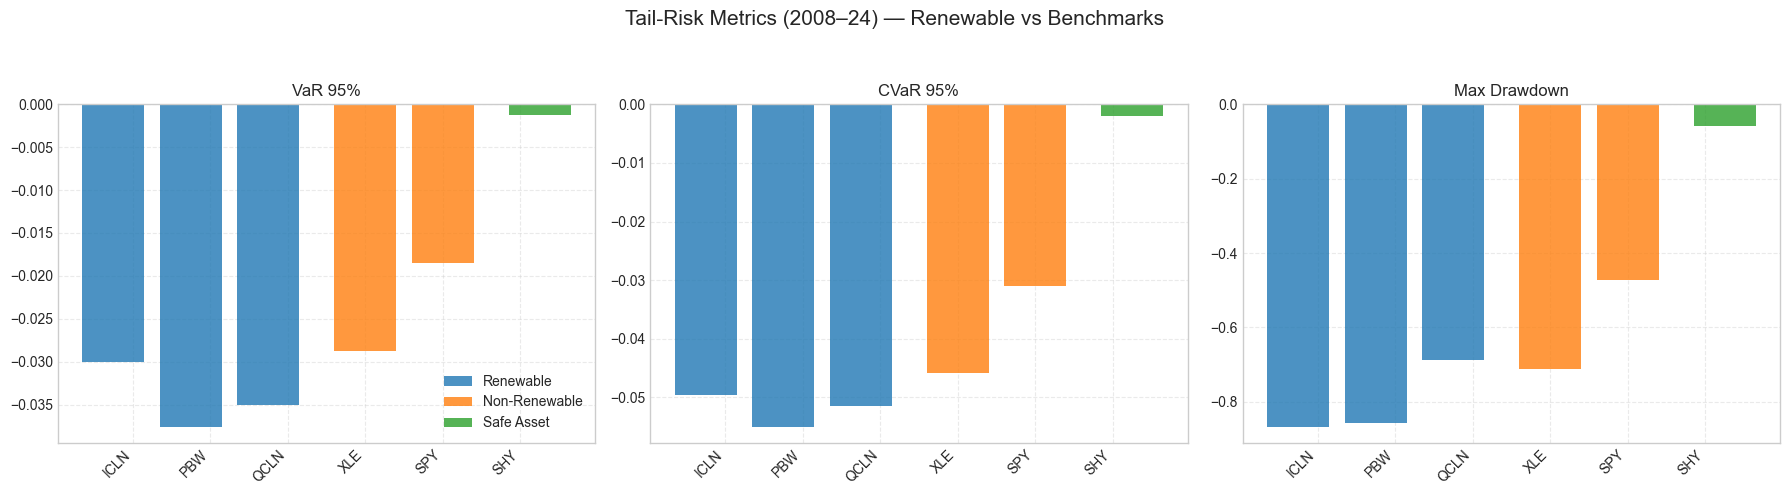

In [10]:
# -------------- PARAMETERS --------------------------------
START_DATE = "2008-01-02"
END_DATE = "2024-12-31"
ALPHA = 0.05

# -------------- FUNCTIONS ---------------------------------
def compute_risk_metrics(df, start=None, end=None, alpha=0.05):
    if start or end:
        df = df.loc[start:end]
    out = {}
    for col in df.columns:
        r = df[col].dropna()
        var  = r.quantile(alpha)
        cvar = r[r <= var].mean()
        path = (1 + r).cumprod()
        mdd  = (path / path.cummax() - 1).min()
        out[col] = {
            f"VaR {int((1-alpha)*100)}%":  var,
            f"CVaR {int((1-alpha)*100)}%": cvar,
            "Max Drawdown":                mdd,
        }
    return pd.DataFrame(out).T.round(4)

# -------------- DATA --------------------------------------
# Assume you already have renewable_df, nonrenewable_df, bond_df loaded
# renewable_df, nonrenewable_df, bond_df

renewable_risk = compute_risk_metrics(renewable_df, START_DATE, END_DATE, ALPHA)
nonrenewable_risk = compute_risk_metrics(nonrenewable_df, START_DATE, END_DATE, ALPHA)
bond_risk = compute_risk_metrics(bond_df, START_DATE, END_DATE, ALPHA)

combined_risk = pd.concat(
    [renewable_risk, nonrenewable_risk, bond_risk],
    keys=["Renewable", "Non-Renewable", "Safe Asset"]
)
combined_risk.index.names = ["Group", "ETF"]

# Melt for plotting
melted = (combined_risk.reset_index()
                      .melt(id_vars=["Group", "ETF"],
                            var_name="Metric", value_name="Value"))

etf_order = ['ICLN', 'PBW', 'QCLN', 'XLE', 'SPY'] + list(bond_df.columns)
group_order = ["Renewable", "Non-Renewable", "Safe Asset"]
palette = {"Renewable": "#1f77b4", "Non-Renewable": "#ff7f0e", "Safe Asset": "#2ca02c"}

# -------------------- PLOT -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=False)


bar_width = 0.8
group_offsets = {
    "Renewable": -0.5/2,
    "Non-Renewable": 0,
    "Safe Asset": 0.5/2
}

for i, metric in enumerate(melted["Metric"].unique()):
    ax = axes[i]
    data = melted[melted["Metric"] == metric].copy()
    data = data[data["ETF"].isin(etf_order)]
    data["ETF"] = pd.Categorical(data["ETF"], categories=etf_order, ordered=True)
    data = data.sort_values(["ETF", "Group"])

    x = np.arange(len(etf_order))  # Base x positions (for each ETF)

    for grp in group_order:
        grp_data = data[data["Group"] == grp].copy()
        grp_data["ETF"] = pd.Categorical(grp_data["ETF"], categories=etf_order, ordered=True)
        grp_data = grp_data.sort_values("ETF")

        # Match the ETFs correctly
        x_pos = [etf_order.index(etf) for etf in grp_data["ETF"]]

        offset = group_offsets[grp]
        ax.bar(np.array(x_pos) + offset, grp_data["Value"],
              width=bar_width, label=grp,
              color=palette.get(grp), alpha=0.8)

    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(etf_order, rotation=45, ha="right")
    ax.grid(True, linestyle="--", alpha=0.4)
    if i == 0:
        ax.legend(frameon=False)

fig.suptitle("Tail-Risk Metrics (2008–24) — Renewable vs Benchmarks", fontsize=15)
fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("fig/tail_risk_metrics.png", dpi=300)
plt.show()

# USE: GARCH Volatility signals

### make training and test set to later test performance of volatility signals


In [214]:
from arch import arch_model
import pandas as pd
import numpy as np

def compute_weekly_forecast_and_realized_vol(
    returns_df: pd.DataFrame,
    ticker: str,
    start: str,
    end: str,
    rolling_window: int = 500,
    forecast_horizon: int = 5,        # 5 trading days ≈ 1 week
) -> tuple[pd.Series, pd.Series]:
    """
    Weekly GARCH(1,1) σ forecast vs. realised σ (5-day window).

    • Fits a new model every Friday (or last trading day of the week)
      using the previous `rolling_window` daily returns.
    • Forecasts the variance of the next 5 trading days, converts to
      weekly σ in *decimal* units.
    • Computes the realised 5-day σ for comparison.

    Returns
    -------
    forecast_vol : pd.Series  (index = forecast dates, name = 'Forecast 1W σ')
    realized_vol : pd.Series  (same index, name = 'Realised 1W σ')
    """
     # 1) prep ----------------------------------------------------------------
    df = returns_df.copy()
    df.index = pd.to_datetime(df.index)
    series = df[ticker].loc[start:end].dropna()
    pct_returns = series * 100     # arch package expects percent scale

    f_dates, f_vols = [], []

    # 2) define last trading days of each week -------------------------------
    # resample to weekly frequency, using the last available trading day
    last_trading_days = series.resample('W-FRI').last().dropna().index

    # 3) rolling forecasts ---------------------------------------------------
    for date_i in last_trading_days:
        # find position
        pos = pct_returns.index.get_indexer([date_i], method="nearest")[0]

        if pos < rolling_window or pos + forecast_horizon >= len(pct_returns):
            continue  # skip if not enough history or horizon overshoots

        window = pct_returns.iloc[pos - rolling_window : pos]
        model = arch_model(window, vol='Garch', p=1, q=1).fit(disp='off')

        fc_var_pct2 = model.forecast(horizon=forecast_horizon, reindex=False).variance.values[-1]
        weekly_var_dec = fc_var_pct2.sum() / 10000    # percent² → decimal²

        f_vols.append(np.sqrt(weekly_var_dec))
        f_dates.append(pct_returns.index[pos])

    forecast_vol = pd.Series(f_vols, index=f_dates, name='Forecast 1W vol')

    # 4) realised 5-day σ ----------------------------------------------------
    r_vols = []
    for dt in f_dates:
        pos = series.index.get_indexer([dt], method="nearest")[0]
        window = series.iloc[pos + 1 : pos + 1 + forecast_horizon]
        realised_var = (window ** 2).sum()
        r_vols.append(np.sqrt(realised_var))

    realized_vol = pd.Series(r_vols, index=f_dates, name='Realised 1W vol')
    return forecast_vol, realized_vol

In [215]:
def plot_forecast_vs_realized_vol(
    forecast_vol: pd.Series,
    realized_vol: pd.Series,
    ticker: str,
    start_date: str,
    end_date: str,
    *,
    horizon_label: str = "1W",
    figsize: tuple = (12, 6),
    linewidth: float = 2.0,
    alpha: float = 0.8,
):
    """
    Plot forecasted vs. realised volatility for a chosen horizon.

    Parameters
    ----------
    forecast_vol, realized_vol : pd.Series
        Forecasted and realised volatilities (decimal σ), indexed by date.
    ticker        : str        – ETF symbol used in the title.
    start_date,end_date : str/Timestamp – inclusive date window.
    horizon_label : str        – text that appears in legend/title ("1W","1M",…).
    figsize       : tuple      – figure size in inches.
    linewidth     : float      – line width.
    alpha         : float      – transparency for realised line.
    """
    # date window
    start_date = pd.to_datetime(start_date)
    end_date   = pd.to_datetime(end_date)

    fcast = forecast_vol.loc[start_date:end_date]
    real  = realized_vol.loc[start_date:end_date]

    plt.figure(figsize=figsize)
    plt.plot(fcast.index, fcast, label=f"Forecasted {horizon_label} Vol", linewidth=linewidth)
    plt.plot(real.index,  real,  label=f"Realised {horizon_label} Vol",  linewidth=linewidth, alpha=alpha)

    plt.title(
        f"{ticker}: Forecasted vs Realised {horizon_label} Volatility\n"
        f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"
    )
    plt.xlabel("Date")
    plt.ylabel("Volatility (σ)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.savefig("fig/vol_prediction_ICLN.png", dpi=300)
    plt.show()

In [216]:
forecast_ICLN, realized_ICLN = compute_weekly_forecast_and_realized_vol(renewable_df, 'ICLN', '2008-01-01', '2024-12-31')
forecast_PBW, realized_PBW = compute_weekly_forecast_and_realized_vol(renewable_df, 'PBW', '2008-01-01', '2024-12-31')
forecast_QCLN, realized_QCLN = compute_weekly_forecast_and_realized_vol(renewable_df, 'QCLN', '2008-01-01', '2024-12-31')

# combine forecat_ICLN, forecast_PBW, and forecast_QCLN

# combine on dates
garch_forecast = pd.concat([forecast_ICLN, forecast_PBW, forecast_QCLN], axis=1)
realized_vols = pd.concat([realized_ICLN, realized_PBW, realized_QCLN], axis=1)

# rename to ICLN, PBW, and QCLN
garch_forecast.columns = ['ICLN', 'PBW', 'QCLN']
realized_vols.columns = ['ICLN', 'PBW', 'QCLN']

In [217]:
garch_train = garch_forecast["2010-06-25":"2017-12-31"]
garch_test = garch_forecast["2018-01-01":"2024-12-31"]

realized_vols_train = realized_vols["2010-06-25":"2017-12-31"]
realized_vols_test = realized_vols["2018-01-01":"2024-12-31"]

In [218]:
def vol_metrics(garch_forecast, realized_vols):
    metrics_list = []

    for etf in garch_forecast.columns:
        forecast_vol = garch_forecast[etf]
        realized_vol = realized_vols[etf]

        errors = forecast_vol - realized_vol
        realized_mean = realized_vol.mean()

        mse = (errors ** 2).mean()
        rmse = np.sqrt(mse)
        mae = errors.abs().mean()
        qlike = (np.log(forecast_vol**2) + (realized_vol**2) / (forecast_vol**2)).mean()
        r2 = 1 - (errors**2).sum() / ((realized_vol - realized_mean)**2).sum()

        metrics_list.append({
            "ETF": etf,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "QLIKE": qlike,
            "R²": r2,
        })

    # Create a full table
    metrics_table = pd.DataFrame(metrics_list)
    metrics_table = metrics_table.set_index("ETF").round(6)

    return metrics_table

# write to csv file
garch_train_metrics = vol_metrics(garch_train, realized_vols_train)
garch_train_metrics.to_csv("tables/garch_train_metrics.csv")
garch_test_metrics = vol_metrics(garch_test, realized_vols_test)
garch_test_metrics.to_csv("tables/garch_test_metrics.csv")

print("train")
print(garch_train_metrics)
print("TEst")
print(garch_test_metrics)

train
           MSE      RMSE       MAE     QLIKE        R²
ETF                                                   
ICLN  0.000190  0.013779  0.010770 -5.868717  0.235878
PBW   0.000218  0.014755  0.011351 -5.658709  0.232266
QCLN  0.000177  0.013317  0.010446 -5.751325  0.281941
TEst
           MSE      RMSE       MAE     QLIKE        R²
ETF                                                   
ICLN  0.000341  0.018472  0.012828 -5.619468  0.302762
PBW   0.000458  0.021405  0.015401 -4.915345  0.383535
QCLN  0.000399  0.019986  0.014381 -5.097731  0.369747


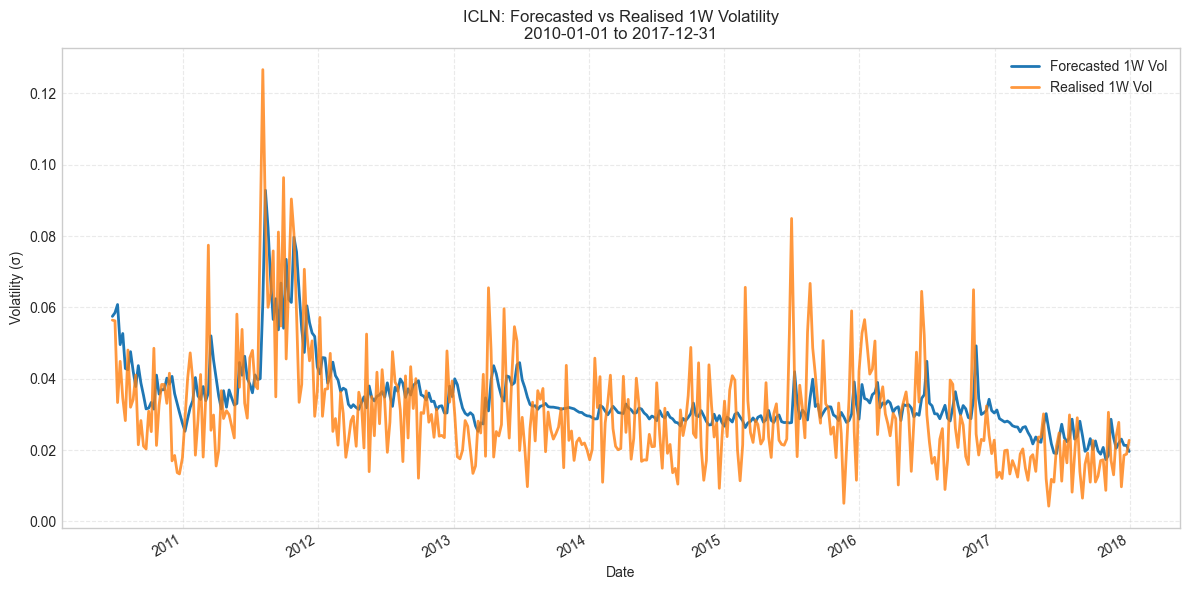

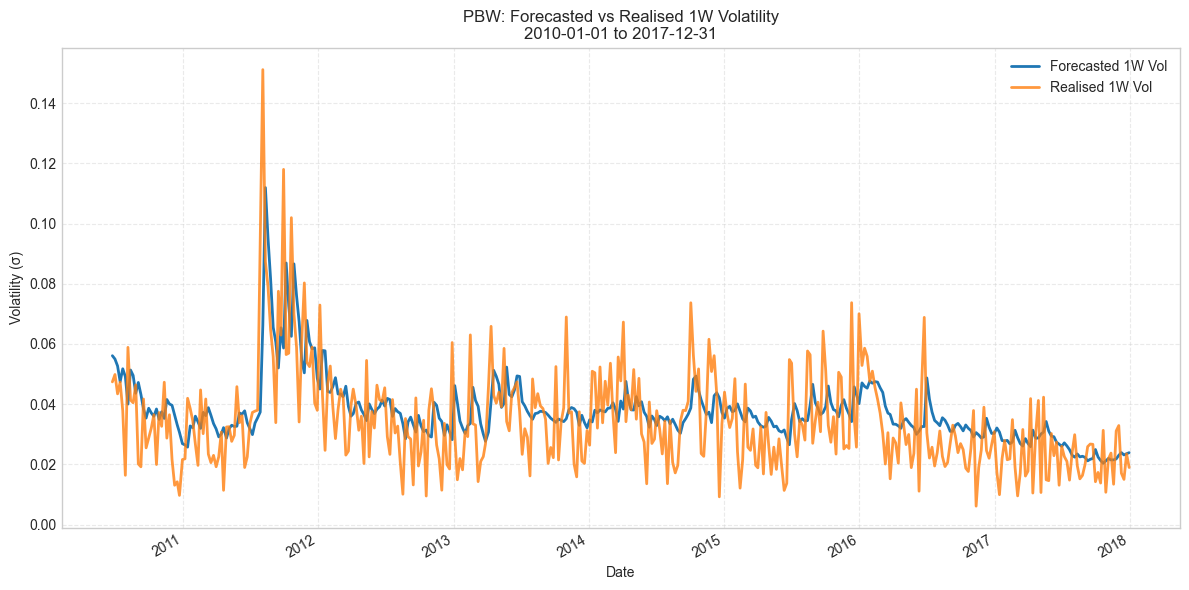

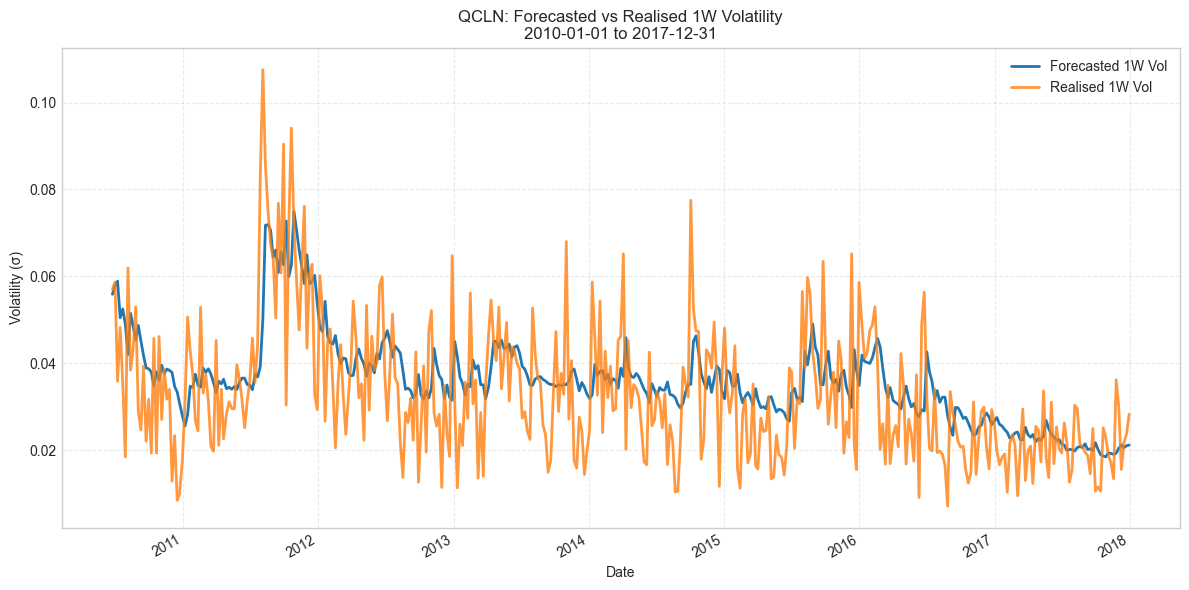

In [219]:
plot_forecast_vs_realized_vol(forecast_ICLN, realized_ICLN, 'ICLN', '2010-01-01', '2017-12-31')
plot_forecast_vs_realized_vol(forecast_PBW, realized_PBW, 'PBW','2010-01-01', '2017-12-31')
plot_forecast_vs_realized_vol(forecast_QCLN, realized_QCLN, 'QCLN', '2010-01-01', '2017-12-31')

# USE: GARCH Hedging


Sensitivity analysis to parameters (what are "ideal" parameters)
VaR vs return (relative to no hedge)


In [221]:
import pandas as pd
import numpy as np

def compute_hedged_returns(
    equity_ret : pd.Series,
    vol_forecast: pd.Series,
    safe_ret   : pd.Series,
    vol_thr    : float,
    de_risk    : float,
    *,
    half_spread: float = 1e-4,     # 1-bp bid–ask half-spread
) -> pd.Series:
    """
    Rule: when σ̂_t exceeds its `vol_thr` percentile, move `de_risk`
    of the portfolio into the safe asset until the next forecast arrives.

    A round-trip costs 2·half_spread; with daily re-hedging cost per day is
        cost_t = half_spread · |w_t − w_{t-1}|.

    Returns a DAILY series of after-cost hedged returns.
    -----------------------------------------------------------------------
    equity_ret   : daily % returns (decimal) of ETF
    vol_forecast : σ̂ at any regular freq (daily / weekly …)
    safe_ret     : daily % returns (decimal) of SHY
    vol_thr      : percentile threshold on σ̂
    de_risk      : weight shifted into bonds when σ̂ > threshold
    half_spread  : bid–ask half-spread (decimal). 1 bp = 0.0001.
    """
    # ── Align daily calendars ────────────────────────────────────────────
    idx = equity_ret.index.intersection(safe_ret.index)
    eq  = equity_ret.loc[idx]
    sf  = safe_ret .loc[idx]

    # ── Build daily equity weight series w_t ─────────────────────────────
    cutoff = vol_forecast.quantile(vol_thr)

    w_on_fcst = pd.Series(1.0, index=vol_forecast.index)
    w_on_fcst.loc[vol_forecast > cutoff] = 1.0 - de_risk

    w = (
        w_on_fcst.reindex(idx)        # put onto daily grid
                .ffill()              # carry forward until new forecast
                .fillna(1.0)          # before first forecast: 100 % equity
    )

    # ── Transaction-cost drag  c·|Δw|  ───────────────────────────────────
    cost = half_spread * w.diff().abs().fillna(0.0)

    # ── Hedged after-cost return  ────────────────────────────────────────
    hedged = w * eq + (1.0 - w) * sf - cost
    hedged.name = "hedged_return"

    return hedged


In [222]:
hedged_daily_returns = compute_hedged_returns(
    equity_ret = renewable_df['PBW'],
    vol_forecast= garch_forecast["PBW"],
    safe_ret    = bond_returns['SHY'],
    vol_thr     = 0.9,    # 90th percentile
    de_risk     = 0.5     # move 50% into bonds
)

### Testing multiple one-year periods

In [227]:
import numpy as np
import pandas as pd

# ──────────────────────────────────────────────────────
def single_period_metrics_change_GARCH_weekly(
    returns: pd.Series,
    forecast: pd.Series,
    bond_returns: pd.Series,
    start_date: str,
    end_date: str,
    vol_thr: float,
    de_risk: float,
    min_obs: int = 40,
) -> dict | None:
    """
    Compute metrics for GARCH hedge strategy over a weekly resampled period,
    expressed as % improvements.

    Improvements:
      • + Return Improvement
      • + VaR Reduction
      • + CVaR Reduction
      • + Max Drawdown Reduction
      • + Sharpe Ratio Improvement
      • + Volatility Reduction
    """
    # ── slice DAILY returns over [start_date, end_date] ──────
    raw  = returns.loc[start_date:end_date]
    bond = bond_returns.reindex(raw.index)

    if len(raw) < min_obs:
        return None

    vol_period = forecast.loc[:end_date]

    # Build hedged DAILY returns first
    hedged = compute_hedged_returns(
        equity_ret   = raw,
        vol_forecast = vol_period,
        safe_ret     = bond,
        vol_thr      = vol_thr,
        de_risk      = de_risk,
    )

    # ── Now RESAMPLE TO WEEKLY ───────────────────────────────
    raw_weekly = raw.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
    hedged_weekly = hedged.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)

    if len(raw_weekly) < min_obs:
        return None

    # ── performance & risk deltas ─────────────────────────────
    R_raw = raw_weekly.mean()
    R_hdg = hedged_weekly.mean()
    return_improve = (R_hdg - R_raw) / abs(R_raw) * 100.0

    var_raw, var_hdg = raw_weekly.quantile(0.05), hedged_weekly.quantile(0.05)
    cvar_raw = raw_weekly[raw_weekly <= var_raw].mean()
    cvar_hdg = hedged_weekly[hedged_weekly <= var_hdg].mean()

    def _mdd(x):
        path = (1 + x).cumprod()
        return (path / path.cummax() - 1).min()

    mdd_raw = _mdd(raw_weekly)
    mdd_hdg = _mdd(hedged_weekly)

    sharpe_raw = raw_weekly.mean() / raw_weekly.std(ddof=0) * np.sqrt(52)
    sharpe_hdg = hedged_weekly.mean() / hedged_weekly.std(ddof=0) * np.sqrt(52)
    sharpe_improve = (
        (sharpe_hdg - sharpe_raw) / abs(sharpe_raw) * 100.0
        if sharpe_raw != 0 else np.nan
    )

    vol_improve = (raw_weekly.std(ddof=0) - hedged_weekly.std(ddof=0)) / raw_weekly.std(ddof=0) * 100.0

    return {
        "Avg Weekly Return Improvement":        return_improve,
        "VaR Reduction":              (abs(var_raw)  - abs(var_hdg))  / abs(var_raw)  * 100.0,
        "CVaR Reduction":             (abs(cvar_raw) - abs(cvar_hdg)) / abs(cvar_raw) * 100.0,
        "Max Drawdown Reduction":     (abs(mdd_raw)  - abs(mdd_hdg))  / abs(mdd_raw)  * 100.0,
        "Sharpe Ratio Improvement":   sharpe_improve,
        "Volatility Reduction":       vol_improve,
    }




# ──────────────────────────────────────────────────────
def yearly_GARCH_sensitivity_avg_change_weekly(
    rets: pd.Series,
    fc: pd.Series,
    bond_rets: pd.Series,
    years: list,
    threshold_list: list,
    de_risk_list: list
) -> pd.DataFrame:
    """
    Compute average weekly-based Return Improvement, VaR Reduction, etc.,
    across multiple (vol_thr, de_risk) grid points.
    """
    records = []

    for thr in threshold_list:
        for dr in de_risk_list:
            yearly = []
            for y in years:
                start_date = f"{y}-01-01"
                end_date   = f"{y}-12-31"

                m = single_period_metrics_change_GARCH_weekly(
                    returns      = rets,
                    forecast     = fc,
                    bond_returns = bond_rets,
                    start_date   = start_date,
                    end_date     = end_date,
                    vol_thr      = thr,
                    de_risk      = dr
                )
                if m is not None:
                    yearly.append(m)

            if not yearly:
                continue

            dfy = pd.DataFrame(yearly)
            records.append({
                'Thresh':       int(thr * 100),
                'De-risk':      int(dr * 100),
                'Avg Weekly Return Improvement':     dfy['Avg Weekly Return Improvement'].mean(),
                'Avg VaR Red':  dfy['VaR Reduction'].mean(),
                'Avg CVaR Red': dfy['CVaR Reduction'].mean(),
                'Avg MDD Red':  dfy['Max Drawdown Reduction'].mean(),
                'Avg Sharpe Ratio Improvement':  dfy['Sharpe Ratio Improvement'].mean(),
                'Avg Volatility Reduction':  dfy['Volatility Reduction'].mean(),
                'Years Used':   len(dfy)
            })

    return pd.DataFrame(records)


In [224]:
years = list(range(2010, 2018))
threshold_list = [0.5, 0.6, 0.7, 0.8, 0.9]
de_risk_list   = [0.25, 0.5, 0.75, 1]

# rets and fc should already be defined:

sens_yearly_ICLN = yearly_GARCH_sensitivity_avg_change_weekly(renewable_df['ICLN'], garch_forecast["ICLN"], bond_returns["SHY"],years, threshold_list, de_risk_list)
sens_yearly_PBW = yearly_GARCH_sensitivity_avg_change_weekly(renewable_df['PBW'], garch_forecast["PBW"], bond_returns["SHY"], years, threshold_list, de_risk_list)
sens_yearly_QCLN = yearly_GARCH_sensitivity_avg_change_weekly(renewable_df['QCLN'], garch_forecast["QCLN"], bond_returns["SHY"], years, threshold_list, de_risk_list)

print("==============ICLN==============")
print(sens_yearly_ICLN)
print("==============PBW==============")
print(sens_yearly_PBW)
print("==============QCLN==============")
print(sens_yearly_QCLN)

==============ICLN==============
    Thresh  De-risk  Avg Weekly Return Improvement  Avg VaR Red  Avg CVaR Red  \
0       50       25                       0.306082     6.176732      4.961164   
1       50       50                       0.455156    10.658247      8.787361   
2       50       75                       0.449423    12.730417     10.651807   
3       50      100                       0.291095    11.156723     10.817221   
4       60       25                      -1.979185     6.176732      4.268507   
5       60       50                      -4.028614     9.882335      7.402048   
6       60       75                      -6.147330    10.740637      7.879179   
7       60      100                      -8.334360     8.729404      7.351936   
8       70       25                      -0.512355     4.622329      2.851600   
9       70       50                      -1.060130     6.426078      5.013066   
10      70       75                      -1.642825     6.789433      5.26096

In [228]:
sens_yearly_ICLN

Thresh  De-risk  Avg Weekly Return Improvement  Avg VaR Red  Avg CVaR Red  \
0       50       25                       0.306082     6.176732      4.961164   
1       50       50                       0.455156    10.658247      8.787361   
2       50       75                       0.449423    12.730417     10.651807   
3       50      100                       0.291095    11.156723     10.817221   
4       60       25                      -1.979185     6.176732      4.268507   
5       60       50                      -4.028614     9.882335      7.402048   
6       60       75                      -6.147330    10.740637      7.879179   
7       60      100                      -8.334360     8.729404      7.351936   
8       70       25                      -0.512355     4.622329      2.851600   
9       70       50                      -1.060130     6.426078      5.013066   
10      70       75                      -1.642825     6.789433      5.260966   
11      70      100                      -2.259929     3.785304      4.482721   
12      80       25                      -1.493251     1.823258      0.305721   
13      80       50                      -3.041981     2.637709      0.570270   
14      80       75                      -4.646114     3.195601      0.437061   
15      80      100                      -6.305555     3.195601      0.303852   
16      90       25                       0.245228     1.025438     -0.149356   
17      90       50                       0.485490     1.025438     -0.298712   
18      90       75                       0.720431     1.025438     -0.448068   
19      90      100                       0.949692     1.025438     -0.597424   

    Avg MDD Red  Avg Sharpe Ratio Improvement  Avg Volatility Reduction  \
0      2.837272                     -4.215439                  5.983875   
1      5.558227                     -8.290350                 10.904483   
2      8.113185                    -11.159116                 14.334112   
3      9.778881                    -11.566146                 15.778460   
4      1.674742                     -5.633179                  4.767146   
5      2.979987                    -10.817781                  8.569256   
6      3.590821                    -14.777839                 11.099521   
7      3.801138                    -16.896695                 12.051373   
8      1.029278                     -3.218469                  2.996687   
9      1.983201                     -5.782390                  5.253916   
10     2.995866                     -7.349358                  6.613985   
11     4.059777                     -7.855135                  6.934314   
12     0.294716                     -2.711742                  1.141987   
13     0.456293                     -5.181604                  1.926540   
14     0.577284                     -7.318124                  2.319297   
15     0.597234                     -9.082047                  2.302565   
16     0.525344                     -0.448514                  0.683121   
17     1.040748                     -0.675264                  1.133923   
18     1.207712                     -0.657967                  1.341885   
19     1.207494                     -0.400155                  1.304350   

    Years Used  
0            8  
1            8  
2            8  
3            8  
4            8  
5            8  
6            8  
7            8  
8            8  
9            8  
10           8  
11           8  
12           8  
13           8  
14           8  
15           8  
16           8  
17           8  
18           8  
19           8

In [229]:
sens_yearly_PBW

Thresh  De-risk  Avg Weekly Return Improvement  Avg VaR Red  Avg CVaR Red  \
0       50       25                     -58.671794    11.086008      8.623099   
1       50       50                    -116.876831    15.698251     14.214351   
2       50       75                    -174.618192    16.166887     15.661675   
3       50      100                    -231.899028    15.568297     16.020765   
4       60       25                     -75.715820     9.108476      6.267088   
5       60       50                    -151.059444    13.107603     10.335994   
6       60       75                    -226.034165    12.741557     11.462592   
7       60      100                    -300.643328    11.450049     12.030598   
8       70       25                     -31.954488     6.735752      4.094192   
9       70       50                     -63.528892    10.976097      6.843814   
10      70       75                     -94.729886    11.632240      6.915759   
11      70      100                    -125.564175    10.972857      6.838707   
12      80       25                      -9.898986     3.946914      2.253424   
13      80       50                     -19.836657     7.120135      3.623624   
14      80       75                     -29.817155     7.517027      3.654838   
15      80      100                     -39.844586     7.517027      3.558721   
16      90       25                     -21.810788     1.598251      0.903134   
17      90       50                     -43.251004     1.926255      0.903134   
18      90       75                     -64.325458     1.926255      0.903134   
19      90      100                     -85.038943     1.926255      0.903134   

    Avg MDD Red  Avg Sharpe Ratio Improvement  Avg Volatility Reduction  \
0      2.635423                    -70.370781                  9.551713   
1      5.271943                   -147.447787                 17.264252   
2      7.528061                   -226.073023                 22.372329   
3      9.341050                   -298.437547                 24.059725   
4      1.076457                    -85.743304                  7.520831   
5      1.792938                   -177.311625                 13.480089   
6      2.003165                   -270.162560                 17.402687   
7      1.478151                   -358.347565                 18.800345   
8      1.217649                    -37.499340                  5.240938   
9      1.802795                    -76.150923                  9.339275   
10     1.872571                   -114.109773                 12.015736   
11     1.652957                   -149.395754                 13.001161   
12     0.790971                    -12.539802                  3.125524   
13     1.361490                    -25.029302                  5.451605   
14     1.532323                    -36.967887                  6.829776   
15     1.511150                    -47.961800                  7.147424   
16     0.668436                    -23.122634                  0.890438   
17     1.069930                    -46.162778                  1.510744   
18     1.034573                    -68.663159                  1.834783   
19     0.751091                    -90.207630                  1.847973   

    Years Used  
0            8  
1            8  
2            8  
3            8  
4            8  
5            8  
6            8  
7            8  
8            8  
9            8  
10           8  
11           8  
12           8  
13           8  
14           8  
15           8  
16           8  
17           8  
18           8  
19           8

In [230]:
sens_yearly_QCLN

Thresh  De-risk  Avg Weekly Return Improvement  Avg VaR Red  Avg CVaR Red  \
0       50       25                    -967.839644     8.191174      9.780356   
1       50       50                   -1929.174523    14.707939     15.581002   
2       50       75                   -2883.776442    17.195562     16.927870   
3       50      100                   -3831.418845    17.733200     17.913814   
4       60       25                    -719.148298     6.118557      6.233053   
5       60       50                   -1432.479302    11.006558      9.927395   
6       60       75                   -2139.774106    11.614281     10.725277   
7       60      100                   -2840.815601    12.436873     11.339052   
8       70       25                      -1.883312     5.547429      4.713003   
9       70       50                       4.602064     9.992538      7.553980   
10      70       75                      19.631533     9.992538      8.465160   
11      70      100                      43.378705     9.992538      9.376339   
12      80       25                   -1188.500841     2.288431      1.835224   
13      80       50                   -2376.154321     4.473946      2.988049   
14      80       75                   -3562.816696     4.473946      3.428693   
15      80      100                   -4748.345354     4.375619      3.840773   
16      90       25                      -2.505407     1.290645      0.651571   
17      90       50                      -4.983231     1.404813      0.651571   
18      90       75                      -7.433888     1.404813      0.651571   
19      90      100                      -9.857793     1.404813      0.651571   

    Avg MDD Red  Avg Sharpe Ratio Improvement  Avg Volatility Reduction  \
0      4.175471                  -1046.052655                  9.136599   
1      6.082841                  -2235.398920                 16.563619   
2      5.529659                  -3514.874078                 21.602747   
3      3.726215                  -4782.027186                 23.468752   
4      2.308574                   -771.613129                  7.250742   
5      1.590016                  -1637.089518                 13.008866   
6      0.545778                  -2560.057382                 16.828078   
7     -1.469367                  -3471.720680                 18.251529   
8      3.412731                      5.189964                  5.562872   
9      3.814256                     31.133751                  9.982724   
10     3.999049                     74.735411                 12.940389   
11     3.405705                    124.083850                 14.120484   
12     1.250773                  -1214.573156                  2.599655   
13     1.044389                  -2465.246601                  4.644209   
14    -1.130430                  -3725.895219                  6.024231   
15    -4.272224                  -4968.308025                  6.647564   
16     0.738502                     -2.880167                  0.887880   
17     0.388561                     -5.765420                  1.527667   
18    -0.111884                     -8.555734                  1.898099   
19    -0.650014                    -11.160955                  1.985902   

    Years Used  
0            8  
1            8  
2            8  
3            8  
4            8  
5            8  
6            8  
7            8  
8            8  
9            8  
10           8  
11           8  
12           8  
13           8  
14           8  
15           8  
16           8  
17           8  
18           8  
19           8

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def plot_risk_frontier(
    sens_df: pd.DataFrame,
    etf_name: str,
    risk_col: str = "Avg VaR Red",
    figsize=(12,5)
):
    """
    Plot an efficient frontier of Avg Risk Reduction vs Avg Return Improvement
    for a given ETF's sensitivity dataframe.
    """
    # filter out NaN
    sens_df = sens_df.dropna(subset=["Avg Return Improvement", risk_col])

    # color by Threshold, shape by De-risk
    thresholds = sorted(sens_df['Thresh'].unique())
    de_risks = sorted(sens_df['De-risk'].unique())

    palette = sns.color_palette("viridis", len(thresholds))
    color_map = {t: palette[i] for i,t in enumerate(thresholds)}

    marker_map = {25: "o", 50: "s", 75: "^", 100: "D"}

    fig, ax = plt.subplots(figsize=figsize)

    for thr in thresholds:
        sub_thr = sens_df[sens_df['Thresh']==thr]

        # plot lines connecting different de-risk levels for same threshold
        ax.plot(
            sub_thr['Avg Return Improvement'],
            sub_thr[risk_col],
            color=color_map[thr],
            lw=1,
            label=f"Thresh {thr}%"
        )

        for dr in de_risks:
            pts = sub_thr[sub_thr['De-risk']==dr]
            if not pts.empty:
                ax.scatter(
                    pts['Avg Return Improvement'],
                    pts[risk_col],
                    color=color_map[thr],
                    marker=marker_map.get(dr, "o"),
                    s=100,
                    edgecolor="black",
                    linewidth=0.3
                )

    ax.axhline(0, color="grey", lw=1, linestyle="--")
    ax.axvline(0, color="grey", lw=1, linestyle="--")

    ax.set_title(f"{etf_name}: Risk Reduction vs Return Improvement Frontier", fontsize=14)
    ax.set_xlabel("Avg Return Improvement (%)", fontsize=12)
    ax.set_ylabel(f"{risk_col} (%)", fontsize=12)

    # legends
    thr_patches = [mpatches.Patch(color=color_map[t], label=f"{t}%") for t in thresholds]
    dr_handles = [mlines.Line2D([], [], color='black', marker=marker_map[d], linestyle='None',
                                markersize=6, label=f"{d}%") for d in de_risks]

    leg1 = ax.legend(handles=thr_patches, title="Vol Threshold", loc="upper left", bbox_to_anchor=(1.02,1))
    leg2 = ax.legend(handles=dr_handles, title="De-risk Level", loc="upper left", bbox_to_anchor=(1.02,0.5))
    ax.add_artist(leg1)

    ax.grid(alpha=0.4, linestyle="--")
    plt.tight_layout()
    plt.show()


In [233]:
import numpy as np
import pandas as pd

# ──────────────────────────────────────────────────────
def single_period_stats_GARCH_weekly(
    returns      : pd.Series,
    forecast     : pd.Series,
    bond_returns : pd.Series,
    start_date   : str,
    end_date     : str,
    vol_thr      : float,
    de_risk      : float,
    min_obs      : int = 30,
) -> dict | None:
    """
    Compute *absolute* hedge statistics for one calendar year, resampled to WEEKLY.
    """
    # Slice daily data
    raw  = returns.loc[start_date:end_date]
    bond = bond_returns.reindex(raw.index)

    if len(raw) < min_obs:
        return None

    # Slice forecasts
    vol_period = forecast.loc[:end_date]

    # Build hedged daily returns
    hedged = compute_hedged_returns(
        equity_ret   = raw,
        vol_forecast = vol_period,
        safe_ret     = bond,
        vol_thr      = vol_thr,
        de_risk      = de_risk,
    )

    # ── Resample to WEEKLY returns (e.g., Friday close) ─────────────────
    raw_weekly = raw.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
    hedged_weekly = hedged.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)

    if len(raw_weekly) < min_obs:
        return None

    # Compute statistics
    var_5   = hedged_weekly.quantile(0.05)
    cvar_5  = hedged_weekly[hedged_weekly <= var_5].mean()
    path    = (1 + hedged_weekly).cumprod()
    mdd     = (path / path.cummax() - 1).min()
    sharpe  = hedged_weekly.mean() / hedged_weekly.std(ddof=0) * np.sqrt(52)
    vol     = hedged_weekly.std(ddof=0) * np.sqrt(52)

    return {
        "Avg Weekly Return": hedged_weekly.mean(),
        "VaR (5%)":          var_5,
        "CVaR (5%)":         cvar_5,
        "Max Drawdown":      mdd,
        "Sharpe Ratio":      sharpe,
        "Volatility":        vol,
    }

# ──────────────────────────────────────────────────────
def yearly_stats_averages_weekly(
    rets        : pd.Series,
    fc          : pd.Series,
    bond_rets   : pd.Series,
    years       : list[int],
    threshold_list: list[float],
    de_risk_list : list[float],
    min_obs: int = 30,
) -> pd.DataFrame:
    """
    Averaged absolute hedge stats across a grid of (vol_thr, de-risk) pairs,
    using WEEKLY returns.
    """
    records = []

    # ── 1. Compute plain (unhedged) benchmark first ─────────────────
    yearly_plain = []
    for y in years:
        start_date = f"{y}-01-01"
        end_date   = f"{y}-12-31"

        raw = rets.loc[start_date:end_date]
        if len(raw) < min_obs:
            continue

        # Weekly resample
        raw_weekly = raw.resample('W-FRI').sum()
        if len(raw_weekly) < min_obs:
            continue

        def compute_plain_stats(series):
            var_5   = series.quantile(0.05)
            cvar_5  = series[series <= var_5].mean()
            path    = (1 + series).cumprod()
            mdd     = (path / path.cummax() - 1).min()
            sharpe  = series.mean() / series.std(ddof=0) * np.sqrt(52)
            vol     = series.std(ddof=0) * np.sqrt(52)
            return {
                "Avg Weekly Return": series.mean(),
                "VaR (5%)":          var_5,
                "CVaR (5%)":         cvar_5,
                "Max Drawdown":      mdd,
                "Sharpe Ratio":      sharpe,
                "Volatility":        vol,
            }

        yearly_plain.append(compute_plain_stats(raw_weekly))

    if yearly_plain:
        df_plain = pd.DataFrame(yearly_plain)
        records.append({
            "Strategy":           "Unhedged",
            "Thresh (%)":         np.nan,
            "De-risk (%)":        np.nan,
            "Avg Weekly Return":  df_plain["Avg Weekly Return"].mean(),
            "Avg VaR (5%)":       df_plain["VaR (5%)"].mean(),
            "Avg CVaR (5%)":      df_plain["CVaR (5%)"].mean(),
            "Avg Max Drawdown":   df_plain["Max Drawdown"].mean(),
            "Avg Sharpe":         df_plain["Sharpe Ratio"].mean(),
            "Avg Volatility":     df_plain["Volatility"].mean(),
            "Years Used":         len(df_plain),
        })

    # ── 2. Now compute all hedged strategies ──────────────────────
    for thr in threshold_list:
        for dr in de_risk_list:
            yearly_hedged = []
            for y in years:
                start_date = f"{y}-01-01"
                end_date   = f"{y}-12-31"

                m = single_period_stats_GARCH_weekly(
                    returns      = rets,
                    forecast     = fc,
                    bond_returns = bond_rets,
                    start_date   = start_date,
                    end_date     = end_date,
                    vol_thr      = thr,
                    de_risk      = dr,
                    min_obs      = min_obs,
                )
                if m is not None:
                    yearly_hedged.append(m)

            if not yearly_hedged:
                continue

            df_hedged = pd.DataFrame(yearly_hedged)
            records.append({
                "Strategy":           f"Hedged {int(dr*100)}% @ {int(thr*100)}th pct",
                "Thresh (%)":         int(thr * 100),
                "De-risk (%)":        int(dr * 100),
                "Avg Weekly Return":  df_hedged["Avg Weekly Return"].mean(),
                "Avg VaR (5%)":       df_hedged["VaR (5%)"].mean(),
                "Avg CVaR (5%)":      df_hedged["CVaR (5%)"].mean(),
                "Avg Max Drawdown":   df_hedged["Max Drawdown"].mean(),
                "Avg Sharpe":         df_hedged["Sharpe Ratio"].mean(),
                "Avg Volatility":     df_hedged["Volatility"].mean(),
                "Years Used":         len(df_hedged),
            })

    return pd.DataFrame(records)

In [235]:
years = list(range(2010, 2017))
threshold_list = [0.5, 0.6, 0.7, 0.8, 0.9]
de_risk_list   = [0.25, 0.5, 0.75, 1]

hedged_stats_ICLN = yearly_stats_averages_weekly(renewable_df['ICLN'],garch_forecast['ICLN'], bond_returns['SHY'], years, threshold_list,de_risk_list)
hedged_stats_PBW = yearly_stats_averages_weekly(renewable_df['PBW'],garch_forecast['PBW'], bond_returns['SHY'], years, threshold_list,de_risk_list)
hedged_stats_QCLN = yearly_stats_averages_weekly(renewable_df['QCLN'],garch_forecast['QCLN'], bond_returns['SHY'], years, threshold_list,de_risk_list)

In [236]:
print("ICLN")
print(hedged_stats_QCLN)

print("PBW")
print(hedged_stats_PBW)

print("QCLN")
print(hedged_stats_QCLN)


ICLN
                  Strategy  Thresh (%)  De-risk (%)  Avg Weekly Return  \
0                 Unhedged         NaN          NaN           0.000711   
1    Hedged 25% @ 50th pct        50.0         25.0           0.000385   
2    Hedged 50% @ 50th pct        50.0         50.0           0.000056   
3    Hedged 75% @ 50th pct        50.0         75.0          -0.000273   
4   Hedged 100% @ 50th pct        50.0        100.0          -0.000602   
5    Hedged 25% @ 60th pct        60.0         25.0           0.000312   
6    Hedged 50% @ 60th pct        60.0         50.0          -0.000090   
7    Hedged 75% @ 60th pct        60.0         75.0          -0.000494   
8   Hedged 100% @ 60th pct        60.0        100.0          -0.000899   
9    Hedged 25% @ 70th pct        70.0         25.0           0.000545   
10   Hedged 50% @ 70th pct        70.0         50.0           0.000378   
11   Hedged 75% @ 70th pct        70.0         75.0           0.000211   
12  Hedged 100% @ 70th pct       

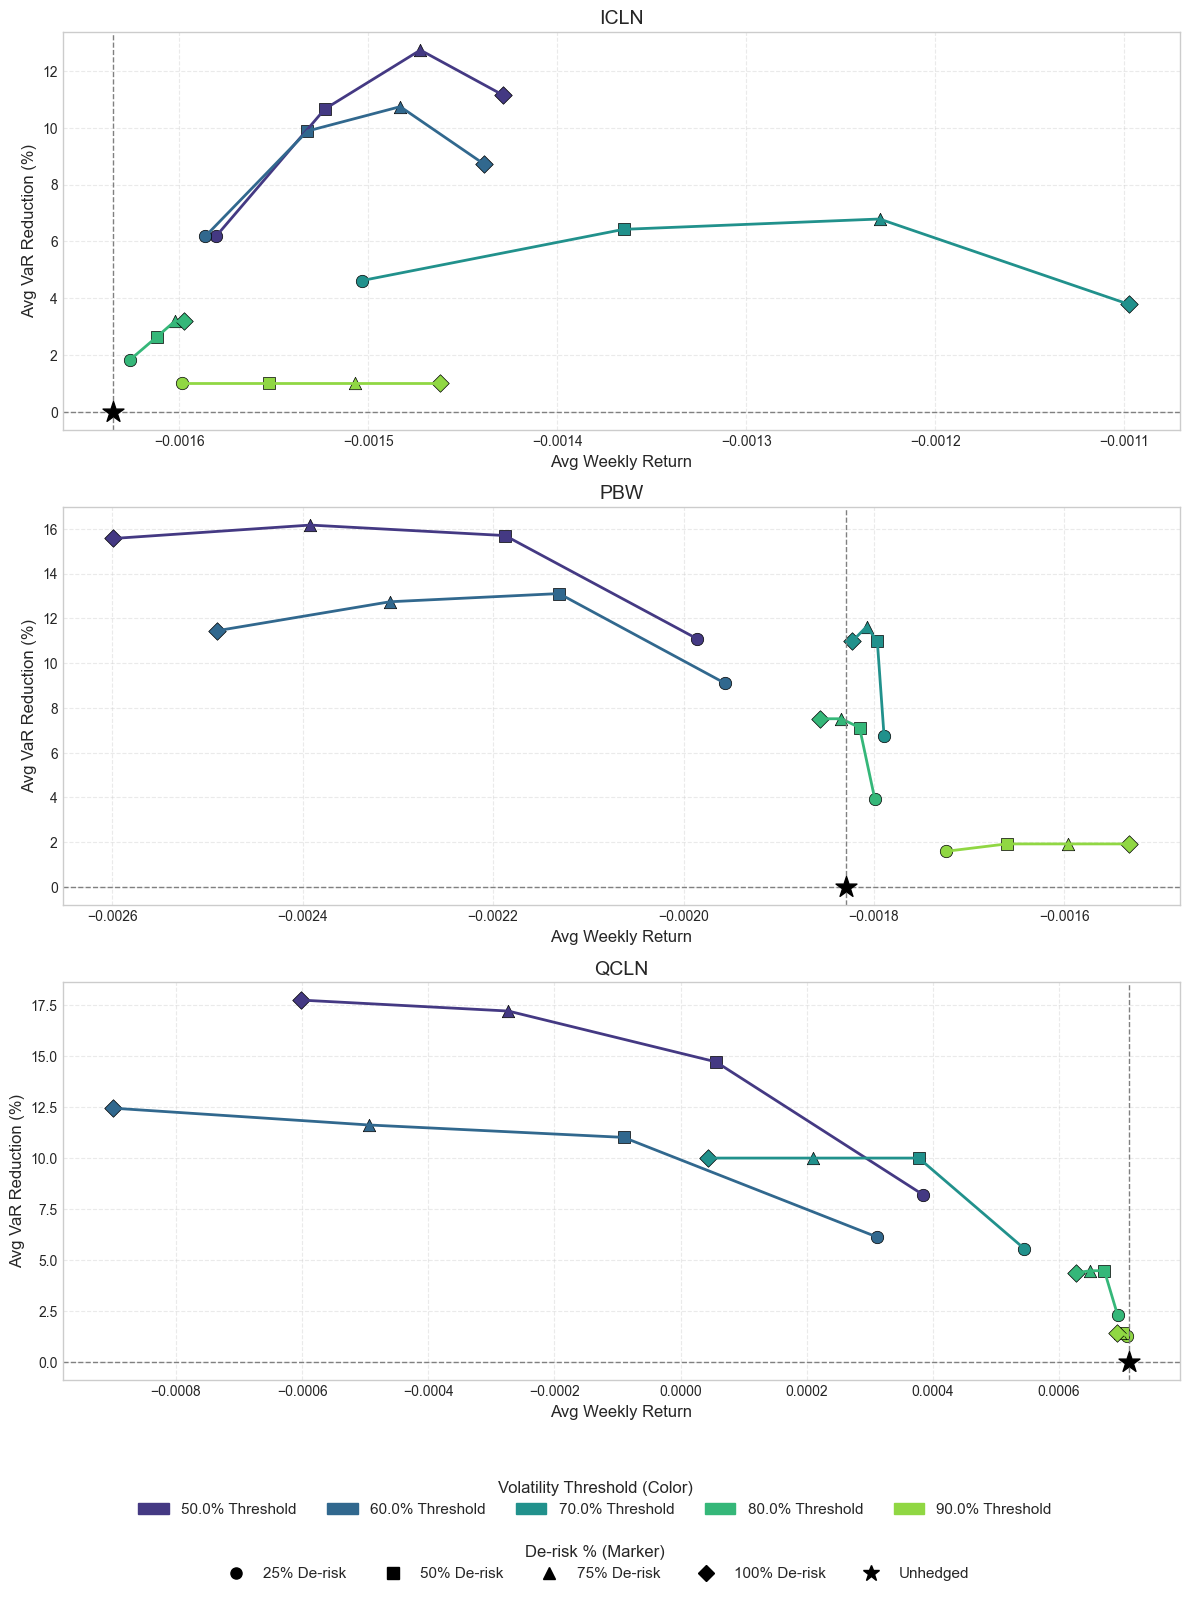

In [ ]:
def merge_weekly_sensitivities(
    absolute_df: pd.DataFrame,
    change_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Merge the absolute metrics (returns, VaR) with the risk improvement metrics (VaR Reduction, etc.)
    """
    merged = pd.merge(
        absolute_df,
        change_df,
        how="inner",
        left_on=["Thresh (%)", "De-risk (%)"],
        right_on=["Thresh", "De-risk"]
    )
    return merged

def plot_all_risk_frontiers_vertical(
    hedged_stats_dict: dict,
    sens_yearly_dict: dict,
    etf_names: list,
    figsize=(12, 16)
):
    """
    Plot risk reduction vs return frontier for multiple ETFs as vertical subplots,
    each with own axes, and two separate legends for thresholds and de-risk %.
    """
    fig, axes = plt.subplots(len(etf_names), 1, figsize=figsize)

    markers = {25: "o", 50: "s", 75: "^", 100: "D"}

    # Collect all thresholds across ETFs (just to make legends consistent)
    all_thresholds = set()
    for etf_name in etf_names:
        all_thresholds.update(
            merge_weekly_sensitivities(
                hedged_stats_dict[etf_name], sens_yearly_dict[etf_name]
            )["Thresh (%)"].dropna().unique()
        )
    all_thresholds = sorted(all_thresholds)
    threshold_colors = {thr: sns.color_palette("viridis", len(all_thresholds))[i] for i, thr in enumerate(all_thresholds)}

    for ax, etf_name in zip(axes, etf_names):
        merged_df = merge_weekly_sensitivities(
            hedged_stats_dict[etf_name],
            sens_yearly_dict[etf_name]
        )
        unhedged_row = hedged_stats_dict[etf_name].iloc[0]

        for thr in sorted(merged_df["Thresh (%)"].dropna().unique()):
            sub = merged_df[merged_df["Thresh (%)"] == thr].sort_values("De-risk (%)")
            ax.plot(
                sub["Avg Weekly Return"],
                sub["Avg VaR Red"],
                color=threshold_colors[thr],
                lw=2
            )
            for idx, row in sub.iterrows():
                ax.scatter(
                    row["Avg Weekly Return"],
                    row["Avg VaR Red"],
                    color=threshold_colors[thr],
                    marker=markers.get(row["De-risk (%)"], "o"),
                    s=80,
                    edgecolor="black",
                    linewidth=0.5
                )

        # Unhedged point
        ax.scatter(
            unhedged_row["Avg Weekly Return"],
            0,
            color="black",
            s=250,
            marker="*",
            zorder=5
        )

        ax.set_title(f"{etf_name}", fontsize=14)
        ax.set_xlabel("Avg Weekly Return", fontsize=12)
        ax.set_ylabel("Avg VaR Reduction (%)", fontsize=12)
        ax.axhline(0, color="grey", linestyle="--", lw=1)
        ax.axvline(unhedged_row["Avg Weekly Return"], color="grey", linestyle="--", lw=1)
        ax.grid(alpha=0.4, linestyle="--")

    # --- Separate legends ---
    # Threshold Legend (colors)
    thr_patches = [
        mpatches.Patch(color=threshold_colors[t], label=f"{t}% Threshold")
        for t in all_thresholds
    ]

    # De-risk Legend (markers)
    dr_handles = [
        mlines.Line2D([], [], color='black', marker=markers[d],
                      linestyle='None', markersize=8, label=f"{d}% De-risk")
        for d in sorted(markers.keys())
    ]

    # Unhedged (star)
    unhedged_handle = mlines.Line2D([], [], color="black", marker="*", linestyle="None", markersize=12, label="Unhedged")

    # Draw the two legends
    fig.legend(
        handles=thr_patches,
        loc="lower center",
        ncol=len(thr_patches),
        frameon=False,
        fontsize=11,
        title="Volatility Threshold (Color)",
        title_fontsize=12,
        bbox_to_anchor=(0.5, 0.04)
    )

    fig.legend(
        handles=dr_handles + [unhedged_handle],
        loc="lower center",
        ncol=5,
        frameon=False,
        fontsize=11,
        title="De-risk % (Marker)",
        title_fontsize=12,
        bbox_to_anchor=(0.5, 0.0)
    )

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    fig.savefig("fig/eff_frontier.png", dpi=300)
    plt.show()

# =====================
# Usage:
# =====================
hedged_stats_dict = {
    "ICLN": hedged_stats_ICLN,
    "PBW": hedged_stats_PBW,
    "QCLN": hedged_stats_QCLN
}
sens_yearly_dict = {
    "ICLN": sens_yearly_ICLN,
    "PBW": sens_yearly_PBW,
    "QCLN": sens_yearly_QCLN
}

plot_all_risk_frontiers_vertical(
    hedged_stats_dict=hedged_stats_dict,
    sens_yearly_dict=sens_yearly_dict,
    etf_names=["ICLN", "PBW", "QCLN"]
)


In [367]:
hedged_stats_dict

{'ICLN':                   Strategy  Thresh (%)  De-risk (%)  Avg Weekly Return  \
 0                 Unhedged         NaN          NaN          -0.001635   
 1    Hedged 25% @ 50th pct        50.0         25.0          -0.001581   
 2    Hedged 50% @ 50th pct        50.0         50.0          -0.001523   
 3    Hedged 75% @ 50th pct        50.0         75.0          -0.001473   
 4   Hedged 100% @ 50th pct        50.0        100.0          -0.001429   
 5    Hedged 25% @ 60th pct        60.0         25.0          -0.001586   
 6    Hedged 50% @ 60th pct        60.0         50.0          -0.001532   
 7    Hedged 75% @ 60th pct        60.0         75.0          -0.001483   
 8   Hedged 100% @ 60th pct        60.0        100.0          -0.001439   
 9    Hedged 25% @ 70th pct        70.0         25.0          -0.001504   
 10   Hedged 50% @ 70th pct        70.0         50.0          -0.001365   
 11   Hedged 75% @ 70th pct        70.0         75.0          -0.001230   
 12  Hedged 100% 

In [368]:
sens_yearly_dict

{'ICLN':     Thresh  De-risk  Avg Weekly Return Improvement  Avg VaR Red  Avg CVaR Red  \
 0       50       25                       0.306082     6.176732      4.961164   
 1       50       50                       0.455156    10.658247      8.787361   
 2       50       75                       0.449423    12.730417     10.651807   
 3       50      100                       0.291095    11.156723     10.817221   
 4       60       25                      -1.979185     6.176732      4.268507   
 5       60       50                      -4.028614     9.882335      7.402048   
 6       60       75                      -6.147330    10.740637      7.879179   
 7       60      100                      -8.334360     8.729404      7.351936   
 8       70       25                      -0.512355     4.622329      2.851600   
 9       70       50                      -1.060130     6.426078      5.013066   
 10      70       75                      -1.642825     6.789433      5.260966   
 11     

In [337]:
sens_yearly_dict

{'ICLN':     Thresh  De-risk  Avg Weekly Return Improvement  Avg VaR Red  Avg CVaR Red  \
 0       50       25                       0.306082     6.176732      4.961164   
 1       50       50                       0.455156    10.658247      8.787361   
 2       50       75                       0.449423    12.730417     10.651807   
 3       50      100                       0.291095    11.156723     10.817221   
 4       60       25                      -1.979185     6.176732      4.268507   
 5       60       50                      -4.028614     9.882335      7.402048   
 6       60       75                      -6.147330    10.740637      7.879179   
 7       60      100                      -8.334360     8.729404      7.351936   
 8       70       25                      -0.512355     4.622329      2.851600   
 9       70       50                      -1.060130     6.426078      5.013066   
 10      70       75                      -1.642825     6.789433      5.260966   
 11     

In [284]:
def plot_cumulative_returns(etf_name,
                            renewable_df,
                            garch_forecast,
                            start_date=None,
                            end_date=None,
                            vol_thr = 0,
                            de_risk=0):

    hedged_ret = compute_hedged_returns(
      renewable_df[etf_name],
      garch_forecast[etf_name],
      bond_returns["SHY"],
      vol_thr,
      de_risk
    )

    raw_ret_cropped = renewable_df[etf_name].loc[start_date:end_date]
    hedged_ret_cropped = hedged_ret.loc[start_date:end_date]

    # Compute cumulative returns
    cum_raw   = (1 + raw_ret_cropped).cumprod()
    cum_hedged= (1 + hedged_ret_cropped).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(cum_raw.index, cum_raw, label="Non-Hedged", color="blue")

    plt.plot(cum_hedged.index, cum_hedged,
         label=f"Hedged ({de_risk*100:.0f}% @ {vol_thr*100:.0f}th %ile)",color="red")

    plt.title(f"{etf_name}: Cumulative Returns\nNon-Hedged vs Hedged ({de_risk*100:.0f}% de-risk , {vol_thr*100:.0f}th %ile threshold)",
          fontsize=14)

    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (Growth of $1)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [285]:

def plot_weekly_pnl_GARCH(
    etf_name: str,
    returns: pd.DataFrame,
    garch_forecast: dict,
    bond_returns: pd.DataFrame,
    start_date: str = None,
    end_date: str = None,
    vol_thr: float = 0,
    de_risk: float = 0,
    title = None
):
    """
    Plot cumulative P&L assuming weekly reset to $1
    and simply summing weekly profits/losses (no compounding).
    """

    # Build hedged returns
    hedged_rets = compute_hedged_returns(
        returns[etf_name],
        garch_forecast[etf_name],
        bond_returns["SHY"],
        vol_thr,
        de_risk
    )

    # Slice to desired time
    raw_ret_cropped = renewable_df[etf_name].loc[start_date:end_date]
    hedged_ret_cropped = hedged_rets.loc[start_date:end_date]

    # Convert to weekly returns
    raw_weekly = raw_ret_cropped.resample('W-FRI').agg(lambda x: (1 + x).prod() - 1)
    hedged_weekly = hedged_ret_cropped.resample('W-FRI').agg(lambda x: (1 + x).prod() - 1)


    # Cumulate the excess returns
    raw_cum_excess = pd.Series(0, index=raw_weekly.index)
    hedged_cum_excess = pd.Series(0, index=hedged_weekly.index)

    for i in range(len(raw_weekly)):
        if i == 0:
            raw_cum_excess.iloc[i] = raw_weekly.iloc[i]
            hedged_cum_excess.iloc[i] = hedged_weekly.iloc[i]
        else:
            # Add this week's return to the cumulative excess
            raw_cum_excess.iloc[i] = raw_cum_excess.iloc[i-1] + raw_weekly.iloc[i]
            hedged_cum_excess.iloc[i] = hedged_cum_excess.iloc[i-1] + hedged_weekly.iloc[i]
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Plot cumulative excess returns
    plt.plot(raw_cum_excess.index, raw_cum_excess.values, 
            label='Unhedged', color='red', alpha=0.7)
    plt.plot(hedged_cum_excess.index, hedged_cum_excess.values, 
            label=f'Hedged ({int(vol_thr*100)}%/{int(de_risk*100)}%)', 
            color='blue', alpha=0.7)
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # Formatting
    if title is None:
        title = f'Cumulative Excess Returns (Weekly Reset)\n{start_date} to {end_date}'
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Excess Return')
    
    # Add legend
    plt.legend(loc = "upper right")
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add summary statistics
    stats_text = (
        f'Unhedged Final: {raw_cum_excess.iloc[-1]:.2%}\n'
        f'Hedged Final: {hedged_cum_excess.iloc[-1]:.2%}\n'
        f'Unhedged Vol: {np.std(raw_weekly)*np.sqrt(52):.2%}\n'
        f'Hedged Vol: {np.std(hedged_weekly)*np.sqrt(52):.2%}'
    )
    
    # Position the text box in the top left
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


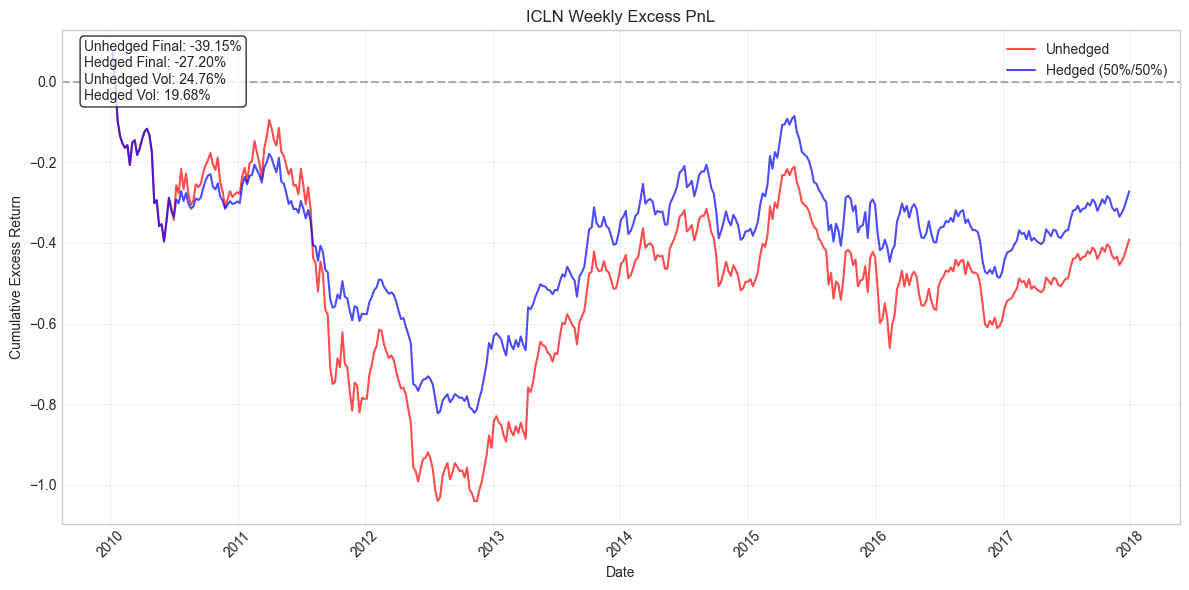

In [329]:
plot_weekly_pnl_GARCH(etf_name ="ICLN",
                    returns = renewable_df,
                    garch_forecast = garch_forecast,
                    bond_returns =bond_returns,
                          start_date="2010-01-01",
                          end_date="2017-12-31",
                          vol_thr = 0.7,
                          de_risk=0.75,
                          title = "ICLN Weekly Excess PnL")


In [350]:
def plot_cumulative_returns_yearly(
    etf_name,
    renewable_df,
    garch_forecast,
    start_date=None,
    end_date=None,
    vol_thr=0.0,
    de_risk=0.0,
    figsize=(14,5)
):
    """
    Plot yearly-resetting cumulative returns for raw vs hedged strategies,
    with a vertical line at the start of each calendar year.
    """
    # build hedged series
    hedged = compute_hedged_returns(
        renewable_df[etf_name],
        garch_forecast[etf_name],
        bond_returns["SHY"],
        vol_thr,
        de_risk
    )
    raw = renewable_df[etf_name].loc[hedged.index]

    # crop to date window if requested
    if start_date:
        raw, hedged = raw.loc[start_date:], hedged.loc[start_date:]
    if end_date:
        raw, hedged = raw.loc[:end_date], hedged.loc[:end_date]

    years = sorted(raw.index.year.unique())
    fig, ax = plt.subplots(figsize=figsize)

    # plot each year's cum-prod
    for y in years:
        mask = raw.index.year == y
        dates = raw.index[mask]
        cum_raw = (1 + raw[mask]).cumprod()
        cum_hdg = (1 + hedged[mask]).cumprod()

        # only label the first year
        lbl_raw = "Non-Hedged" if y == years[0] else ""
        lbl_hdg = f"Hedged ({de_risk*100:.0f}% @ {vol_thr*100:.0f}th pct)" if y == years[0] else ""

        ax.plot(dates, cum_raw, color="C0", lw=1.5, label=lbl_raw)
        ax.plot(dates, cum_hdg, color="C1", lw=1.5, label=lbl_hdg)

    # vertical lines at Jan 1 of each year (including first)
    for y in years:
        ax.axvline(pd.Timestamp(f"{y}-01-01"), color="0.6", linestyle="--", lw=0.8)

    ax.set_title(
        f"{etf_name}: Yearly Reset Cumulative Returns\n"
        f"Hedged ({de_risk*100:.0f}% de-risk, {vol_thr*100:.0f}th percentile)",
        fontsize=14
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return (Growth of $1)")
    ax.legend(loc="upper left")
    ax.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    fig.savefig("fig/ICLN_yearly_reset.png", dpi = 300)
    plt.show()

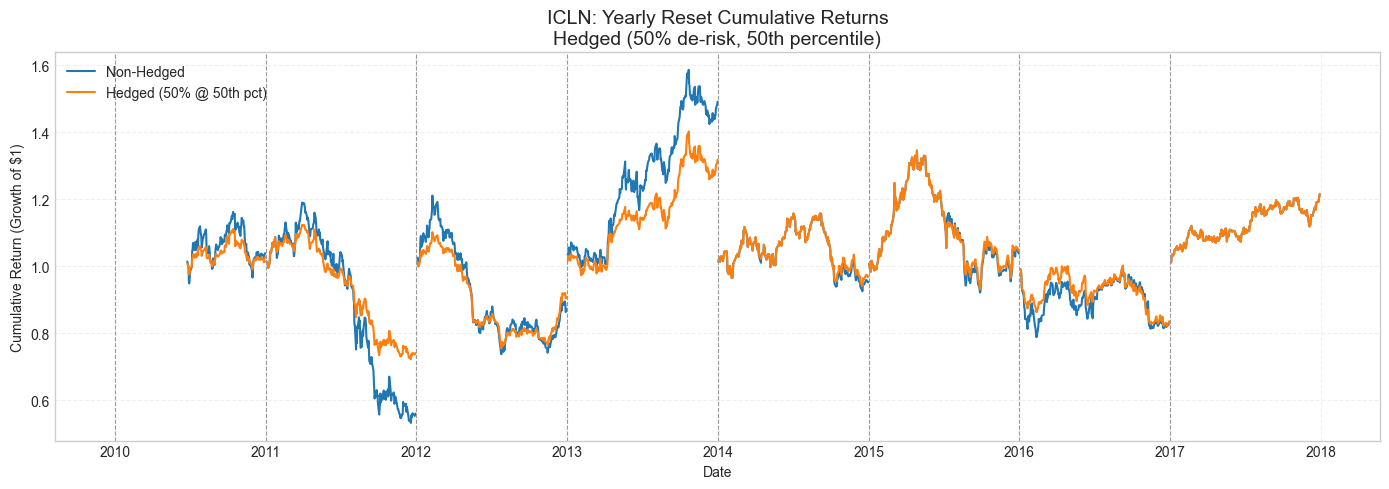

In [351]:
plot_cumulative_returns_yearly("ICLN",
                          renewable_df,
                          garch_forecast,
                          start_date="2010-06-25",
                          end_date="2017-12-31",
                          vol_thr = 0.5,
                          de_risk=0.5)

In [317]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cumulative_returns_multi(
    etf_name,
    renewable_df,
    garch_forecast,
    vol_thr_list: list,
    de_risk_list: list,
    start_date=None,
    end_date=None,
    color_base="Blues",   # <- NEW: choose your color family
    legend_pos = "upper right",
    figsize=(12,6)
):
    """
    Plot cumulative (non-yearly-reset) returns for non-hedged and multiple hedged strategies.
    One color spectrum (e.g. 'Blues') for hedged lines.
    """
    assert len(vol_thr_list) == len(de_risk_list), "vol_thr_list and de_risk_list must match length"

    # Raw unhedged returns
    raw_ret = renewable_df[etf_name]
    if start_date:
        raw_ret = raw_ret.loc[start_date:]
    if end_date:
        raw_ret = raw_ret.loc[:end_date]

    cum_raw = (1 + raw_ret).cumprod()

    # Start plot
    fig, ax = plt.subplots(figsize=figsize)

    # build color palette from a single sequential map
    cmap = sns.color_palette(color_base, len(vol_thr_list))

    for i, (vol_thr, de_risk) in enumerate(zip(vol_thr_list, de_risk_list)):
        # compute hedged returns
        hedged_ret = compute_hedged_returns(
            renewable_df[etf_name],
            garch_forecast[etf_name],
            bond_returns["SHY"],
            vol_thr,
            de_risk
        )

        if start_date:
            hedged_ret = hedged_ret.loc[start_date:]
        if end_date:
            hedged_ret = hedged_ret.loc[:end_date]

        cum_hedged = (1 + hedged_ret).cumprod()

        label = f"Hedged {int(de_risk*100)}% @ {int(vol_thr*100)}th pct"
        ax.plot(cum_hedged.index, cum_hedged, color=cmap[i], lw=0.6, label=label)

    # plot non-hedged (bold black)
    ax.plot(cum_raw.index, cum_raw, label="Non-Hedged", color="black", lw=2.2)

    ax.set_title(
        f"{etf_name}: Cumulative Returns\nMultiple Hedging Strategies",
        fontsize=14
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return (Growth of $1)")
    ax.legend(loc=legend_pos, fontsize=9)
    ax.grid(alpha=0.4, linestyle="--")
    plt.tight_layout()

    fig.savefig(f"fig/{etf_name}_cum_returns_multi__train.png", dpi=300)
    plt.show()


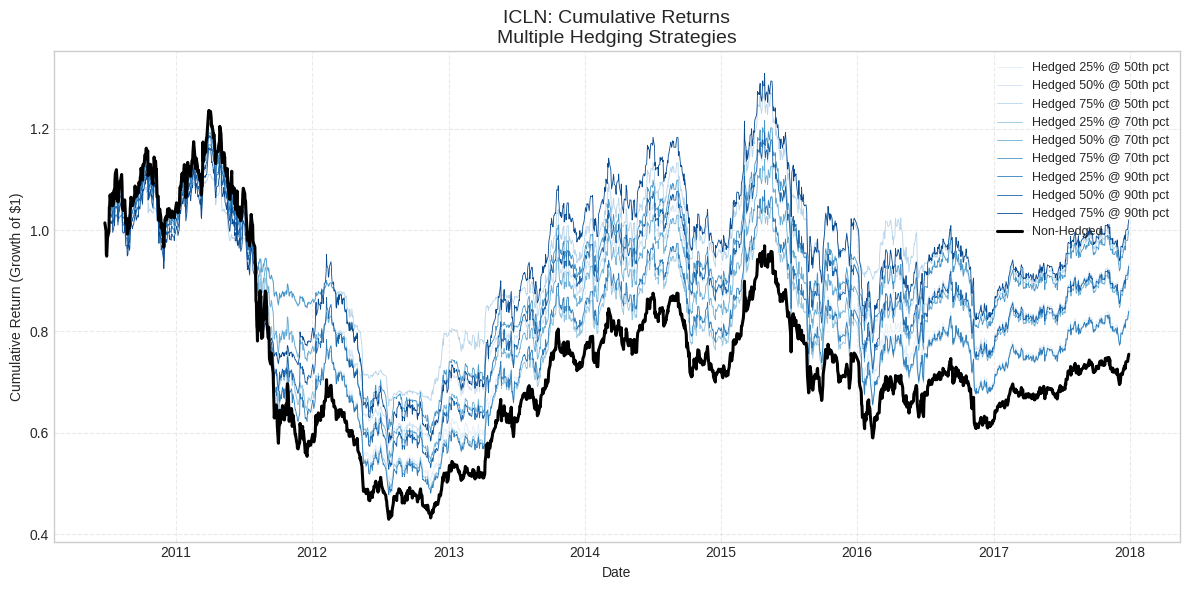

In [318]:
plot_cumulative_returns_multi("ICLN",
                          renewable_df,
                          garch_forecast,
                          start_date="2010-06-25",
                          end_date="2017-12-31",
                          vol_thr_list = [0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.9, 0.9, 0.9],
                          de_risk_list=[0.25,0.5, 0.75, 0.25,0.5, 0.75, 0.25,0.5, 0.75])


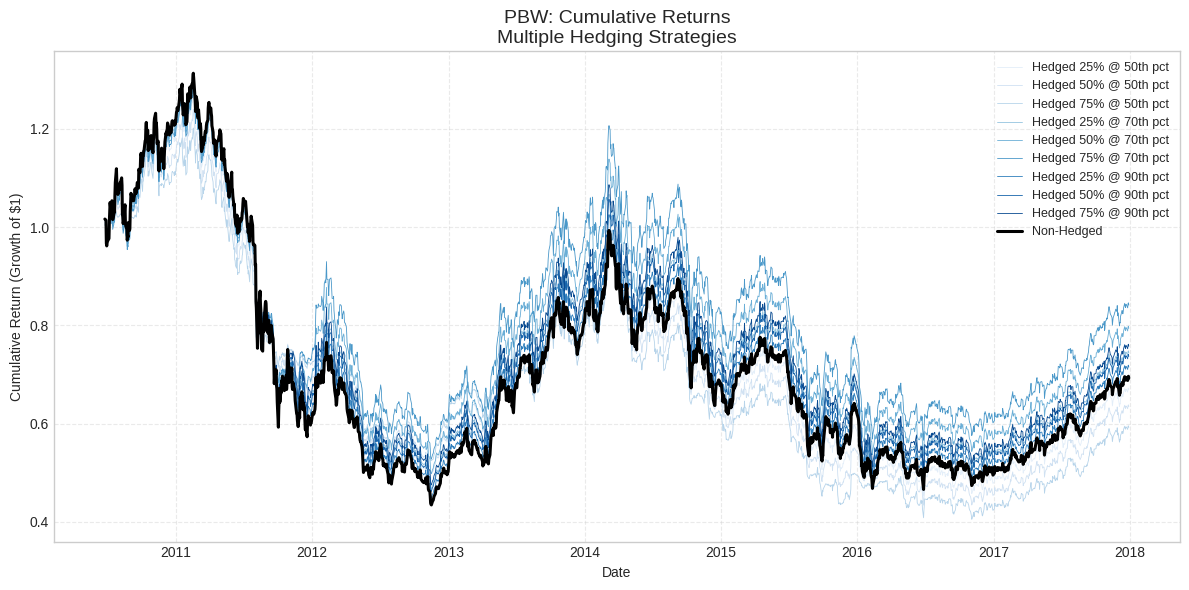

In [319]:
plot_cumulative_returns_multi("PBW",
                          renewable_df,
                          garch_forecast,
                          start_date="2010-06-25",
                          end_date="2017-12-31",
                          vol_thr_list = [0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.9, 0.9, 0.9],
                          de_risk_list=[0.25,0.5, 0.75, 0.25,0.5, 0.75, 0.25,0.5, 0.75])


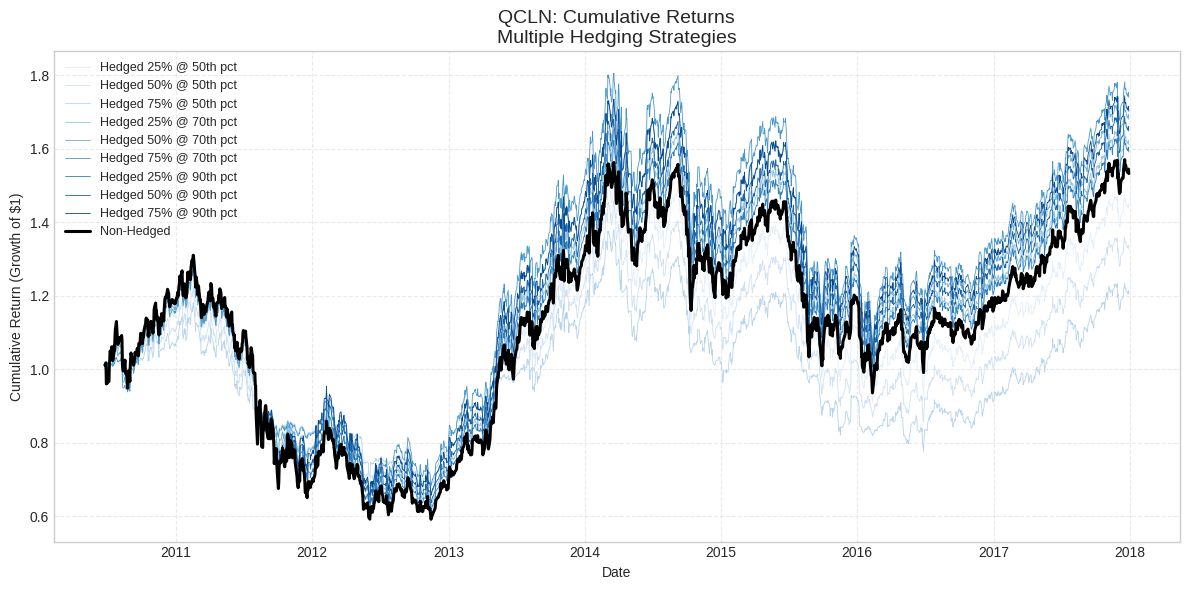

In [320]:
plot_cumulative_returns_multi("QCLN",
                          renewable_df,
                          garch_forecast,
                          start_date="2010-06-25",
                          end_date="2017-12-31",
                          vol_thr_list = [0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.9, 0.9, 0.9],
                          de_risk_list=[0.25,0.5, 0.75, 0.25,0.5, 0.75, 0.25,0.5, 0.75],
                          legend_pos = "upper left")


In [140]:
import numpy as np
import pandas as pd

def full_period_stats_GARCH(
    rets        : pd.Series,
    fc          : pd.Series,
    bond_rets   : pd.Series,
    start_date  : str,
    end_date    : str,
    threshold_list: list[float],
    de_risk_list : list[float],
    min_obs: int = 50,
) -> pd.DataFrame:
    """
    Compute hedge statistics over one full period (not year-by-year averages),
    comparing unhedged vs. multiple hedged strategies.
    """
    records = []

    # 1. Plain (unhedged) stats first
    raw = rets.loc[start_date:end_date]
    if len(raw) >= min_obs:
        def compute_stats(series):
            cum_ret = (1 + series).cumprod().iloc[-1] - 1.0
            var_5   = series.quantile(0.05)
            cvar_5  = series[series <= var_5].mean()
            path    = (1 + series).cumprod()
            mdd     = (path / path.cummax() - 1).min()
            sharpe  = series.mean() / series.std(ddof=0) * np.sqrt(252)
            vol     = series.std(ddof=0) * np.sqrt(252)
            return {
                "Cumulative Return": cum_ret,
                "VaR (5%)":          var_5,
                "CVaR (5%)":         cvar_5,
                "Max Drawdown":      mdd,
                "Sharpe Ratio":      sharpe,
                "Volatility":        vol,
            }

        plain_stats = compute_stats(raw)
        records.append({
            "Strategy":         "Unhedged",
            "Thresh (%)":       np.nan,
            "De-risk (%)":      np.nan,
            "Cum Return":       plain_stats["Cumulative Return"],
            "VaR (5%)":         plain_stats["VaR (5%)"],
            "CVaR (5%)":        plain_stats["CVaR (5%)"],
            "Max Drawdown":     plain_stats["Max Drawdown"],
            "Sharpe Ratio":     plain_stats["Sharpe Ratio"],
            "Volatility":       plain_stats["Volatility"],
            "Obs":              len(raw),
        })

    # 2. Now compute each hedged strategy
    for thr, dr in zip(threshold_list, de_risk_list):
        raw = rets.loc[start_date:end_date]
        bond = bond_rets.reindex(raw.index)

        if len(raw) < min_obs:
            continue

        vol_period = fc.loc[:end_date]

        # Build hedged returns
        hedged = compute_hedged_returns(
            equity_ret   = raw,
            vol_forecast = vol_period,
            safe_ret     = bond,
            vol_thr      = thr,
            de_risk      = dr,
        )

        if len(hedged) < min_obs:
            continue

        hedged_stats = compute_stats(hedged)

        records.append({
            "Strategy":         f"Hedged {int(dr*100)}% @ {int(thr*100)}th pct",
            "Thresh (%)":       int(thr * 100),
            "De-risk (%)":      int(dr * 100),
            "Cum Return":       hedged_stats["Cumulative Return"],
            "VaR (5%)":         hedged_stats["VaR (5%)"],
            "CVaR (5%)":        hedged_stats["CVaR (5%)"],
            "Max Drawdown":     hedged_stats["Max Drawdown"],
            "Sharpe Ratio":     hedged_stats["Sharpe Ratio"],
            "Volatility":       hedged_stats["Volatility"],
            "Obs":              len(hedged),
        })

    return pd.DataFrame(records)


# Test-sample

In [253]:
champion_threshold = 0.7
champion_derisk = 0.75

In [344]:
years_test = list(range(2018, 2025))
champion_threshold_list = [0.5]
champion_de_risk_list   = [0.5]

# rets and fc should already be defined:

sens_yearly_ICLN_test = yearly_GARCH_sensitivity_avg_change_weekly(renewable_df['ICLN'], garch_forecast["ICLN"], bond_returns["SHY"],years_test, champion_threshold_list, champion_de_risk_list)
sens_yearly_PBW_test = yearly_GARCH_sensitivity_avg_change_weekly(renewable_df['PBW'], garch_forecast["PBW"], bond_returns["SHY"], years_test, champion_threshold_list, champion_de_risk_list)
sens_yearly_QCLN_test = yearly_GARCH_sensitivity_avg_change_weekly(renewable_df['QCLN'], garch_forecast["QCLN"], bond_returns["SHY"], years_test, champion_threshold_list, champion_de_risk_list)




In [372]:
print("ICLN")
print(sens_yearly_ICLN_test)
print(hedged_stats_ICLN_test_yearly_avg)
print("PBW")
print(sens_yearly_PBW_test)
print(hedged_stats_PBW_test_yearly_avg)
print("QCLN")
print(sens_yearly_QCLN_test)
print(hedged_stats_QCLN_test_yearly_avg)

ICLN
   Thresh  De-risk  Avg Weekly Return Improvement  Avg VaR Red  Avg CVaR Red  \
0      50       50                     -549.21843    25.047511     22.630928   

   Avg MDD Red  Avg Sharpe Ratio Improvement  Avg Volatility Reduction  \
0    24.729253                   -1041.29515                 29.393511   

   Years Used  
0           7  
                Strategy  Thresh (%)  De-risk (%)  Avg Weekly Return  \
0               Unhedged         NaN          NaN           0.001591   
1  Hedged 50% @ 50th pct        50.0         50.0           0.001039   

   Avg VaR (5%)  Avg CVaR (5%)  Avg Max Drawdown  Avg Sharpe  Avg Volatility  \
0     -0.057461      -0.076587         -0.265941    0.265781        0.278277   
1     -0.039031      -0.051857         -0.182093    0.199939        0.183416   

   Years Used  
0           7  
1           7  
PBW
   Thresh  De-risk  Avg Weekly Return Improvement  Avg VaR Red  Avg CVaR Red  \
0      50       50                      23.502987    33.308045 

In [342]:
sens_yearly_PBW_test

Thresh  De-risk  Avg Weekly Return Improvement  Avg VaR Red  Avg CVaR Red  \
0      50       50                      23.502987    33.308045     34.561058   

   Avg MDD Red  Avg Sharpe Ratio Improvement  Avg Volatility Reduction  \
0    34.468401                      9.020209                 34.882836   

   Years Used  
0           7

In [345]:
sens_yearly_QCLN_test

Thresh  De-risk  Avg Weekly Return Improvement  Avg VaR Red  Avg CVaR Red  \
0      50       50                       6.370269    34.746081     31.263363   

   Avg MDD Red  Avg Sharpe Ratio Improvement  Avg Volatility Reduction  \
0    33.254498                     -3.168699                 33.693965   

   Years Used  
0           7

In [333]:
champion_threshold = 0.5
champion_derisk = 0.5

start_date_test = "2018-01-01"
end_date_test = "2014-12-31"
years = list(range(2018, 2025))
threshold_list = [champion_threshold]
de_risk_list   = [champion_derisk]

hedged_stats_ICLN_test_yearly_avg = yearly_stats_averages_weekly(renewable_df['ICLN'],garch_forecast['ICLN'], bond_returns['SHY'], years, threshold_list,de_risk_list)
hedged_stats_PBW_test_yearly_avg = yearly_stats_averages_weekly(renewable_df['PBW'],garch_forecast['PBW'], bond_returns['SHY'], years, threshold_list,de_risk_list)
hedged_stats_QCLN_test_yearly_avg = yearly_stats_averages_weekly(renewable_df['QCLN'],garch_forecast['QCLN'], bond_returns['SHY'], years, threshold_list,de_risk_list)

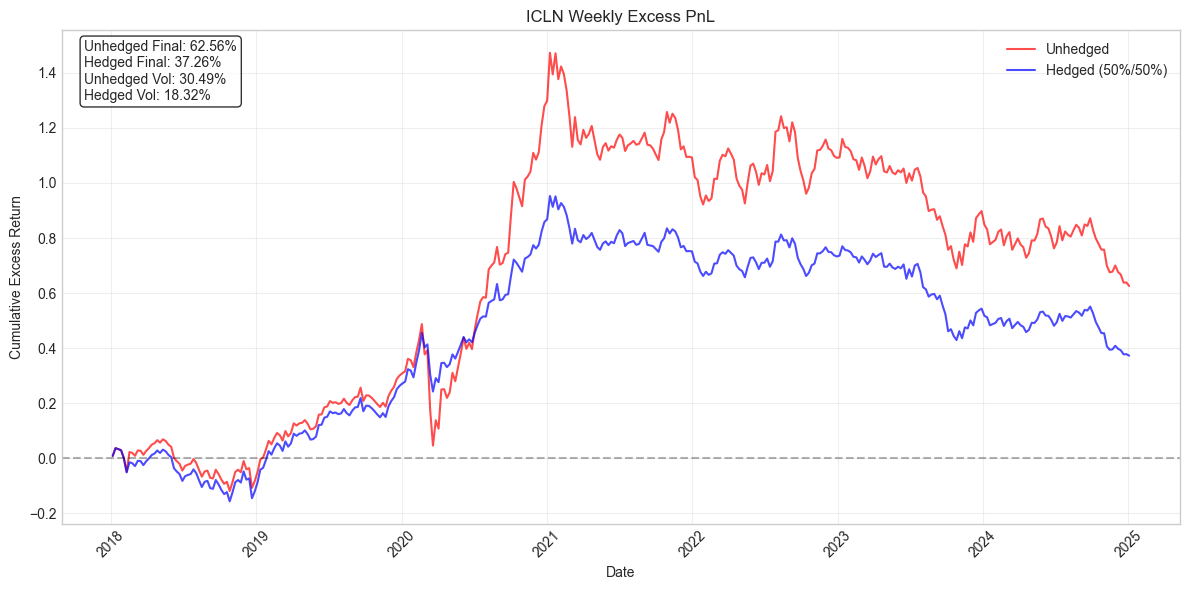

Strategy  Thresh (%)  De-risk (%)  Avg Weekly Return  \
0               Unhedged         NaN          NaN           0.001591   
1  Hedged 50% @ 50th pct        50.0         50.0           0.001039   

   Avg VaR (5%)  Avg CVaR (5%)  Avg Max Drawdown  Avg Sharpe  Avg Volatility  \
0     -0.057461      -0.076587         -0.265941    0.265781        0.278277   
1     -0.039031      -0.051857         -0.182093    0.199939        0.183416   

   Years Used  
0           7  
1           7

In [334]:
plot_weekly_pnl_GARCH(etf_name ="ICLN",
                    returns = renewable_df,
                    garch_forecast = garch_forecast,
                    bond_returns =bond_returns,
                          start_date=start_date_test,
                          end_date="2024-12-31",
                          vol_thr = champion_threshold,
                          de_risk=champion_derisk,
                          title = "ICLN Weekly Excess PnL")

hedged_stats_ICLN_test_yearly_avg

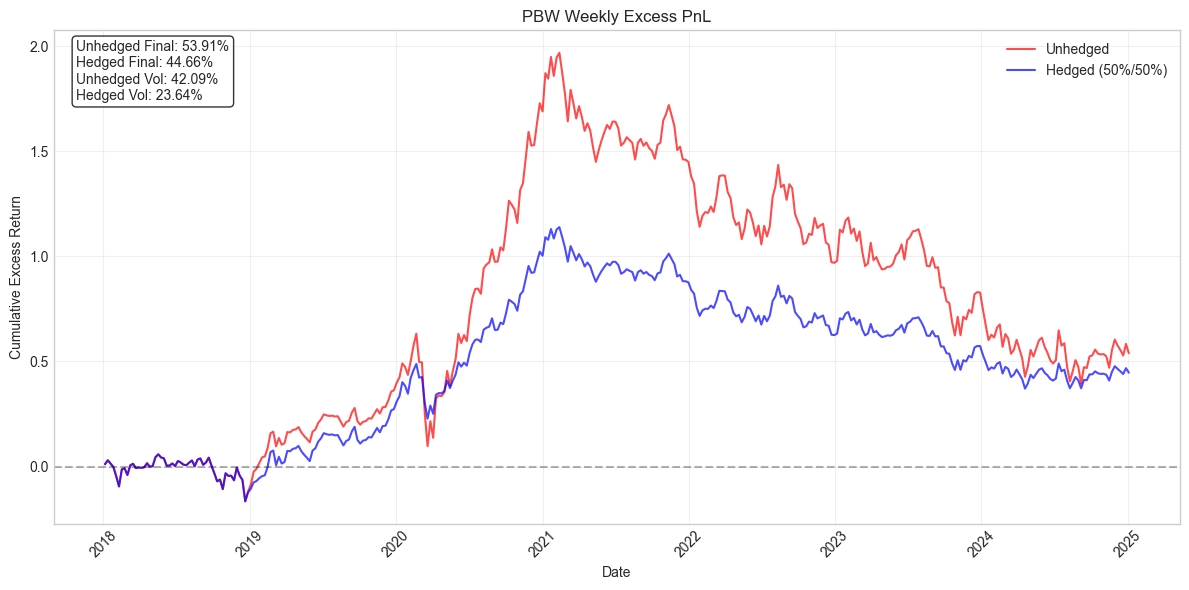

Strategy  Thresh (%)  De-risk (%)  Avg Weekly Return  \
0               Unhedged         NaN          NaN           0.001338   
1  Hedged 50% @ 50th pct        50.0         50.0           0.001311   

   Avg VaR (5%)  Avg CVaR (5%)  Avg Max Drawdown  Avg Sharpe  Avg Volatility  \
0     -0.078986      -0.106941         -0.344393    0.224946        0.391996   
1     -0.046095      -0.062279         -0.199806    0.249595        0.234435   

   Years Used  
0           7  
1           7

In [335]:
plot_weekly_pnl_GARCH(etf_name ="PBW",
                    returns = renewable_df,
                    garch_forecast = garch_forecast,
                    bond_returns =bond_returns,
                          start_date=start_date_test,
                          end_date="2024-12-31",
                          vol_thr = champion_threshold,
                          de_risk=champion_derisk,
                          title = "PBW Weekly Excess PnL")

hedged_stats_PBW_test_yearly_avg

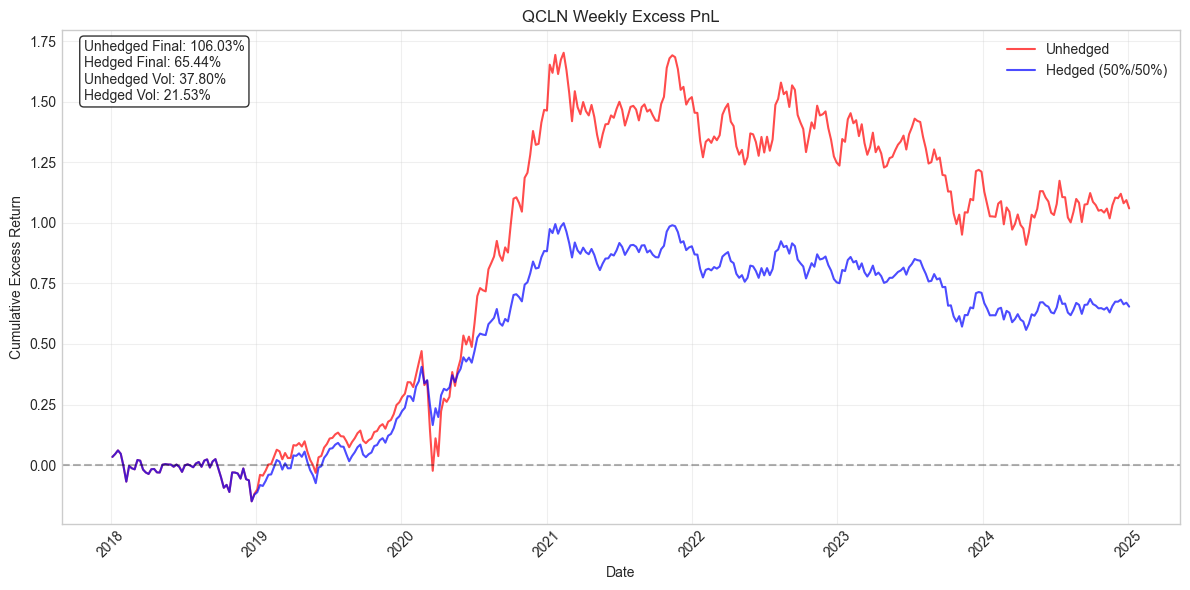

Strategy  Thresh (%)  De-risk (%)  Avg Weekly Return  \
0               Unhedged         NaN          NaN           0.002813   
1  Hedged 50% @ 50th pct        50.0         50.0           0.001780   

   Avg VaR (5%)  Avg CVaR (5%)  Avg Max Drawdown  Avg Sharpe  Avg Volatility  \
0     -0.074640      -0.095298         -0.292869    0.406313        0.351856   
1     -0.043202      -0.058312         -0.180326    0.391652        0.214726   

   Years Used  
0           7  
1           7

In [336]:
plot_weekly_pnl_GARCH(etf_name ="QCLN",
                    returns = renewable_df,
                    garch_forecast = garch_forecast,
                    bond_returns =bond_returns,
                          start_date=start_date_test,
                          end_date="2024-12-31",
                          vol_thr = champion_threshold,
                          de_risk=champion_derisk,
                          title = "QCLN Weekly Excess PnL")

hedged_stats_QCLN_test_yearly_avg

# Placebo GARCH

In [509]:
def count_hedge_days(
    vol_forecast: pd.Series,
    vol_thr: float = 0.5,
    start_date: str = "2018-01-01",
    end_date: str = "2024-12-31"
) -> tuple[int, pd.Series]:
    """
    Count how many days we hedge given a volatility threshold.
    
    Parameters
    ----------
    vol_forecast : pd.Series
        Volatility forecast series
    vol_thr : float
        Threshold percentile (e.g., 0.5 for median)
    start_date, end_date : str
        Date range to analyze
        
    Returns
    -------
    tuple[int, pd.Series]
        Number of hedge days and the binary hedge signal series
    """
    # Filter to date range
    mask = (vol_forecast.index >= start_date) & (vol_forecast.index <= end_date)
    fc = vol_forecast[mask]
    
    # Get the cutoff value
    cutoff = fc.quantile(vol_thr)
    
    # Create hedge signal (1 when we hedge, 0 when we don't)
    hedge_signal = (fc > cutoff).astype(int)
    
    # Count total hedge days
    n_hedge_days = hedge_signal.sum()
    
    # Print summary
    print(f"Analysis from {start_date} to {end_date}")
    print(f"Total days in period: {len(fc)}")
    print(f"Number of hedge days: {n_hedge_days}")
    print(f"Percentage of time hedged: {n_hedge_days/len(fc)*100:.1f}%")
    print(f"Volatility cutoff value: {cutoff:.4f}")
    
    return n_hedge_days, hedge_signal

# Let's check for each ETF
for ticker in ["ICLN", "PBW", "QCLN"]:
    print(f"\nResults for {ticker}:")
    n_days, signal = count_hedge_days(
        vol_forecast=garch_forecast[ticker],
        vol_thr=0.5,  # median
        start_date="2018-01-01",
        end_date="2024-12-31"
    )


Results for ICLN:
Analysis from 2018-01-01 to 2024-12-31
Total days in period: 364
Number of hedge days: 182
Percentage of time hedged: 50.0%
Volatility cutoff value: 0.0348

Results for PBW:
Analysis from 2018-01-01 to 2024-12-31
Total days in period: 364
Number of hedge days: 182
Percentage of time hedged: 50.0%
Volatility cutoff value: 0.0545

Results for QCLN:
Analysis from 2018-01-01 to 2024-12-31
Total days in period: 364
Number of hedge days: 182
Percentage of time hedged: 50.0%
Volatility cutoff value: 0.0485



Processing ICLN...
Analysis from 2018-01-01 to 2024-12-31
Total days in period: 364
Number of hedge days: 182
Percentage of time hedged: 50.0%
Volatility cutoff value: 0.0348
Created 0 random portfolios...
Created 100 random portfolios...
Created 200 random portfolios...
Created 300 random portfolios...
Created 400 random portfolios...
Created 500 random portfolios...
Created 600 random portfolios...
Created 700 random portfolios...
Created 800 random portfolios...
Created 900 random portfolios...

Processing PBW...
Analysis from 2018-01-01 to 2024-12-31
Total days in period: 364
Number of hedge days: 182
Percentage of time hedged: 50.0%
Volatility cutoff value: 0.0545
Created 0 random portfolios...
Created 100 random portfolios...
Created 200 random portfolios...
Created 300 random portfolios...
Created 400 random portfolios...
Created 500 random portfolios...
Created 600 random portfolios...
Created 700 random portfolios...
Created 800 random portfolios...
Created 900 random portfol

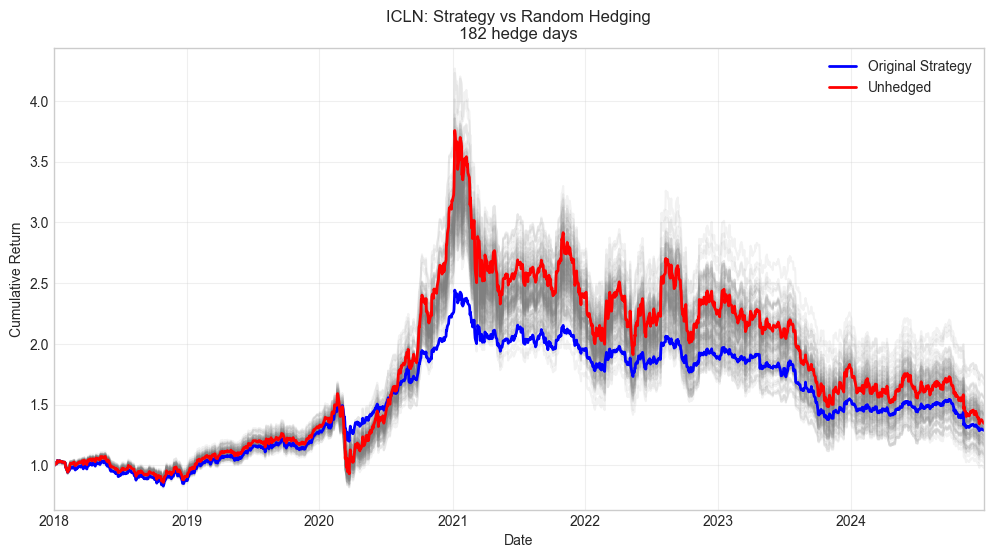

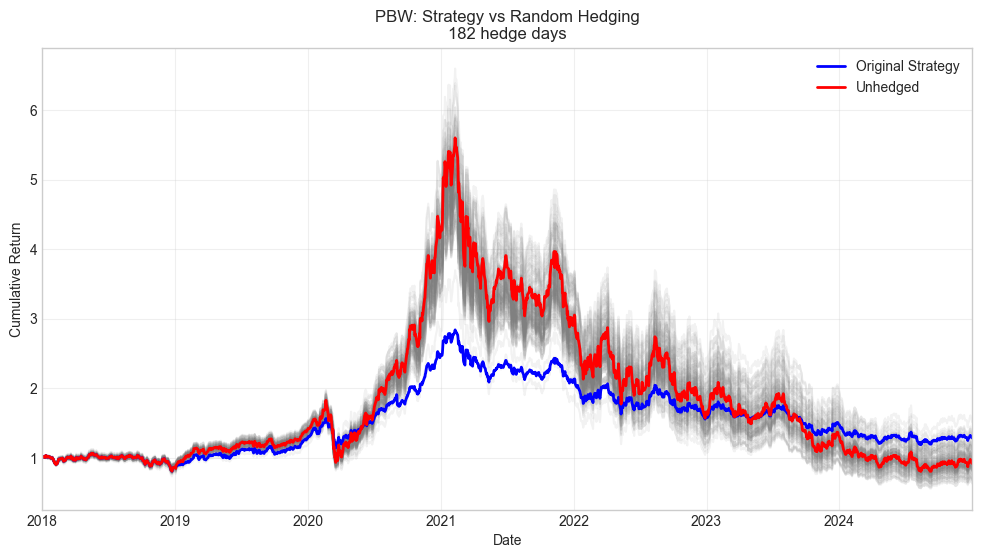

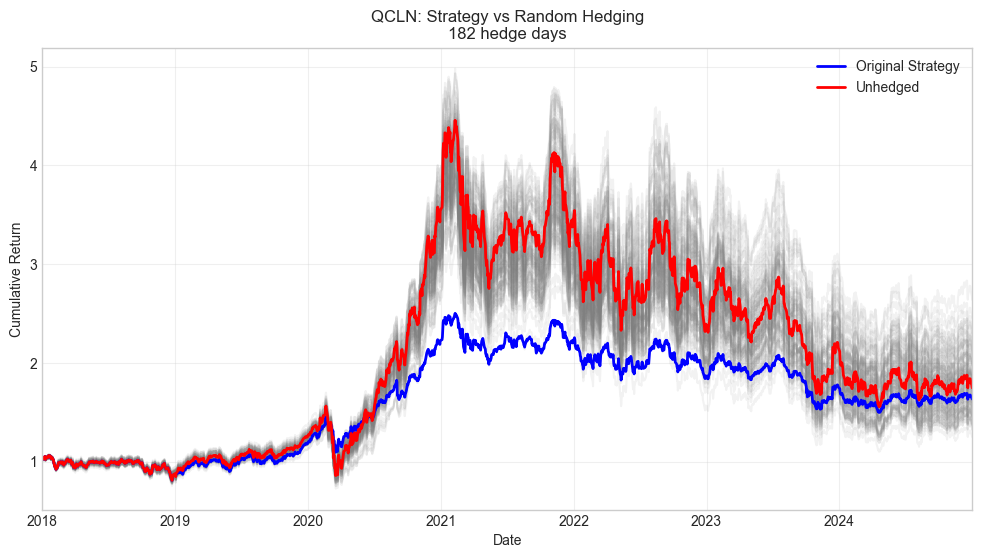


Strategy Statistics:
  Ticker  Strategy  Final Return  Annualized Vol  Sharpe Ratio
0   ICLN  Original        0.2894          0.1835        0.2886
1   ICLN  Unhedged        0.3468          0.3054        0.2911
0    PBW  Original        0.2839          0.2367        0.2681
1    PBW  Unhedged       -0.0821          0.4214        0.1817
0   QCLN  Original        0.6339          0.2156        0.4313
1   QCLN  Unhedged        0.7465          0.3785        0.3980

Random Strategy Statistics:
  Ticker  Final Return (mean)  Final Return (std)  Annualized Vol (mean)  \
0   ICLN               0.3241              0.1564                 0.2928   
0    PBW              -0.0665              0.1590                 0.4044   
0   QCLN               0.7296              0.2775                 0.3632   

   Annualized Vol (std)  Sharpe Ratio (mean)  Sharpe Ratio (std)  
0                0.0040               0.2794              0.0568  
0                0.0043               0.1730              0.0588  
0 

In [528]:
champion_de_risk = 0.5
def create_random_portfolios(
    returns: pd.Series,
    n_hedge_days: int,
    bond_returns: pd.Series,
    de_risk: float,
    start_date: str,
    end_date: str,
    n_simulations: int = 1000,
    half_spread: float = 1e-4
) -> list[pd.Series]:
    """
    Create multiple random hedge portfolios with same number of hedge days as original.
    
    Parameters
    ----------
    returns : pd.Series
        Daily equity returns
    n_hedge_days : int
        Number of days to hedge (from original strategy)
    bond_returns : pd.Series
        Daily bond returns
    de_risk : float
        De-risking percentage when hedged
    start_date, end_date : str
        Date range for analysis
    n_simulations : int
        Number of random portfolios to create
    half_spread : float
        Transaction cost parameter
        
    Returns
    -------
    list[pd.Series]
        List of daily return series for each random portfolio
    """
    # Align and filter data
    common_idx = returns.index.intersection(bond_returns.index)
    mask = (common_idx >= start_date) & (common_idx <= end_date)
    common_idx = common_idx[mask]
    
    rets = returns.loc[common_idx]
    bonds = bond_returns.loc[common_idx]
    
    random_portfolios = []
    
    for sim in range(n_simulations):
        # Create random hedge timing
        random_idx = np.random.choice(
            len(rets), 
            size=n_hedge_days, 
            replace=False
        )
        
        # Create hedge signal series
        w_on_fcst = pd.Series(1.0, index=rets.index)
        w_on_fcst.iloc[random_idx] = 1.0 - de_risk
        
        # Compute transaction costs
        cost = half_spread * w_on_fcst.diff().abs().fillna(0.0)
        
        # Compute hedged returns
        hedged = (w_on_fcst * rets + 
                 (1.0 - w_on_fcst) * bonds - 
                 cost)
        
        random_portfolios.append(hedged)
        
        if sim % 100 == 0:  # Progress update
            print(f"Created {sim} random portfolios...")
    
    return random_portfolios

# Create random portfolios for each ticker
random_portfolios = {}
original_hedged = {}
n_hedge_days_dict = {}

for ticker in ["ICLN", "PBW", "QCLN"]:
    print(f"\nProcessing {ticker}...")
    
    # Get number of hedge days from original strategy
    n_days, _ = count_hedge_days(
        vol_forecast=garch_forecast[ticker],
        vol_thr=0.5,
        start_date="2018-01-01",
        end_date="2024-12-31"
    )
    n_hedge_days_dict[ticker] = n_days
    
    # Create random portfolios
    random_portfolios[ticker] = create_random_portfolios(
        returns=renewable_df[ticker],
        n_hedge_days=n_days,
        bond_returns=bond_returns["SHY"],
        de_risk=champion_de_risk,
        start_date="2018-01-01",
        end_date="2024-12-31",
        n_simulations=1000
    )
    
    # Get original strategy returns for comparison
    original_hedged[ticker] = compute_hedged_returns(
        equity_ret=renewable_df[ticker],
        vol_forecast=garch_forecast[ticker],
        safe_ret=bond_returns["SHY"],
        vol_thr=0.5,
        de_risk=champion_de_risk
    )



# Convert daily returns to cumulative returns and plot
start_date = "2018-01-01"
end_date = "2024-12-31"

# Create DataFrames to store results
strategy_stats = pd.DataFrame(columns=['Ticker', 'Strategy', 'Final Return', 'Annualized Vol', 'Sharpe Ratio'])
random_stats = pd.DataFrame(columns=['Ticker', 'Final Return (mean)', 'Final Return (std)', 
                                   'Annualized Vol (mean)', 'Annualized Vol (std)',
                                   'Sharpe Ratio (mean)', 'Sharpe Ratio (std)'])

for ticker in ["ICLN", "PBW", "QCLN"]:
    plt.figure(figsize=(12, 6))
    
    # Filter dates for original strategy and unhedged
    mask = (original_hedged[ticker].index >= start_date) & (original_hedged[ticker].index <= end_date)
    orig_hedged_test = original_hedged[ticker][mask]
    
    mask = (renewable_df[ticker].index >= start_date) & (renewable_df[ticker].index <= end_date)
    unhedged_test = renewable_df[ticker][mask]
    
    # Plot random portfolios
    for rp in random_portfolios[ticker][:100]:  # Plot first 100 for visibility
        cum_ret = (1 + rp).cumprod()
        plt.plot(cum_ret.index, cum_ret, color='gray', alpha=0.1)
    
    # Plot original strategy
    cum_orig = (1 + orig_hedged_test).cumprod()
    plt.plot(cum_orig.index, cum_orig, 'b-', 
            label='Original Strategy', linewidth=2)
    
    # Plot unhedged
    cum_unhedged = (1 + unhedged_test).cumprod()
    plt.plot(cum_unhedged.index, cum_unhedged, 'r-', 
            label='Unhedged', linewidth=2)
    
    plt.title(f'{ticker}: Strategy vs Random Hedging\n{n_hedge_days_dict[ticker]} hedge days')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
    plt.show()
    
    # Compute statistics using aligned data
    # Original strategy stats
    orig_weekly = orig_hedged_test.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
    orig_final_ret = cum_orig.iloc[-1] - 1
    orig_vol = orig_weekly.std() * np.sqrt(52)
    orig_sharpe = orig_weekly.mean() / orig_weekly.std() * np.sqrt(52)
    
    # Unhedged stats
    unhedged_weekly = unhedged_test.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
    unhedged_final_ret = cum_unhedged.iloc[-1] - 1
    unhedged_vol = unhedged_weekly.std() * np.sqrt(52)
    unhedged_sharpe = unhedged_weekly.mean() / unhedged_weekly.std() * np.sqrt(52)
    
    # Add to strategy_stats DataFrame
    strategy_stats = pd.concat([strategy_stats, pd.DataFrame({
        'Ticker': [ticker, ticker],
        'Strategy': ['Original', 'Unhedged'],
        'Final Return': [orig_final_ret, unhedged_final_ret],
        'Annualized Vol': [orig_vol, unhedged_vol],
        'Sharpe Ratio': [orig_sharpe, unhedged_sharpe]
    })])
    
    # Random portfolio stats
    random_final_rets = []
    random_vols = []
    random_sharpes = []
    
    for rp in random_portfolios[ticker]:
        rp_weekly = rp.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
        random_final_rets.append((1 + rp).cumprod().iloc[-1] - 1)
        random_vols.append(rp_weekly.std() * np.sqrt(52))
        random_sharpes.append(rp_weekly.mean() / rp_weekly.std() * np.sqrt(52))
    
    # Add to random_stats DataFrame
    random_stats = pd.concat([random_stats, pd.DataFrame({
        'Ticker': [ticker],
        'Final Return (mean)': [np.mean(random_final_rets)],
        'Final Return (std)': [np.std(random_final_rets)],
        'Annualized Vol (mean)': [np.mean(random_vols)],
        'Annualized Vol (std)': [np.std(random_vols)],
        'Sharpe Ratio (mean)': [np.mean(random_sharpes)],
        'Sharpe Ratio (std)': [np.std(random_sharpes)]
    })])

# Format the DataFrames
strategy_stats = strategy_stats.round(4)
random_stats = random_stats.round(4)

# Save the results
strategy_stats.to_csv('garch_strategy_stats.csv', index=False)
random_stats.to_csv('garch_random_stats.csv', index=False)

# Display the results
print("\nStrategy Statistics:")
print(strategy_stats)
print("\nRandom Strategy Statistics:")
print(random_stats)


Results for ICLN:
Analysis period: 2018-01-01 to 2024-12-31
Number of random portfolios: 1000

Detailed comparison:
           Metric  Hedged Strategy  Unhedged  Random Mean  Random Std  Percentile  % Random Better  P-value
Cumulative Return           0.2894    0.3468       0.3241      0.1564        57.9             57.9    0.579
   Annualized Vol           0.1835    0.3054       0.2928      0.0040         0.0              0.0    0.000
     Sharpe Ratio           0.2886    0.2911       0.2794      0.0568        43.0             43.0    0.430
         VaR (5%)          -0.0413   -0.0589      -0.0569      0.0017         0.0              0.0    0.000
        CVaR (5%)          -0.0555   -0.0872      -0.0842      0.0024         0.0              0.0    0.000


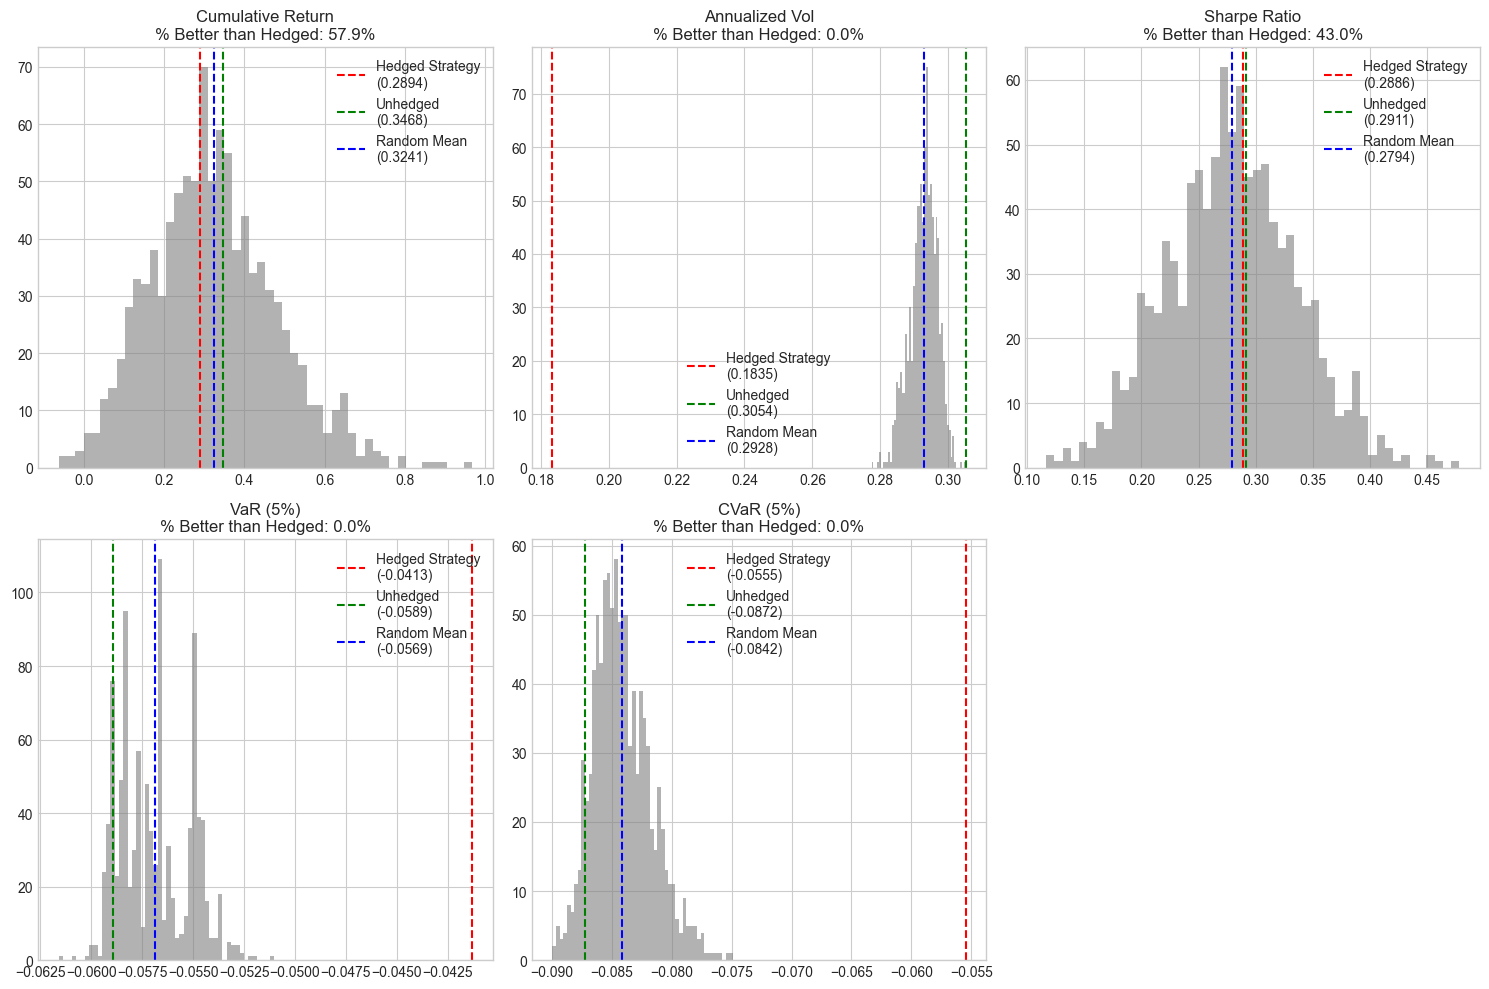


Results for PBW:
Analysis period: 2018-01-01 to 2024-12-31
Number of random portfolios: 1000

Detailed comparison:
           Metric  Hedged Strategy  Unhedged  Random Mean  Random Std  Percentile  % Random Better  P-value
Cumulative Return           0.2839   -0.0821      -0.0665      0.1590         3.0              3.0    0.030
   Annualized Vol           0.2367    0.4214       0.4044      0.0043         0.0              0.0    0.000
     Sharpe Ratio           0.2681    0.1817       0.1730      0.0588         5.5              5.5    0.055
         VaR (5%)          -0.0476   -0.0895      -0.0860      0.0024         0.0              0.0    0.000
        CVaR (5%)          -0.0640   -0.1163      -0.1124      0.0027         0.0              0.0    0.000


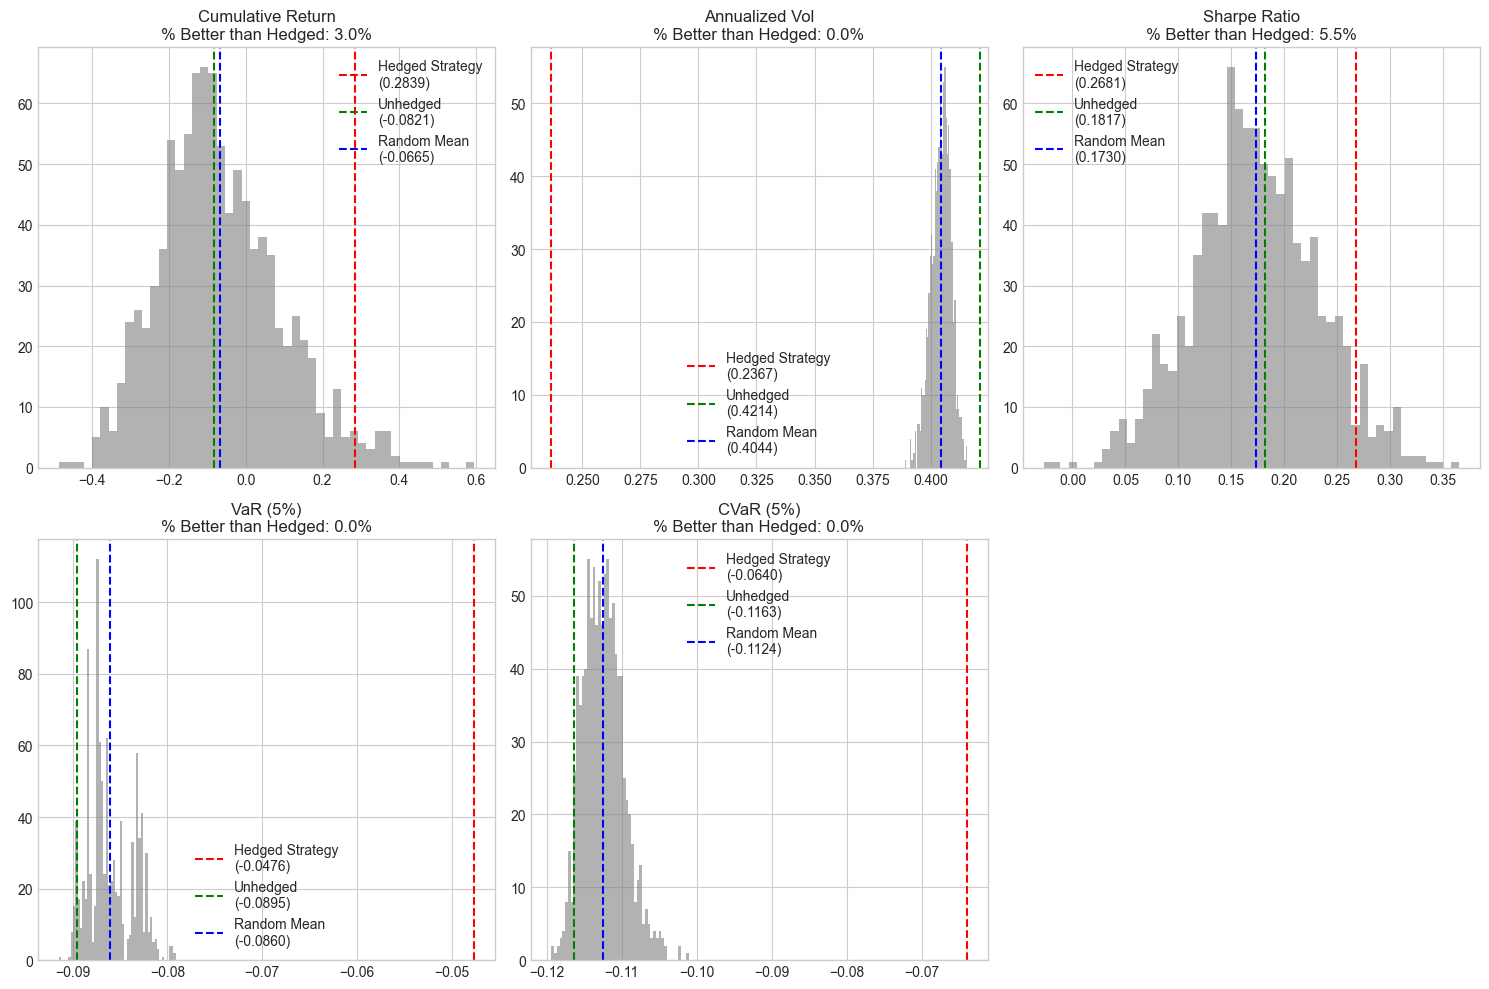


Results for QCLN:
Analysis period: 2018-01-01 to 2024-12-31
Number of random portfolios: 1000

Detailed comparison:
           Metric  Hedged Strategy  Unhedged  Random Mean  Random Std  Percentile  % Random Better  P-value
Cumulative Return           0.6339    0.7465       0.7296      0.2775        59.7             59.7    0.597
   Annualized Vol           0.2156    0.3785       0.3632      0.0042         0.0              0.0    0.000
     Sharpe Ratio           0.4313    0.3980       0.3906      0.0614        25.1             25.1    0.251
         VaR (5%)          -0.0432   -0.0787      -0.0747      0.0020         0.0              0.0    0.000
        CVaR (5%)          -0.0595   -0.1037      -0.1002      0.0026         0.0              0.0    0.000


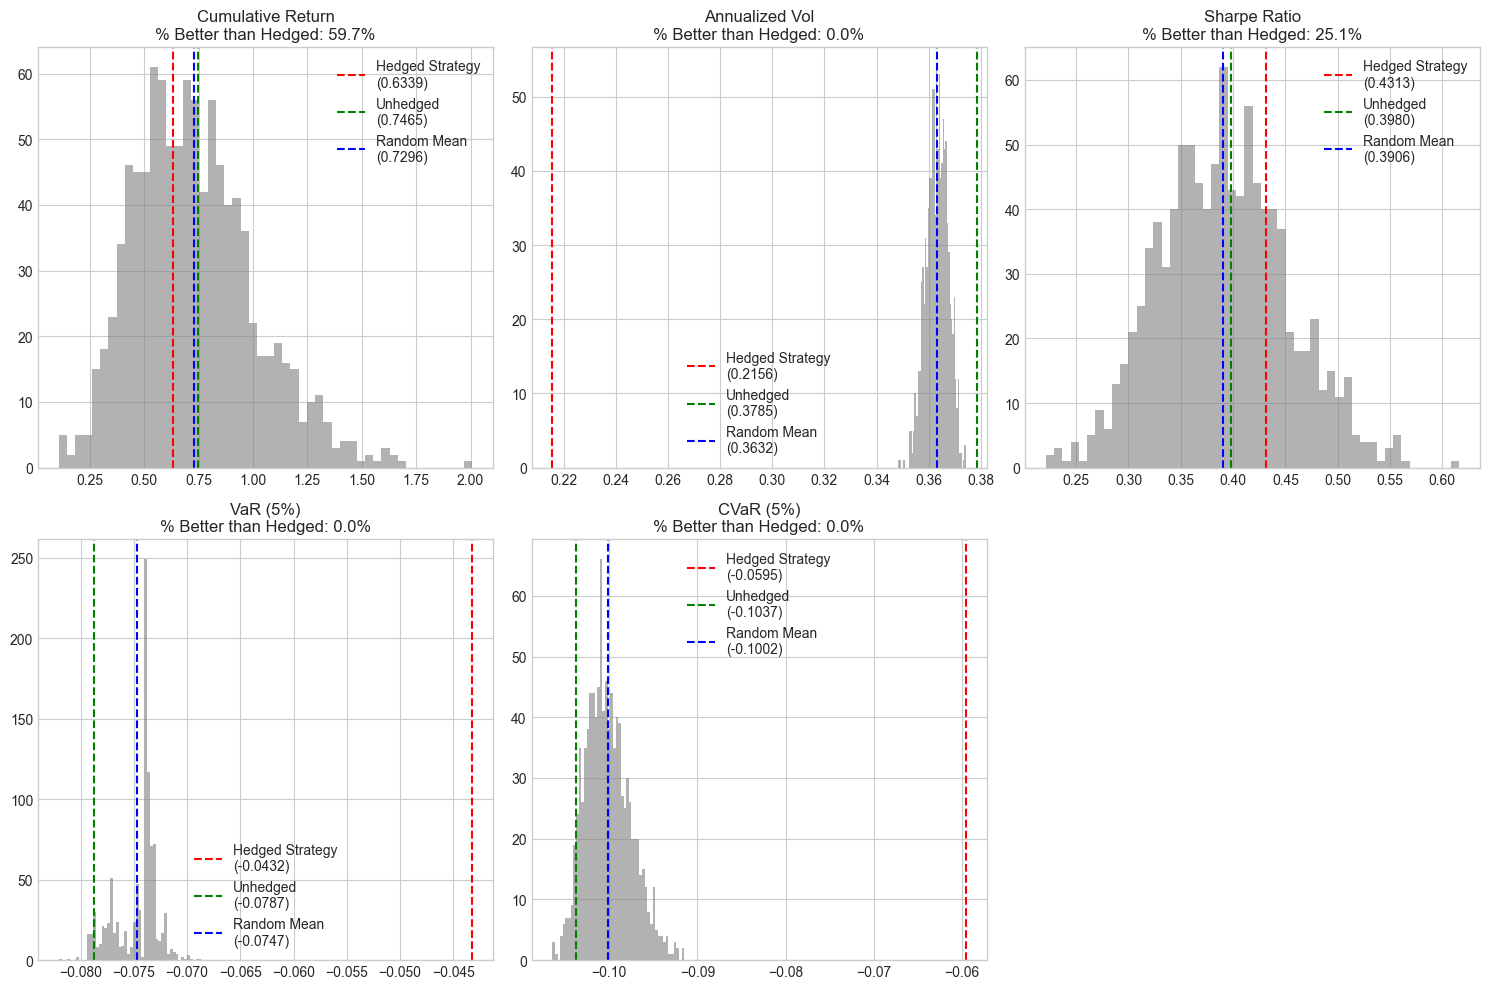

In [529]:
def compare_strategy_to_random(
    ticker: str,
    original_hedged: pd.Series,
    random_portfolios: list[pd.Series],
    unhedged: pd.Series,  # Added unhedged for reference
    start_date: str,
    end_date: str
) -> pd.DataFrame:
    """
    Compare hedged strategy performance against random portfolios.
    P-values represent probability that random portfolios perform better than hedged strategy.
    """
    import numpy as np
    import pandas as pd
    from scipy import stats
    import matplotlib.pyplot as plt
    
    # Filter strategies to test period
    mask = (original_hedged.index >= start_date) & (original_hedged.index <= end_date)
    hedged_test = original_hedged[mask]
    unhedged_test = unhedged[mask]
    
    # Convert to weekly returns
    hedged_weekly = hedged_test.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
    unhedged_weekly = unhedged_test.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
    
    # Compute hedged strategy metrics
    hedged_cum_ret = (1 + hedged_test).cumprod().iloc[-1] - 1
    hedged_vol = hedged_weekly.std() * np.sqrt(52)
    hedged_sharpe = hedged_weekly.mean() / hedged_weekly.std() * np.sqrt(52)
    hedged_var = hedged_weekly.quantile(0.05)
    hedged_cvar = hedged_weekly[hedged_weekly <= hedged_var].mean()
    
    # Containers for random portfolio metrics
    random_metrics = {
        'Cumulative Return': [],
        'Annualized Vol': [],
        'Sharpe Ratio': [],
        'VaR (5%)': [],
        'CVaR (5%)': []
    }
    
    # Compute metrics for each random portfolio
    for rp in random_portfolios:
        # Filter to same date range
        mask = (rp.index >= start_date) & (rp.index <= end_date)
        rp = rp[mask]
        
        # Convert to weekly
        rp_weekly = rp.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
        
        # Compute metrics
        cum_ret = (1 + rp).cumprod().iloc[-1] - 1
        vol = rp_weekly.std() * np.sqrt(52)
        sharpe = rp_weekly.mean() / rp_weekly.std() * np.sqrt(52)
        var = rp_weekly.quantile(0.05)
        cvar = rp_weekly[rp_weekly <= var].mean()
        
        # Store metrics
        random_metrics['Cumulative Return'].append(cum_ret)
        random_metrics['Annualized Vol'].append(vol)
        random_metrics['Sharpe Ratio'].append(sharpe)
        random_metrics['VaR (5%)'].append(var)
        random_metrics['CVaR (5%)'].append(cvar)
    
    # Compare hedged strategy to random portfolios
    results = {
        'Metric': [],
        'Hedged Strategy': [],
        'Unhedged': [],
        'Random Mean': [],
        'Random Std': [],
        'Percentile': [],
        '% Random Better': [],
        'P-value': []
    }
    
    hedged_values = {
        'Cumulative Return': hedged_cum_ret,
        'Annualized Vol': hedged_vol,
        'Sharpe Ratio': hedged_sharpe,
        'VaR (5%)': hedged_var,
        'CVaR (5%)': hedged_cvar
    }
    
    unhedged_values = {
        'Cumulative Return': (1 + unhedged_test).cumprod().iloc[-1] - 1,
        'Annualized Vol': unhedged_weekly.std() * np.sqrt(52),
        'Sharpe Ratio': unhedged_weekly.mean() / unhedged_weekly.std() * np.sqrt(52),
        'VaR (5%)': unhedged_weekly.quantile(0.05),
        'CVaR (5%)': unhedged_weekly[unhedged_weekly <= unhedged_weekly.quantile(0.05)].mean()
    }
    
    for metric in random_metrics.keys():
        random_vals = np.array(random_metrics[metric])
        hedged_val = hedged_values[metric]
        unhedged_val = unhedged_values[metric]
        
        # Handle potential NaN values
        valid_vals = random_vals[~np.isnan(random_vals)]
        if len(valid_vals) == 0:
            print(f"Warning: All NaN values for {metric}")
            continue
            
        # For volatility, VaR, and CVaR, lower is better
        # Only Annualized Vol is "lower is better", all others (including VaR and CVaR) are "higher is better"
        if metric == 'Annualized Vol':
            pct_better = (valid_vals < hedged_val).mean() * 100
            percentile = stats.percentileofscore(valid_vals, hedged_val, kind='weak')
            p_value = (valid_vals < hedged_val).mean()
        else:
            pct_better = (valid_vals > hedged_val).mean() * 100
            percentile = 100 - stats.percentileofscore(valid_vals, hedged_val, kind='weak')
            p_value = (valid_vals > hedged_val).mean()
        
        results['Metric'].append(metric)
        results['Hedged Strategy'].append(hedged_val)
        results['Unhedged'].append(unhedged_val)
        results['Random Mean'].append(valid_vals.mean())
        results['Random Std'].append(valid_vals.std())
        results['Percentile'].append(percentile)
        results['% Random Better'].append(pct_better)
        results['P-value'].append(p_value)
    
    results_df = pd.DataFrame(results)
    
    # Format the DataFrame
    numeric_cols = ['Hedged Strategy', 'Unhedged', 'Random Mean', 
                   'Random Std', 'Percentile', '% Random Better']
    results_df[numeric_cols] = results_df[numeric_cols].round(4)
    
    print(f"\nResults for {ticker}:")
    print(f"Analysis period: {start_date} to {end_date}")
    print(f"Number of random portfolios: {len(random_portfolios)}")
    print("\nDetailed comparison:")
    print(results_df.to_string(index=False))
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(random_metrics.keys(), 1):
        plt.subplot(2, 3, i)
        random_vals = np.array(random_metrics[metric])
        hedged_val = hedged_values[metric]
        unhedged_val = unhedged_values[metric]
        
        # Handle potential NaN values
        valid_vals = random_vals[~np.isnan(random_vals)]
        if len(valid_vals) == 0:
            continue
            
        plt.hist(valid_vals, bins=50, alpha=0.6, color='gray')
        plt.axvline(hedged_val, color='red', linestyle='--', 
                   label=f'Hedged Strategy\n({hedged_val:.4f})')
        plt.axvline(unhedged_val, color='green', linestyle='--', 
                   label=f'Unhedged\n({unhedged_val:.4f})')
        plt.axvline(np.mean(valid_vals), color='blue', linestyle='--', 
                   label=f'Random Mean\n({np.mean(valid_vals):.4f})')
        
        plt.title(f'{metric}\n% Better than Hedged: {results_df.loc[results_df["Metric"] == metric, "% Random Better"].iloc[0]:.1f}%')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Use the function for each ticker
comparison_results = {}
for ticker in ["ICLN", "PBW", "QCLN"]:
    comparison_results[ticker] = compare_strategy_to_random(
        ticker=ticker,
        original_hedged=original_hedged[ticker],
        random_portfolios=random_portfolios[ticker],
        unhedged=renewable_df[ticker],
        start_date=start_date,
        end_date=end_date
    )

In [515]:
strategy_stats

Ticker  Strategy  Final Return  Annualized Vol  Sharpe Ratio
0   ICLN  Original        0.2894          0.1835        0.2886
1   ICLN  Unhedged        0.3468          0.3054        0.2911
0    PBW  Original        0.2839          0.2367        0.2681
1    PBW  Unhedged       -0.0821          0.4214        0.1817
0   QCLN  Original        0.6339          0.2156        0.4313
1   QCLN  Unhedged        0.7465          0.3785        0.3980

In [516]:
random_stats

Ticker  Final Return (mean)  Final Return (std)  Annualized Vol (mean)  \
0   ICLN               0.2687              0.1106                 0.2936   
0    PBW              -0.0921              0.1479                 0.4050   
0   QCLN               0.4142              0.1294                 0.3628   

   Annualized Vol (std)  Sharpe Ratio (mean)  Sharpe Ratio (std)  
0                0.0041               0.2602              0.0429  
0                0.0048               0.1635              0.0610  
0                0.0027               0.3154              0.0370

In [513]:
random_final_rets

[0.4930804357926655,
 0.13535848954833107,
 0.2525068084712807,
 0.9140295449031823,
 0.5444251779760321,
 0.6874226773497889,
 0.6748914113412878,
 1.5999372643238208,
 0.6906296073905966,
 0.36744211564424023,
 0.5587014408692017,
 0.9779252334981816,
 0.3834738763095433,
 1.1244788578044433,
 0.521795263513837,
 0.5233910771494594,
 0.4081095934850072,
 0.7711834410313312,
 0.05400277553303057,
 0.715991155380866,
 0.4408014574264467,
 0.5853052642023644,
 0.6331877221286062,
 0.960500406425634,
 0.7147765054711357,
 0.5313681836659354,
 1.1584251698549064,
 0.4724592241966339,
 0.570710376789296,
 0.5688001010319998,
 0.7764189412879046,
 0.6899561915733425,
 0.9039677750691659,
 0.9845255545750882,
 0.48252146184842104,
 0.6617139102112186,
 0.6280523414712724,
 0.7055302535646706,
 0.7247153197065574,
 0.589401214010147,
 0.3117754470775378,
 0.865331421515039,
 0.8381517712094575,
 0.4079262646276991,
 0.8310221571509255,
 0.6226824226300951,
 0.6916516292798582,
 0.267377378705

# old code


In [ ]:
def compute_garch_volatility(renewable_df,
                           etf_name,
                           rolling_window=500,
                           forecast_horizon=22,
                           start_date="2008",
                           end_date="2019"):
    """
    Compute GARCH volatility forecasts for a single ETF.

    Parameters:
    -----------
    renewable_df : pandas.DataFrame
        DataFrame containing ETF returns
    etf_name : str
        Name of the ETF to analyze
    rolling_window : int
        Window size for GARCH estimation
    forecast_horizon : int
        Number of days to forecast volatility
    start_date : str
        Start date for analysis
    end_date : str
        End date for analysis

    Returns:
    --------
    dict
        Dictionary containing volatility forecasts and parameters
    """
    # Ensure datetime index
    renewable_df.index = pd.to_datetime(renewable_df.index)
    renewable_subset = renewable_df.loc[start_date:end_date]

    print(f"Computing GARCH volatility for {etf_name}...")
    returns = renewable_subset[etf_name].dropna() * 100
    forecast_vols = []

    # Fit GARCH model and forecast volatility
    for i in range(rolling_window, len(returns) - forecast_horizon):
        window = returns.iloc[i - rolling_window:i]
        model = arch_model(window, vol='Garch', p=1, q=1)
        try:
            res = model.fit(disp="off")
            forecast = res.forecast(horizon=forecast_horizon)
            avg_vol = np.mean(np.sqrt(forecast.variance.values[-1]) / 100)
            forecast_vols.append(avg_vol)
        except:
            forecast_vols.append(np.nan)

    # Create volatility signal
    valid_index = returns.index[rolling_window:-forecast_horizon]
    vol_signal = pd.Series(forecast_vols, index=valid_index)

    print(f"Finished computing GARCH volatility for {etf_name}")
    return {
        'etf_name': etf_name,
        'volatility_signal': vol_signal,
        'raw_returns': returns.loc[valid_index] / 100,
        'parameters': {
            'rolling_window': rolling_window,
            'forecast_horizon': forecast_horizon,
            'start_date': start_date,
            'end_date': end_date
        }
    }

def apply_hedging_strategy(garch_results,
                          de_risk_pct=0.5,
                          percentile_threshold=0.9):
    """
    Apply hedging strategy based on GARCH volatility forecasts.

    Parameters:
    -----------
    garch_results : dict
        Results from compute_garch_volatility function
    de_risk_pct : float
        Percentage to de-risk when volatility is high
    percentile_threshold : float
        Percentile threshold for volatility (0-1)

    Returns:
    --------
    dict
        Dictionary containing hedging results and metrics
    """
    etf_name = garch_results['etf_name']
    vol_signal = garch_results['volatility_signal']
    raw_returns = garch_results['raw_returns']

    print(f"Applying hedging strategy for {etf_name}...")

    # Determine threshold
    threshold = vol_signal.quantile(percentile_threshold)

    # Apply hedging strategy
    hedged = raw_returns.copy()
    decisions = []
    hedge_trigger_dates = pd.DataFrame(columns=['ETF', 'Date', 'Volatility', 'Threshold'])

    for date in vol_signal.index:
        vol = vol_signal.loc[date]
        if vol > threshold:
            decision = f"{date.date()}: De-risked (Vol={vol:.4f} > {threshold:.4f})"
            hedged.loc[date] *= (1 - de_risk_pct)
            # Add to hedge trigger dates DataFrame
            hedge_trigger_dates = pd.concat([hedge_trigger_dates, pd.DataFrame({
                'ETF': [etf_name],
                'Date': [date],
                'Volatility': [vol],
                'Threshold': [threshold]
            })], ignore_index=True)
        else:
            decision = f"{date.date()}: Full exposure (Vol={vol:.4f} <= {threshold:.4f})"
        decisions.append(decision)

    # Create DataFrame of hedged returns
    hedged_returns = pd.DataFrame({
        'raw_returns': raw_returns,
        'hedged_returns': hedged
    })

    # Sort hedge trigger dates by date
    hedge_trigger_dates = hedge_trigger_dates.sort_values('Date')

    print(f"Finished applying hedging strategy for {etf_name}")
    return {
        'etf_name': etf_name,
        'hedged_returns': hedged_returns,
        'hedge_log': decisions,
        'hedge_trigger_dates': hedge_trigger_dates,
        'volatility_signal': vol_signal,
        'threshold': threshold,
        'parameters': {
            **garch_results['parameters'],
            'de_risk_pct': de_risk_pct,
            'percentile_threshold': percentile_threshold
        }
    }

In [ ]:
# Compute GARCH volatilities
# ICLN
garch_vol_ICLN = compute_garch_volatility(
     renewable_df=renewable_df,
     etf_name='ICLN',
     rolling_window=500,
     forecast_horizon=22,
     start_date='2008-01-01',
     end_date='2019-12-31'
)
# PBW
garch_vol_PBW = compute_garch_volatility(
     renewable_df=renewable_df,
     etf_name='PBW',
     rolling_window=500,
     forecast_horizon=22,
     start_date='2008-01-01',
     end_date='2019-12-31'
)
# QCLN
garch_vol_QCLN = compute_garch_volatility(
     renewable_df=renewable_df,
     etf_name='QCLN',
     rolling_window=500,
     forecast_horizon=22,
     start_date='2008-01-01',
     end_date='2019-12-31'
)

Computing GARCH volatility for ICLN...
Finished computing GARCH volatility for ICLN
Computing GARCH volatility for PBW...
Finished computing GARCH volatility for PBW
Computing GARCH volatility for QCLN...
Finished computing GARCH volatility for QCLN


In [ ]:
# Perform hedge strategies with 50% derisk and 90% threshold
garch_hedge_ICLN = apply_hedging_strategy(
     garch_results=garch_vol_ICLN,
     de_risk_pct=0.5,
     percentile_threshold=0.9
)

garch_hedge_PBW = apply_hedging_strategy(
     garch_results=garch_vol_PBW,
     de_risk_pct=0.5,
     percentile_threshold=0.9
)

garch_hedge_QCLN = apply_hedging_strategy(
     garch_results=garch_vol_QCLN,
     de_risk_pct=0.5,
     percentile_threshold=0.9
)

Applying hedging strategy for ICLN...
Finished applying hedging strategy for ICLN
Applying hedging strategy for PBW...
Finished applying hedging strategy for PBW
Applying hedging strategy for QCLN...
Finished applying hedging strategy for QCLN


In [ ]:
def plot_cumulative_returns(returns_df,
                          etf_name,
                          start_date=None,
                          end_date=None,
                          figsize=(12, 6),
                          linewidth=2,
                          alpha=0.8):
    """
    Plot cumulative returns for raw and hedged strategies.

    Parameters:
    -----------
    returns_df : pandas.DataFrame
        DataFrame with 'raw_returns' and 'hedged_returns' columns
    etf_name : str
        Name of the ETF for the plot title
    start_date : str, optional
        Start date for the plot (format: 'YYYY-MM-DD')
    end_date : str, optional
        End date for the plot (format: 'YYYY-MM-DD')
    figsize : tuple
        Figure size (width, height)
    linewidth : float
        Width of the lines
    alpha : float
        Transparency of the lines
    """
    # Filter by date range if provided
    if start_date:
        returns_df = returns_df.loc[start_date:]
    if end_date:
        returns_df = returns_df.loc[:end_date]

    # Calculate cumulative returns
    cum_raw = (1 + returns_df['raw_returns']).cumprod()
    cum_hedged = (1 + returns_df['hedged_returns']).cumprod()

    # Create the plot
    plt.figure(figsize=figsize)

    # Plot the lines
    plt.plot(cum_raw.index, cum_raw,
             label='Raw Returns',
             linewidth=linewidth,
             color='blue')

    plt.plot(cum_hedged.index, cum_hedged,
             label='Hedged Returns',
             linewidth=linewidth,
             alpha=alpha,
             color='red')

    # Add title and labels
    plt.title(f'{etf_name}: Cumulative Returns\n{returns_df.index[0].strftime("%Y-%m-%d")} to {returns_df.index[-1].strftime("%Y-%m-%d")}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Growth of $1)')

    # Add legend and grid
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    # Format x-axis dates
    plt.gcf().autofmt_xdate()

    # Add final values as text annotations
    final_raw = cum_raw.iloc[-1]
    final_hedged = cum_hedged.iloc[-1]

    plt.annotate(f'Final: {final_raw:.2f}x',
                xy=(cum_raw.index[-1], final_raw),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round', facecolor='blue', alpha=0.1))

    plt.annotate(f'Final: {final_hedged:.2f}x',
                xy=(cum_hedged.index[-1], final_hedged),
                xytext=(10, -10), textcoords='offset points',
                bbox=dict(boxstyle='round', facecolor='red', alpha=0.1))

    # Add some statistics as text
    stats_text = f"""
    Raw Returns Stats:
    Final Return: {final_raw:.2f}x
    Max Drawdown: {((cum_raw.cummax() - cum_raw) / cum_raw.cummax()).max():.2%}

    Hedged Returns Stats:
    Final Return: {final_hedged:.2f}x
    Max Drawdown: {((cum_hedged.cummax() - cum_hedged) / cum_hedged.cummax()).max():.2%}
    """

    # Add text box with statistics
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Return the statistics
    return {
        'raw_stats': {
            'final_return': final_raw,
            'max_drawdown': ((cum_raw.cummax() - cum_raw) / cum_raw.cummax()).max()
        },
        'hedged_stats': {
            'final_return': final_hedged,
            'max_drawdown': ((cum_hedged.cummax() - cum_hedged) / cum_hedged.cummax()).max()
        }
    }


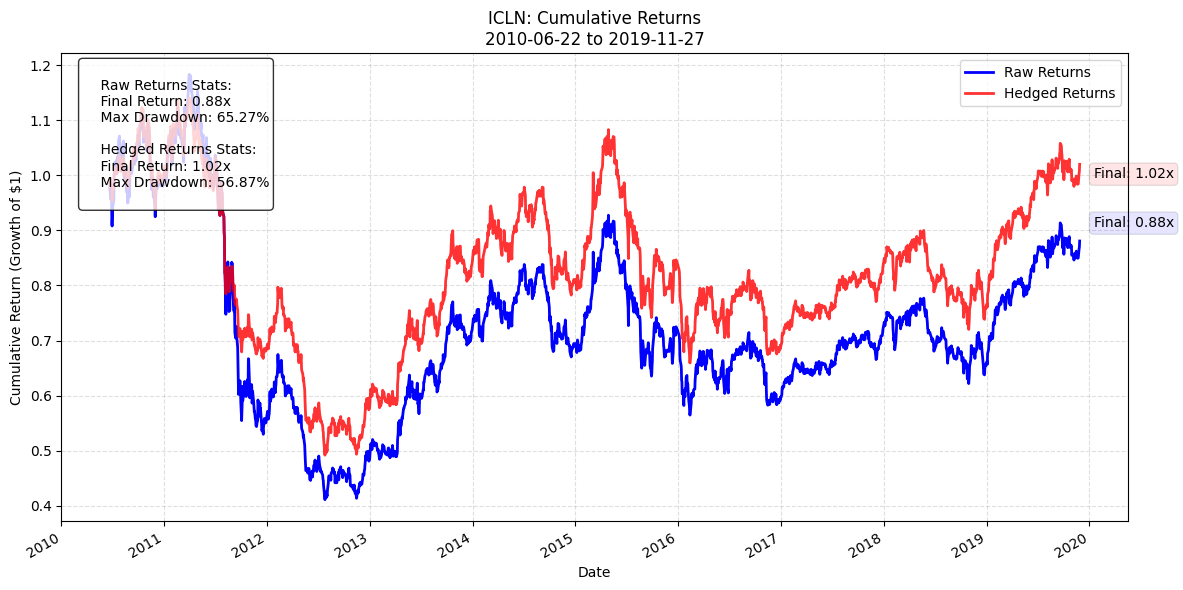

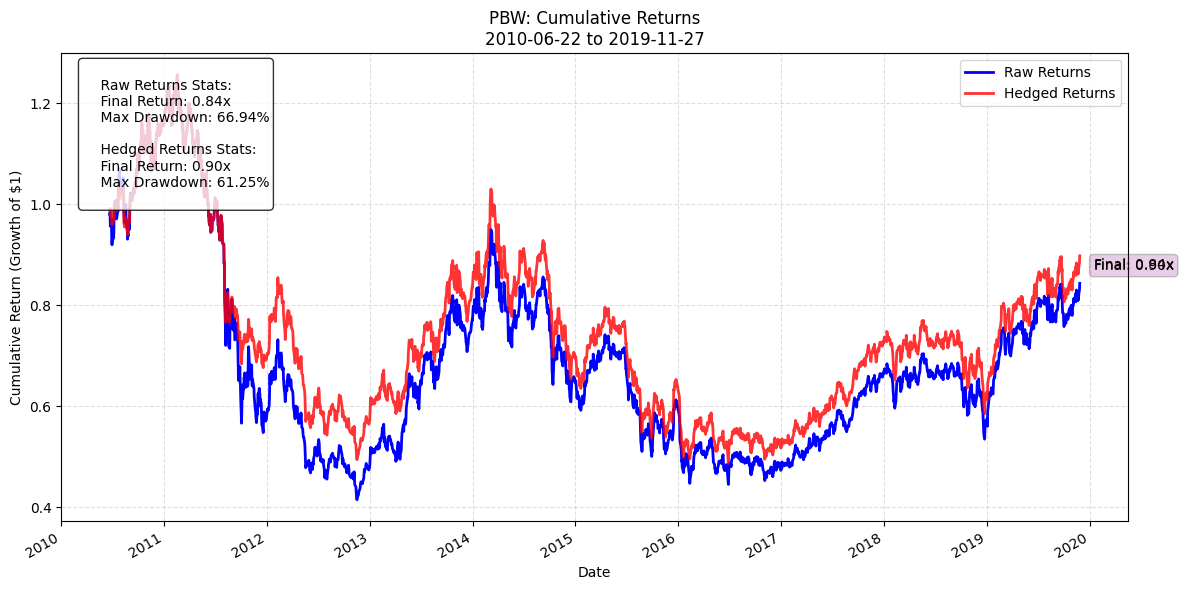

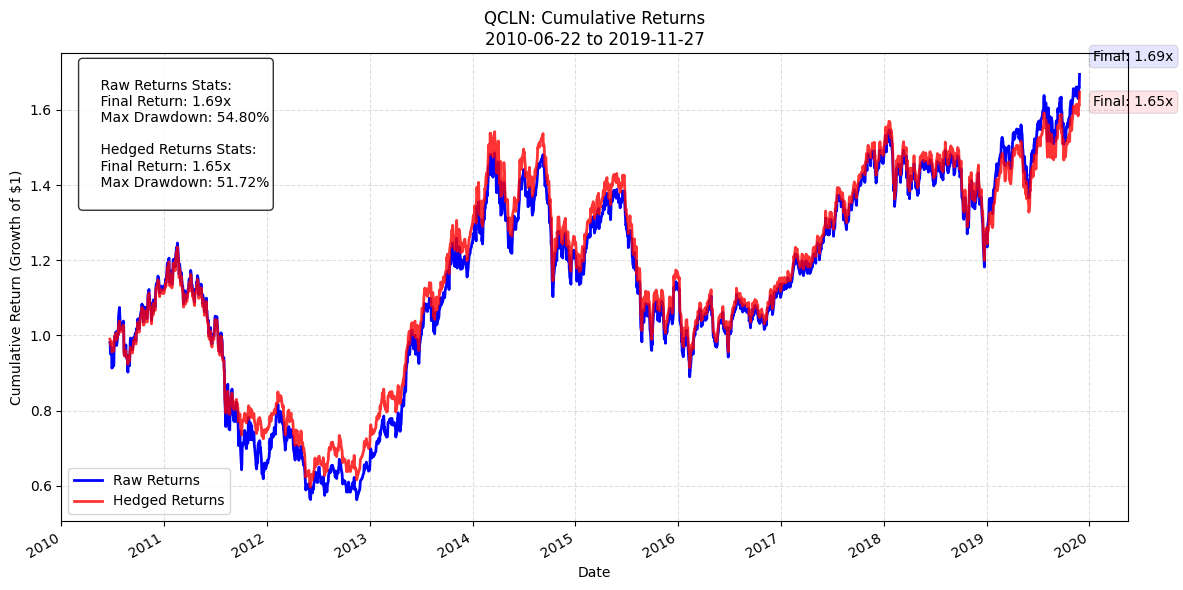

{'raw_stats': {'final_return': np.float64(1.6942908731104076),
  'max_drawdown': 0.5480178345644655},
 'hedged_stats': {'final_return': np.float64(1.6467953906668724),
  'max_drawdown': 0.517240033686768}}

In [ ]:
# Example usage:
plot_cumulative_returns(
    returns_df= garch_hedge_ICLN['hedged_returns'],
    etf_name='ICLN',
     start_date='2008-01-01',
     end_date='2019-12-31'
)
# Example usage:
plot_cumulative_returns(
    returns_df= garch_hedge_PBW['hedged_returns'],
    etf_name='PBW',
     start_date='2008-01-01',
     end_date='2019-12-31'
)
# Example usage:
plot_cumulative_returns(
    returns_df= garch_hedge_QCLN['hedged_returns'],
    etf_name='QCLN',
     start_date='2008-01-01',
     end_date='2019-12-31'
)

In [ ]:
def risk_metrics(returns):
    """
    Calculate risk metrics for a returns series.

    Parameters:
    -----------
    returns : array-like
        Array or Series of returns

    Returns:
    --------
    dict
        Dictionary of risk metrics
    """
    # Convert to pandas Series if it's not already
    if not isinstance(returns, pd.Series):
        returns = pd.Series(returns)

    # Calculate metrics
    var = returns.quantile(0.05)
    cvar = returns[returns <= var].mean()
    mdd = (returns.cummax() - returns).max()

    # Return metrics dictionary
    return {
        "VaR (95%)": round(var, 4),
        "CVaR (95%)": round(cvar, 4),
        "Max Drawdown": round(mdd, 4)
    }

In [ ]:
# Function to compare unhedged and hedged metrics
def compare_risk_metrics(returns_df):
    """
    Compare risk metrics between unhedged and hedged returns.

    Parameters:
    -----------
    returns_df : pandas.DataFrame
        DataFrame with 'raw_returns' and 'hedged_returns' columns

    Returns:
    --------
    pandas.DataFrame
        Comparison table of risk metrics
    """
    # Calculate metrics for both strategies
    unhedged_metrics = risk_metrics(returns_df['raw_returns'])
    hedged_metrics = risk_metrics(returns_df['hedged_returns'])

    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'Unhedged': unhedged_metrics,
        'Hedged': hedged_metrics
    })

    # Calculate percent changes
    percent_changes = ((comparison['Hedged'] - comparison['Unhedged']) /
                      comparison['Unhedged'] * 100).round(2)
    comparison['Change (%)'] = percent_changes

    return comparison

In [ ]:
compare_risk_metrics(garch_hedge_ICLN['hedged_returns'])

Unhedged  Hedged  Change (%)
VaR (95%)      -0.0244 -0.0217    -11.0700
CVaR (95%)     -0.0344 -0.0296    -13.9500
Max Drawdown    0.1425  0.1222    -14.2500

In [ ]:
compare_risk_metrics(garch_hedge_PBW['hedged_returns'])

Unhedged  Hedged  Change (%)
VaR (95%)      -0.0278 -0.0255     -8.2700
CVaR (95%)     -0.0378 -0.0337    -10.8500
Max Drawdown    0.1639  0.1286    -21.5400

In [ ]:
compare_risk_metrics(garch_hedge_QCLN['hedged_returns'])

Unhedged  Hedged  Change (%)
VaR (95%)      -0.0275 -0.0252     -8.3600
CVaR (95%)     -0.0368 -0.0332     -9.7800
Max Drawdown    0.1291  0.1125    -12.8600

# Old: Attempts at Hidden Markov Model on Realized Volatilities

### 2-state Gaussigan HMM

In [ ]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.0 MB/s eta 0:00:00


State 0: mean vol = 0.0161,   std vol = 0.0046
State 1: mean vol = 0.0384,   std vol = 0.0154


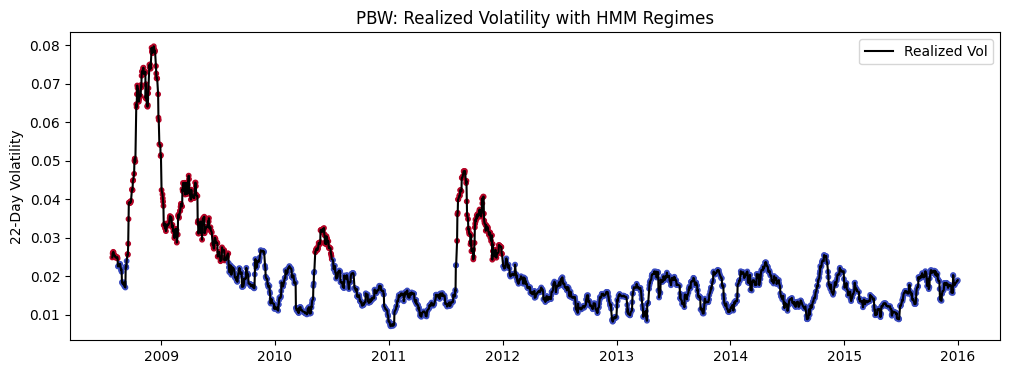

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# 1) Prepare your realized volatility series
#    Use your daily PBW returns (decimal) to compute a 22‑day rolling std
ticker = 'PBW'
ret = renewable_df[ticker].loc['2008':'2015'].dropna()
realized_vol = ret.rolling(window=22).std().dropna()

# 2) Reshape for HMM (n_samples, n_features)
X = realized_vol.values.reshape(-1, 1)

# 3) Fit a 2‑state Gaussian HMM
model = GaussianHMM(n_components=2, covariance_type='full', n_iter=100, random_state=42)
model.fit(X)

# 4) Decode the most likely state sequence
states = model.predict(X)
state_series = pd.Series(states, index=realized_vol.index)

# 5) Inspect the regimes
for i in [0,1]:
    mu = model.means_[i][0]
    sigma = np.sqrt(model.covars_[i][0][0])
    print(f"State {i}: mean vol = {mu:.4f},   std vol = {sigma:.4f}")

# 6) Plot realized vol colored by regime
plt.figure(figsize=(12,4))
plt.plot(realized_vol.index, realized_vol, label='Realized Vol', color='black')
plt.scatter(realized_vol.index, realized_vol, c=states, cmap='coolwarm', s=10)
plt.title(f"{ticker}: Realized Volatility with HMM Regimes")
plt.ylabel("22‑Day Volatility")
plt.legend()
plt.show()

### 3-state Gaussian HMM

Regime means & std devs:
 State 0: mean = 0.0164,  std = 0.0054
 State 1: mean = 0.0164,  std = 0.0054
 State 2: mean = 0.0400,  std = 0.0155


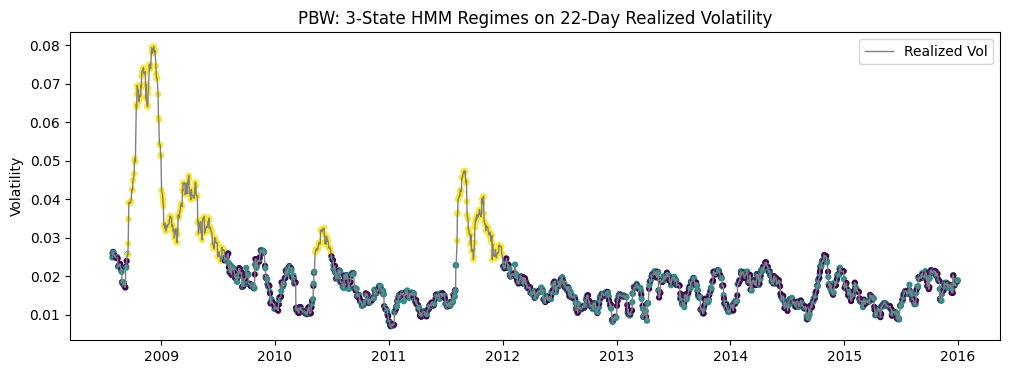

In [ ]:
# 1) Compute 22‑day realized volatility for PBW (2008–2019)
ticker = 'PBW'
ret = renewable_df[ticker].loc['2008':'2015'].dropna()
realized_vol = ret.rolling(window=22).std().dropna()

# 2) Reshape for HMM
X = realized_vol.values.reshape(-1, 1)

# 3) Fit a 3‑state Gaussian HMM
model3 = GaussianHMM(
    n_components=3,
    covariance_type='full',
    n_iter=200,
    random_state=42
)
model3.fit(X)

# 4) Decode the most likely state sequencea
states3 = model3.predict(X)
state_series3 = pd.Series(states3, index=realized_vol.index)

# 5) Inspect each regime’s volatility characteristics
print("Regime means & std devs:")
for i in range(3):
    mu    = model3.means_[i][0]
    sigma = np.sqrt(model3.covars_[i][0][0])
    print(f" State {i}: mean = {mu:.4f},  std = {sigma:.4f}")

# 6) Plot realized vol colored by regime
plt.figure(figsize=(12,4))
plt.plot(realized_vol.index, realized_vol, color='grey', linewidth=1, label='Realized Vol')
plt.scatter(realized_vol.index, realized_vol, c=states3, cmap='viridis', s=12)
plt.title(f"{ticker}: 3‑State HMM Regimes on 22‑Day Realized Volatility")
plt.ylabel("Volatility")
plt.legend()
plt.show()

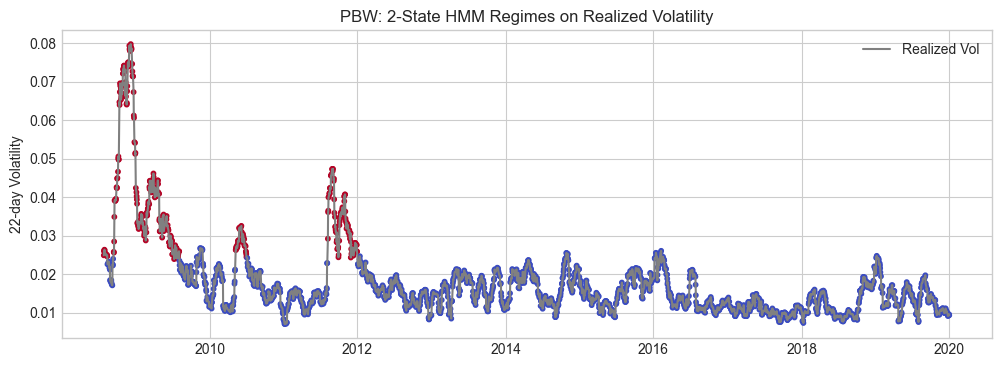

Original    Hedged
VaR (95%)    -0.021407 -0.021407
CVaR (95%)   -0.029896 -0.029896
Max Drawdown  0.100232  0.100232

In [12]:
# Fit both models on the 2008-2015 train set.
# Validate on 2016–2018:


# Try to import hmmlearn, else instruct user to install
try:
    from hmmlearn.hmm import GaussianHMM
except ImportError as e:
    raise ImportError("hmmlearn not installed. Install via 'pip install hmmlearn' to use HMM functionality.") from e

# Parameters
ticker = 'PBW'
start_train = '2008-01-01'
end_train = '2015-12-31'
end_full = '2019-12-31'
forecast_horizon = 22
de_risk_pct = 0.5  # 50% reduction in exposure in high-vol state

# Ensure datetime index
returns_df = renewable_df.copy()
returns_df.index = pd.to_datetime(returns_df.index)

# 1) Compute 22-day realized volatility series
ret_full = returns_df[ticker].loc['2008':end_full].dropna()
realized_vol_full = ret_full.rolling(window=forecast_horizon).std().dropna()

# 2) Split realized volatility into train and test
rv_train = realized_vol_full.loc[start_train:end_train]
rv_test = realized_vol_full.loc['2016-01-01':end_full]

# 3) Fit 2-state Gaussian HMM on training data
X_train = rv_train.values.reshape(-1, 1)
model_hmm = GaussianHMM(n_components=2, covariance_type='full', n_iter=200, random_state=42)
model_hmm.fit(X_train)

# Identify high-vol state (state with higher mean)
means = model_hmm.means_.flatten()
high_vol_state = np.argmax(means)

# 4) Decode states for full period
X_full = realized_vol_full.values.reshape(-1, 1)
states_full = model_hmm.predict(X_full)
state_series = pd.Series(states_full, index=realized_vol_full.index, name='Regime')

# 5) Plot realized volatility with regimes
plt.figure(figsize=(12,4))
plt.plot(realized_vol_full.index, realized_vol_full, color='grey', label='Realized Vol')
plt.scatter(realized_vol_full.index, realized_vol_full, c=states_full, cmap='coolwarm', s=10)
plt.title(f"{ticker}: 2-State HMM Regimes on Realized Volatility")
plt.ylabel("22-day Volatility")
plt.legend()
plt.show()

# 6) Construct hedged returns: reduce exposure when in high-vol state
raw_returns = ret_full.loc[state_series.index]  # align dates
hedged_returns = raw_returns.copy()
hedged_returns[state_series == high_vol_state] *= (1 - de_risk_pct)

# 7) Evaluate risk metrics on test period
def compute_metrics(returns):
    var = returns.quantile(0.05)
    cvar = returns[returns <= var].mean()
    mdd = (returns.cummax() - returns).max()
    return var, cvar, mdd

# Align test returns
test_returns = raw_returns.loc[rv_test.index]
test_hedged = hedged_returns.loc[rv_test.index]

metrics_orig = compute_metrics(test_returns)
metrics_hedged = compute_metrics(test_hedged)

# Display metrics
metrics_df = pd.DataFrame({
    'Original': metrics_orig,
    'Hedged': metrics_hedged
}, index=['VaR (95%)','CVaR (95%)','Max Drawdown'])

metrics_df


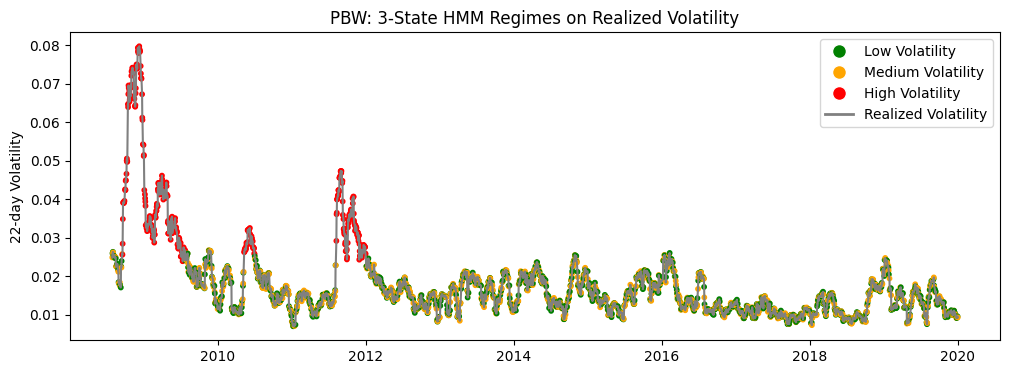

State Means (Low to High Volatility):
Low Volatility State: 0.0164
Medium Volatility State: 0.0164
High Volatility State: 0.0400

Risk Metrics Comparison:


Original  Hedged
VaR (95%)      -0.0214 -0.0197
CVaR (95%)     -0.0299 -0.0267
Max Drawdown    0.1002  0.1002

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Try to import hmmlearn, else instruct user to install
try:
    from hmmlearn.hmm import GaussianHMM
except ImportError as e:
    raise ImportError("hmmlearn not installed. Install via 'pip install hmmlearn' to use HMM functionality.") from e

# Parameters
ticker = 'PBW'
start_train = '2008-01-01'
end_train = '2015-12-31'
end_full = '2019-12-31'
forecast_horizon = 22

# De-risking percentages for each state
de_risk_high = 0.50  # 50% reduction in high volatility state
de_risk_medium = 0.25  # 25% reduction in medium volatility state
de_risk_low = 0.00  # 0% reduction in low volatility state

# Ensure datetime index
returns_df = renewable_df.copy()
returns_df.index = pd.to_datetime(returns_df.index)

# 1) Compute 22-day realized volatility series
ret_full = returns_df[ticker].loc['2008':end_full].dropna()
realized_vol_full = ret_full.rolling(window=forecast_horizon).std().dropna()

# 2) Split realized volatility into train and test
rv_train = realized_vol_full.loc[start_train:end_train]
rv_test = realized_vol_full.loc['2016-01-01':end_full]

# 3) Fit 3-state Gaussian HMM on training data
X_train = rv_train.values.reshape(-1, 1)
model_hmm = GaussianHMM(n_components=3, covariance_type='full', n_iter=200, random_state=42)
model_hmm.fit(X_train)

# Identify states by their mean volatility (low to high)
means = model_hmm.means_.flatten()
sorted_states = np.argsort(means)  # States ordered from low to high volatility
low_vol_state = sorted_states[0]
medium_vol_state = sorted_states[1]
high_vol_state = sorted_states[2]

# 4) Decode states for full period
X_full = realized_vol_full.values.reshape(-1, 1)
states_full = model_hmm.predict(X_full)
state_series = pd.Series(states_full, index=realized_vol_full.index, name='Regime')

# 5) Plot realized volatility with regimes
# 5) Plot realized volatility with regimes
plt.figure(figsize=(12,4))
plt.plot(realized_vol_full.index, realized_vol_full, color='grey', label='Realized Vol')

# Create a custom colormap for the three states
colors = ['green', 'orange', 'red']  # Low, Medium, High volatility
state_colors = [colors[state] for state in states_full]

# Plot the scatter points with custom colors
scatter = plt.scatter(realized_vol_full.index, realized_vol_full,
                     c=state_colors, s=10)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Low Volatility'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Medium Volatility'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Volatility'),
    Line2D([0], [0], color='grey', lw=2, label='Realized Volatility')
]

plt.title(f"{ticker}: 3-State HMM Regimes on Realized Volatility")
plt.ylabel("22-day Volatility")
plt.legend(handles=legend_elements)
plt.show()

# 6) Construct hedged returns with state-dependent de-risking
raw_returns = ret_full.loc[state_series.index]  # align dates
hedged_returns = raw_returns.copy()

# Apply different de-risking based on state
hedged_returns[state_series == high_vol_state] *= (1 - de_risk_high)
hedged_returns[state_series == medium_vol_state] *= (1 - de_risk_medium)
hedged_returns[state_series == low_vol_state] *= (1 - de_risk_low)

# 7) Evaluate risk metrics on test period
def compute_metrics(returns):
    var = returns.quantile(0.05)
    cvar = returns[returns <= var].mean()
    mdd = (returns.cummax() - returns).max()
    return var, cvar, mdd

# Align test returns
test_returns = raw_returns.loc[rv_test.index]
test_hedged = hedged_returns.loc[rv_test.index]

metrics_orig = compute_metrics(test_returns)
metrics_hedged = compute_metrics(test_hedged)

# Display metrics
metrics_df = pd.DataFrame({
    'Original': metrics_orig,
    'Hedged': metrics_hedged
}, index=['VaR (95%)','CVaR (95%)','Max Drawdown'])

print("State Means (Low to High Volatility):")
print(f"Low Volatility State: {means[low_vol_state]:.4f}")
print(f"Medium Volatility State: {means[medium_vol_state]:.4f}")
print(f"High Volatility State: {means[high_vol_state]:.4f}")

print("\nRisk Metrics Comparison:")
metrics_df

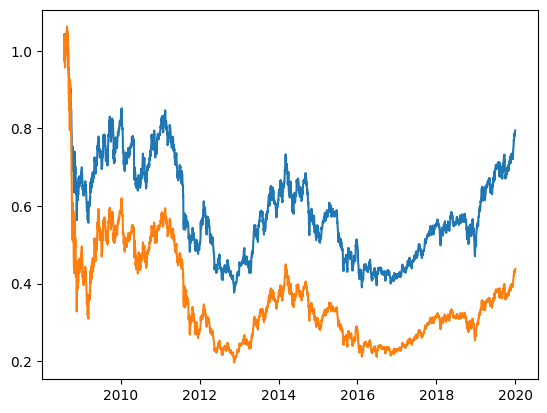

In [ ]:
plt.plot((1 + hedged_returns).cumprod())
plt.plot((1 + raw_returns).cumprod())

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# Parameters
ticker = 'QCLN'
start_train = '2010-01-01'
end_train = '2016-12-31'
start_test = '2019-01-01'
end_full = '2024-12-31'
forecast_horizon = 22

# Ensure datetime index
returns_df = renewable_df.copy()
returns_df.index = pd.to_datetime(returns_df.index)

# 1) Compute 22-day realized volatility series
ret_full = returns_df[ticker].loc[start_train:end_full].dropna()
realized_vol_full = ret_full.rolling(window=forecast_horizon).std().dropna()


# Get rolling HMM states
states_series = rolling_hmm_states(realized_vol_full, window=750, n_states=3)


# Get state means and identify high/medium/low states
sorted_states = get_state_means(realized_vol_full, states_series)
low_vol_state = sorted_states[0]
medium_vol_state = sorted_states[1]
high_vol_state = sorted_states[2]

NameError: name 'rolling_hmm_states' is not defined

In [ ]:
# De-risking percentages for each state
de_risk_high = 0.50  # 50% reduction in high volatility state
de_risk_medium = 0.25  # 25% reduction in medium volatility state
de_risk_low = 0.00  # 0% reduction in low volatility state

# Construct hedged returns with state-dependent de-risking
raw_returns = ret_full.loc[states_series.index]  # align dates
hedged_returns = raw_returns.copy()

# Apply different de-risking based on state
hedged_returns[states_series == high_vol_state] *= (1 - de_risk_high)
hedged_returns[states_series == medium_vol_state] *= (1 - de_risk_medium)
hedged_returns[states_series == low_vol_state] *= (1 - de_risk_low)

# Evaluate risk metrics on test period
def compute_metrics(returns):
    var = returns.quantile(0.05)
    cvar = returns[returns <= var].mean()
    mdd = (returns.cummax() - returns).max()
    return var, cvar, mdd

# Align test returns
test_returns = raw_returns.loc[start_test:end_full]
test_hedged = hedged_returns.loc[start_test:end_full]


metrics_orig = compute_metrics(test_returns)
metrics_hedged = compute_metrics(test_hedged)


# Display metrics
metrics_df = pd.DataFrame({
    'Original': metrics_orig,
    'Hedged': metrics_hedged
}, index=['VaR (95%)','CVaR (95%)','Max Drawdown'])

print("State Means (Low to High Volatility):")
print(f"Low Volatility State: {sorted_states[0]}")
print(f"Medium Volatility State: {sorted_states[1]}")
print(f"High Volatility State: {sorted_states[2]}")

print("\nRisk Metrics Comparison:")
metrics_df

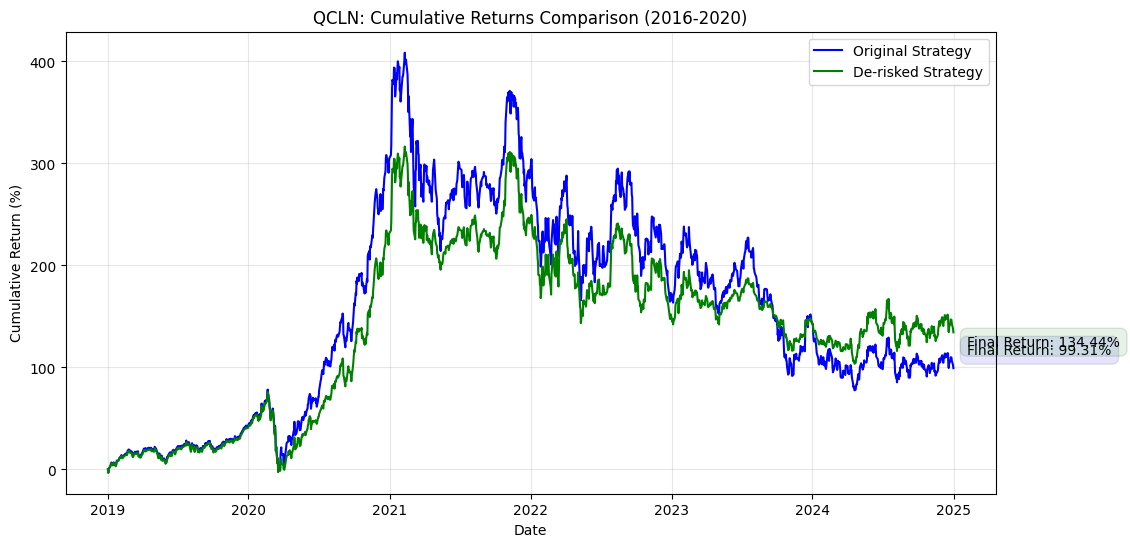


Final Cumulative Returns:
Original Strategy: 99.31%
De-risked Strategy: 134.44%


In [ ]:
percent_changes = ((metrics_df["Original"] - metrics_df["Hedged"]) / metrics_df["Original"] * 100).round(2)
percent_changes

# Calculate cumulative returns
cumulative_returns = (1 + test_returns).cumprod() - 1
cumulative_hedged = (1 + test_hedged).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns.index, cumulative_returns * 100, label='Original Strategy', color='blue')
plt.plot(cumulative_hedged.index, cumulative_hedged * 100, label='De-risked Strategy', color='green')

plt.title(f"{ticker}: Cumulative Returns Comparison (2016-2020)")
plt.ylabel("Cumulative Return (%)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)

# Add final values as text annotations
final_orig = cumulative_returns.iloc[-1] * 100
final_hedged = cumulative_hedged.iloc[-1] * 100

plt.annotate(f'Final Return: {final_orig:.2f}%',
            xy=(cumulative_returns.index[-1], final_orig),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='blue', alpha=0.1))

plt.annotate(f'Final Return: {final_hedged:.2f}%',
            xy=(cumulative_hedged.index[-1], final_hedged),
            xytext=(10, -10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.1))

plt.show()

# Print final returns
print("\nFinal Cumulative Returns:")
print(f"Original Strategy: {final_orig:.2f}%")
print(f"De-risked Strategy: {final_hedged:.2f}%")

In [ ]:
metrics_df["Percent Improvement"]  = ((metrics_df["Original"] - metrics_df["Hedged"]) / metrics_df["Original"] * 100).round(2)
metrics_df

Original    Hedged  Percent Improvement
VaR (95%)    -0.039508 -0.032500                17.74
CVaR (95%)   -0.054311 -0.048653                10.42
Max Drawdown  0.225466  0.185898                17.55

In [ ]:
# Calculate percent changes
metrics_comparison_percent = ((metrics_df["Original"] - metrics_df["Hedged"]) / metrics_df["Original"] * 100).round(2)

print("Risk Metrics Comparison with Percent Changes:")
metrics_comparison_percent

Risk Metrics Comparison with Percent Changes:


VaR (95%)       12.68
CVaR (95%)      11.48
Max Drawdown     0.00
dtype: float64

# USE: HMM Calculations




In [73]:
"""
def make_realized_vol_from_returns(ret_series: pd.Series,
                                   window: int = 20,
                                   trading_days: int = 252) -> pd.Series:
    rolling_sigma = ret_series.rolling(window=window).std(ddof=0)
    return rolling_sigma * np.sqrt(trading_days)
"""

In [14]:
def realised_vol_weekly(ret_series, window=20):
    # 1) daily realised σ
    daily_sigma = ret_series.rolling(window).std(ddof=0)
    # 2) pick last trading day of each ISO week
    wk_end = daily_sigma.groupby(daily_sigma.index.to_series().dt.isocalendar().week).tail(1)
    # 3) annualise to compare with weekly GARCH forecasts
    return wk_end * np.sqrt(252)

In [74]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 2.8 MB/s eta 0:00:00


In [15]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM

def predict_hmm_states_weekly(
    vol_series: pd.Series,
    *,
    window_days: int = 500,        # daily look-back window
    horizon_days: int = 5,         # one trading week ahead
    n_states: int = 3,
    hmm_iterations: int = 100,
    hmm_tolerance: float = 1e-4,
):
    """
    Fit a rolling Gaussian HMM on the most-recent `window_days` daily
    realised-vol observations and classify the hidden state *one week*
    (≈ `horizon_days`) ahead — but only once per ISO week.

    ►  The “week-end” anchor date is defined as the **last trading day
       appearing in that ISO calendar week**.
       If Friday is a holiday, Thursday (or Wednesday, …) is used.

    Returns
    -------
    state_df : pd.DataFrame
        Columns ['date','state_pred'] - one row per forecasted week.
        Each row’s `date` is the *target* trading day (t + horizon_days).
    label2id : dict[str, int]
        Mapping {'low': id_low, 'med': id_med, 'high': id_high}.
    id2label : dict[int, str]
        Reverse mapping {id_low:'low', …}.
    """

    # ────────────────────────────────────────────────────────────────────────
    # 0)  Clean input
    # ────────────────────────────────────────────────────────────────────────
    vol_series = (
        vol_series.sort_index()
                  .replace([np.inf, -np.inf], np.nan)
                  .dropna()
    )
    dates  = vol_series.index
    values = vol_series.values.reshape(-1, 1)

    # helper: is this index position the last trading day of its ISO week?
    def _is_week_end(idx: int) -> bool:
        if idx == len(dates) - 1:          # very last observation
            return True
        this_week = dates[idx].isocalendar()[:2]   # (ISO year, ISO week)
        next_week = dates[idx + 1].isocalendar()[:2]
        return this_week != next_week               # change ⇒ new week

    pred_dates, state_preds = [], []
    last_trainable = len(values) - horizon_days

    # ────────────────────────────────────────────────────────────────────────
    # 1)  Rolling estimation & week-ahead prediction
    # ────────────────────────────────────────────────────────────────────────
    for i in range(window_days, last_trainable):
        if not _is_week_end(i):                     # skip mid-week rows
            continue

        X_train   = values[i - window_days : i]                  # 500-day window
        X_target  = values[i + horizon_days].reshape(1, -1)      # vol at t+5

        model = GaussianHMM(
            n_components=n_states,
            covariance_type="diag",
            n_iter=hmm_iterations,
            tol=hmm_tolerance,
        ).fit(X_train)

        state = model.predict(X_target)[0]

        pred_dates.append(dates[i + horizon_days])  # stamp at target date
        state_preds.append(state)

    state_df = pd.DataFrame({"date": pred_dates, "state_pred": state_preds})

    # ────────────────────────────────────────────────────────────────────────
    # 2)  Map numeric states → 'low' / 'med' / 'high'
    # ────────────────────────────────────────────────────────────────────────
    joined = state_df.set_index("date").join(vol_series.rename("σ"))
    mean_by_state = joined.groupby("state_pred")["σ"].mean().sort_values()

    sorted_ids = mean_by_state.index.to_list()      # ascending σ
    label2id = {"low": sorted_ids[0],
                "med": sorted_ids[1],
                "high": sorted_ids[2]}
    id2label = {sid: lbl for lbl, sid in label2id.items()}

    return state_df, label2id, id2label

In [29]:
def plot_hmm_states_scatter(
    vol_series: pd.Series,
    state_series: pd.Series | pd.DataFrame,
    *,
    id2label: dict[int, str] | None = None,     # numeric-to-text map
    state_colors: dict[str, str] | None = None, # keyed by 'low','med','high'
    figsize: tuple[int, int] = (12, 4),
    title: str | None = None,
    ylabel: str = "Realised Volatility",
    ticker: str | None = None,
    start_date: str | None = None,
    end_date: str | None = None
):
    """
    Grey daily volatility line + coloured weekly points.

    Parameters:
    -----------
    vol_series : pd.Series
        Series of volatility values
    state_series : pd.Series or pd.DataFrame
        Series or DataFrame of state predictions
    id2label : dict, optional
        Mapping from state numbers to labels
    state_colors : dict, optional
        Mapping from state labels to colors
    figsize : tuple, optional
        Figure size (width, height)
    title : str, optional
        Plot title
    ylabel : str, optional
        Y-axis label
    ticker : str, optional
        Ticker symbol for the title
    start_date : str, optional
        Start date for the plot (format: 'YYYY-MM-DD')
    end_date : str, optional
        End date for the plot (format: 'YYYY-MM-DD')
    """

    # Accept the 2-column DF shape
    if isinstance(state_series, pd.DataFrame):
        state_series = state_series.set_index("date")["state_pred"]

    # Make sure both indexes are datetime and sorted
    vol_series = vol_series.sort_index()
    state_series = state_series.sort_index()

    # Filter by date range if provided
    if start_date:
        start_date = pd.to_datetime(start_date)
        vol_series = vol_series[vol_series.index >= start_date]
        state_series = state_series[state_series.index >= start_date]
    
    if end_date:
        end_date = pd.to_datetime(end_date)
        vol_series = vol_series[vol_series.index <= end_date]
        state_series = state_series[state_series.index <= end_date]

    # Default colours
    default_colours = {"low": "green", "med": "orange", "high": "red"}

    # --- Colour & label helpers -------------------------------------------
    if id2label is None:                   # stick with numeric labels
        colour_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        colour_func  = lambda s: colour_cycle[int(s) % len(colour_cycle)]
        legend_elems = [
            Line2D([0], [0], marker='o', lw=0, markersize=8,
                   markerfacecolor=colour_func(s), label=f"State {int(s)}")
            for s in np.sort(state_series.unique())
        ]
    else:                                  # use qualitative labels
        if state_colors is None:
            state_colors = default_colours
        colour_func = lambda s: state_colors[id2label[s]]
        legend_elems = [
            Line2D([0], [0], marker='o', lw=0, markersize=8,
                   markerfacecolor=state_colors[lbl], label=lbl.capitalize())
            for lbl in ["low", "med", "high"] if lbl in state_colors
        ]

    # --- Plot --------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    # Grey daily line
    ax.plot(vol_series.index, vol_series, color="grey", lw=1, label="Realised Vol")

    # Coloured weekly scatter
    common_idx = state_series.index.intersection(vol_series.index)
    ax.scatter(
        common_idx,
        vol_series.loc[common_idx],
        c=[colour_func(s) for s in state_series.loc[common_idx]],
        s=8,
    )

    legend_elems.append(Line2D([0], [0], color="grey", lw=1, label="Realised Vol"))
    ax.legend(handles=legend_elems, frameon=False)

    ax.set_ylabel(ylabel)
    ax.set_xlabel("Date")
    if title is None:
        base = f"{ticker}: " if ticker else ""
        date_range = ""
        if start_date and end_date:
            date_range = f" ({start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')})"
        title = base + "HMM Regimes on Realised Volatility" + date_range
    ax.set_title(title)
    ax.grid(alpha=0.3)

    return ax


In [355]:
import pandas as pd

def hedge_by_hmm_state(
    equity_ret: pd.Series,
    state_series: pd.Series | pd.DataFrame,
    safe_ret: pd.Series,
    *,
    de_risk_med: float = 0.30,
    de_risk_high: float = 0.60,
    id2label: dict[int, str] | None = None,
    half_spread: float = 1e-4,
) -> pd.Series:
    """
    Blend equity & safe-asset returns according to HMM regime labels.

    * Works when `state_series` is daily, weekly, or monthly.
    * Forward-fills the most recent state so every trading day gets a weight.

    Parameters
    ----------
    equity_ret : pd.Series   – daily equity returns (decimal).
    state_series : pd.Series | pd.DataFrame
        HMM numeric IDs or already-text labels, indexed by date.
        If a DataFrame (from predict_hmm_states*), it must have ['date','state_pred'].
    safe_ret : pd.Series     – daily safe-asset returns (decimal).
    de_risk_med, de_risk_high : float   – % shifted into bonds in MED / HIGH states.
    id2label : dict[int,str] | None
        Mapping {numeric_id : 'low'/'med'/'high'} if `state_series` is numeric.

    Returns
    -------
    pd.Series – hedged daily returns, aligned with `equity_ret`.
    """
    # Accept the 2-column DF shape
    if isinstance(state_series, pd.DataFrame):
        state_series = state_series.set_index("date")["state_pred"]

    # ── 1.  Align daily equity & bond returns ──────────────────────────────
    idx = equity_ret.index.intersection(safe_ret.index)
    eq  = equity_ret.loc[idx]
    sf  = safe_ret.loc[idx]

    # ── 2.  Prepare the state labels at daily frequency ────────────────────
    st = state_series

    # Map numeric → text if needed
    if id2label is not None:
        st = st.map(id2label)

    # Reindex to daily calendar, forward-filling the last known state
    st_daily = (
        st.reindex(idx, method="ffill")      # carry regime forward
          .fillna(method="bfill")            # in case the first few days miss
    )

    # Sanity check
    if not {"low", "med", "high"}.issubset(set(st_daily.unique())):
        raise ValueError("State labels must resolve to 'low', 'med', 'high'.")

    # ── 3.  Build dynamic equity weight per day ────────────────────────────
    w_eq = pd.Series(1.0, index=idx)               # default 100 % equity
    w_eq[st_daily == "med"]  = 1.0 - de_risk_med
    w_eq[st_daily == "high"] = 1.0 - de_risk_high

    cost = half_spread * w_eq.diff().abs().fillna(0.0)


    # ── 4.  Blend returns ─────────────────────────────────────────────────
    hedged = w_eq * eq + (1.0 - w_eq) * sf - cost
    hedged.name = "hedged_return"
    return hedged


In [56]:
import numpy as np
import pandas as pd
from itertools import product   # ← you forgot to import this

def compute_period_stats_HMM_weekly(
    returns: pd.Series,
    states: pd.Series,
    bond_returns: pd.Series,
    start_date: str,
    end_date: str,
    med_list: list[float],
    high_list: list[float],
    id2label: dict[int, str] | None = None,
    min_obs: int = 40,
) -> pd.DataFrame:
    """
    Compute weekly statistics for both hedged and unhedged strategies over a period.
    """

    # First align all series on their common dates
    common_idx = returns.index.intersection(states.index).intersection(bond_returns.index)
    rets = returns.loc[common_idx]
    states = states.loc[common_idx]
    bonds = bond_returns.loc[common_idx]
    
    # Then filter by date range
    mask = (rets.index >= start_date) & (rets.index <= end_date)
    rets = rets[mask]
    states = states[mask]
    bonds = bonds[mask]
    
    # Resample raw returns to weekly
    raw_weekly = rets.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
    
    if len(raw_weekly) < min_obs:
        return pd.DataFrame()
    
    def compute_stats(series):
        if len(series) < min_obs:
            return None
        
        cum_ret = (1 + series).prod() - 1.0
        var_5 = series.quantile(0.05)
        cvar_5 = series[series <= var_5].mean()
        path = (1 + series).cumprod()
        mdd = (path / path.cummax() - 1).min()
        sharpe = np.sqrt(52) * series.mean() / series.std(ddof=0)
        vol = np.sqrt(52) * series.std(ddof=0)
        
        return {
            "Cumulative Return": cum_ret,
            "VaR (5%)": var_5,
            "CVaR (5%)": cvar_5,
            "Max Drawdown": mdd,
            "Sharpe Ratio": sharpe,
            "Volatility": vol
        }
    
    # Initialize records
    records = []
    
    # Add unhedged statistics
    unhedged_stats = compute_stats(raw_weekly)
    if unhedged_stats is not None:
        records.append({
            "Strategy": "Unhedged",
            "De-risk Med (%)": np.nan,
            "De-risk High (%)": np.nan,
            **unhedged_stats
        })
    
    # Compute hedged statistics for each med / high combo
    for med, high in product(med_list, high_list):
        # Hedge daily
        hedged_daily = hedge_by_hmm_state(
            equity_ret=rets,
            state_series=states,
            safe_ret=bonds,
            de_risk_med=med,
            de_risk_high=high,
            id2label=id2label
        )
        
        # Resample to weekly correctly
        hedged_weekly = hedged_daily.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
        
        hedged_stats = compute_stats(hedged_weekly)
        if hedged_stats is not None:
            records.append({
                "Strategy": f"Hedged {int(med*100)}/{int(high*100)}%",
                "De-risk Med (%)": int(med * 100),
                "De-risk High (%)": int(high * 100),
                **hedged_stats
            })
    
    # Final DataFrame
    df = pd.DataFrame.from_records(records)
    
    # Format numeric
    numeric_cols = ['Cumulative Return', 'VaR (5%)', 'CVaR (5%)', 
                    'Max Drawdown', 'Sharpe Ratio', 'Volatility']
    
    return df

In [193]:
def plot_cumulative_returns_HMM(
    etf_name: str,
    renewable_df: pd.DataFrame,
    hedged_returns: pd.Series,
    *,
    start_date: str | pd.Timestamp = None,
    end_date:   str | pd.Timestamp = None,
    de_risk_med:  float | None = None,
    de_risk_high: float | None = None,
):
    """
    Plot cumulative‐return paths for an ETF vs. its HMM-hedged version.

    Parameters
    ----------
    etf_name        : str              – column name in `renewable_df`.
    renewable_df    : pd.DataFrame     – daily returns (decimal).
    hedged_returns  : pd.Series        – hedged daily returns (decimal).
    start_date,end_date : optional     – date window (inclusive).
    de_risk_med     : float | None     – % shifted into bonds in MED regime.
    de_risk_high    : float | None     – % shifted into bonds in HIGH regime.
    """
    # slice to window
    raw_ret_cropped   = renewable_df[etf_name].loc[start_date:end_date]
    hedged_cropped    = hedged_returns.loc[start_date:end_date]

    # cumulative growth of $1
    cum_raw    = (1 + raw_ret_cropped).cumprod()
    cum_hedged = (1 + hedged_cropped).cumprod()

    # build the title with de-risk info if provided
    title = f"{etf_name}: Cumulative Returns — Non-Hedged vs. HMM-Hedged"
    if (de_risk_med is not None) and (de_risk_high is not None):
        title += f"\n(Hedge: {int(de_risk_med*100)}% in MED, {int(de_risk_high*100)}% in HIGH)"

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(cum_raw.index, cum_raw, label="Non-Hedged", color="blue")
    plt.plot(cum_hedged.index, cum_hedged, label="HMM-Hedged", color="red", linestyle="--")

    plt.title(title, fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.grid(alpha=0.4, linestyle="--")
    plt.tight_layout()
    plt.show()

In [194]:
def compute_risk_metrics(
    test_returns: pd.Series,
    test_hedged:  pd.Series,
    start: str | pd.Timestamp,
    end:   str | pd.Timestamp
) -> pd.DataFrame:
    # ── 1. slice to the desired window ──────────────────────────────────────
    start = pd.to_datetime(start)
    end   = pd.to_datetime(end)

    unhedged = test_returns.loc[start:end]
    hedged   = test_hedged .loc[start:end]

    if unhedged.empty or hedged.empty:
        raise ValueError("No data in the specified date range.")

    # ensure equal dates
    idx = unhedged.index.intersection(hedged.index)
    unhedged, hedged = unhedged.loc[idx], hedged.loc[idx]

    # ── 2. helper for the three metrics ─────────────────────────────────────
    def _metrics(r):
        var  = r.quantile(0.05)
        cvar = r[r <= var].mean()
        # Max drawdown on cumulative return path
        cum = (1 + r).cumprod()
        mdd = (cum / cum.cummax() - 1).min()
        return var, cvar, mdd

    orig_var, orig_cvar, orig_mdd = _metrics(unhedged)
    hedg_var, hedg_cvar, hedg_mdd = _metrics(hedged)

    metrics_orig   = np.array([orig_var,  orig_cvar,  orig_mdd])
    metrics_hedged = np.array([hedg_var, hedg_cvar, hedg_mdd])
    pct_change     = (metrics_hedged - metrics_orig) / metrics_orig * 100.0

    out = pd.DataFrame(
        {
            "Original":         metrics_orig,
            "Hedged":           metrics_hedged,
            "Percent Change (%)": pct_change,
        },
        index=["VaR (95%)", "CVaR (95%)", "Max Drawdown"],
    )
    return out

In [195]:
def single_period_metrics_HMM(
    unhedged_returns: pd.Series,
    hedged_returns: pd.Series,
    start_date: str,
    end_date: str,
    min_obs: int = 50,
) -> dict | None:
    """
    Same metrics as before, but all values are *improvements*:
        • +Drag  -> hedged return is higher
        • +VaR/ CVaR/ MDD Reductions -> smaller tail risk
        • +Sharpe  -> higher risk-adjusted return
        • +Vol Change -> lower volatility
    """
    # 1) align & slice date range ---------------------------------------
    idx = unhedged_returns.index.intersection(hedged_returns.index)
    raw = unhedged_returns.loc[idx]
    hedg = hedged_returns.loc[idx]
    
    # Filter by date range instead of year
    mask = (raw.index >= start_date) & (raw.index <= end_date)
    raw, hedg = raw[mask], hedg[mask]

    if len(raw) < min_obs:
        return None

    # ── Now RESAMPLE TO WEEKLY ───────────────────────────────
    raw_weekly = raw.resample('W-FRI').sum()
    hedged_weekly = hedg.resample('W-FRI').sum()

    # ── performance & risk deltas ─────────────────────────────
    R_raw = (1 + raw_weekly).prod() - 1
    R_hdg = (1 + hedged_weekly).prod() - 1
    return_improve = (R_hdg - R_raw) / abs(R_raw) * 100.0

    var_raw, var_hdg = raw_weekly.quantile(0.05), hedged_weekly.quantile(0.05)
    cvar_raw = raw_weekly[raw_weekly <= var_raw].mean()
    cvar_hdg = hedged_weekly[hedged_weekly <= var_hdg].mean()

    def _mdd(x):
        path = (1 + x).cumprod()
        return (path / path.cummax() - 1).min()

    mdd_raw = _mdd(raw_weekly)
    mdd_hdg = _mdd(hedged_weekly)

    sharpe_raw = raw_weekly.mean() / raw_weekly.std(ddof=0) * np.sqrt(52)
    sharpe_hdg = hedged_weekly.mean() / hedged_weekly.std(ddof=0) * np.sqrt(52)
    sharpe_improve = (
        (sharpe_hdg - sharpe_raw) / abs(sharpe_raw) * 100.0
        if sharpe_raw != 0 else np.nan
    )

    vol_improve = (raw_weekly.std(ddof=0) - hedged_weekly.std(ddof=0)) / raw_weekly.std(ddof=0) * 100.0

    return {
        "Return Improvement":        return_improve,
        "VaR Reduction":              (abs(var_raw)  - abs(var_hdg))  / abs(var_raw)  * 100.0,
        "CVaR Reduction":             (abs(cvar_raw) - abs(cvar_hdg)) / abs(cvar_raw) * 100.0,
        "Max Drawdown Reduction":     (abs(mdd_raw)  - abs(mdd_hdg))  / abs(mdd_raw)  * 100.0,
        "Sharpe Ratio Improvement":   sharpe_improve,
        "Volatility Reduction":       vol_improve,
    }

In [196]:
import pandas as pd
from itertools import product

def period_sensitivity_averages_HMM(
    rets: pd.Series,
    states: pd.Series,
    bond_rets: pd.Series,
    start_date: str,
    end_date: str,
    med_list: list[float],
    high_list: list[float],
    *,
    id2label: dict[int, str] | None = None,
    min_obs: int = 50,
) -> pd.DataFrame:
    """
    Grid-search (de_risk_med, de_risk_high) and report the
    *average yearly improvements* vs. the unhedged series.
    Positive numbers are good (hedge is better).

    Parameters:
    -----------
    rets : pd.Series
        Equity returns series
    states : pd.Series
        HMM states series
    bond_rets : pd.Series
        Safe asset returns series
    start_date : str
        Start date for analysis
    end_date : str
        End date for analysis
    med_list : list[float]
        List of medium de-risking percentages to test
    high_list : list[float]
        List of high de-risking percentages to test
    id2label : dict, optional
        Mapping from state numbers to labels
    min_obs : int
        Minimum number of observations required

    Returns:
    --------
    pd.DataFrame
        One row per (med, high) pair with average improvements.
    """
    # Align once ------------------------------------------------------------
    idx = rets.index.intersection(states.index).intersection(bond_rets.index)
    rets = rets.loc[idx]
    states = states.loc[idx]
    bonds = bond_rets.loc[idx]

    # Get list of years in the period
    years = pd.date_range(start_date, end_date, freq='Y').year.tolist()

    records = []

    for med, high in product(med_list, high_list):
        # Build the hedged series for this parameter pair
        hedged = hedge_by_hmm_state(
            equity_ret=rets,
            state_series=states,
            safe_ret=bonds,
            de_risk_med=med,
            de_risk_high=high,
            id2label=id2label,
        )

        yearly = []
        for y in years:
            m = single_period_metrics_HMM(
                unhedged_returns=rets,
                hedged_returns=hedged,
                start_date=f'{y}-01-01',
                end_date=f'{y}-12-31',
                min_obs=min_obs,
            )
            if m is not None:
                yearly.append(m)

        if not yearly:        # no valid years
            continue

        dfy = pd.DataFrame(yearly)

        records.append({
            "De-risk Med (%)":        int(med * 100),
            "De-risk High (%)":       int(high * 100),
            "Avg Return Improve":     dfy["Return Improvement"].mean(),
            "Avg VaR Reduction":      dfy["VaR Reduction"].mean(),
            "Avg CVaR Reduction":     dfy["CVaR Reduction"].mean(),
            "Avg MDD Reduction":      dfy["Max Drawdown Reduction"].mean(),
            "Avg Sharpe Improve":     dfy["Sharpe Ratio Improvement"].mean(),
            "Avg Vol Reduction":      dfy["Volatility Reduction"].mean(),
            "Years Used":             len(dfy),
        })

    return pd.DataFrame(records)



In [197]:
""""""
import numpy as np
import pandas as pd
from itertools import product   # ← you forgot to import this

def compute_period_stats_HMM_weekly(
    returns: pd.Series,
    states: pd.Series,
    bond_returns: pd.Series,
    start_date: str,
    end_date: str,
    med_list: list[float],
    high_list: list[float],
    id2label: dict[int, str] | None = None,
    min_obs: int = 40,
) -> pd.DataFrame:
    """
    Compute weekly statistics for both hedged and unhedged strategies over a period.
    """

    # First align all series on their common dates
    common_idx = returns.index.intersection(states.index).intersection(bond_returns.index)
    rets = returns.loc[common_idx]
    states = states.loc[common_idx]
    bonds = bond_returns.loc[common_idx]
    
    # Then filter by date range
    mask = (rets.index >= start_date) & (rets.index <= end_date)
    rets = rets[mask]
    states = states[mask]
    bonds = bonds[mask]
    
    # Resample raw returns to weekly
    raw_weekly = rets.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
    
    if len(raw_weekly) < min_obs:
        return pd.DataFrame()
    
    def compute_stats(series):
        if len(series) < min_obs:
            return None
        
        cum_ret = (1 + series).prod() - 1.0
        var_5 = series.quantile(0.05)
        cvar_5 = series[series <= var_5].mean()
        path = (1 + series).cumprod()
        mdd = (path / path.cummax() - 1).min()
        sharpe = np.sqrt(52) * series.mean() / series.std(ddof=0)
        vol = np.sqrt(52) * series.std(ddof=0)
        
        return {
            "Cumulative Return": cum_ret,
            "VaR (5%)": var_5,
            "CVaR (5%)": cvar_5,
            "Max Drawdown": mdd,
            "Sharpe Ratio": sharpe,
            "Volatility": vol
        }
    
    # Initialize records
    records = []
    
    # Add unhedged statistics
    unhedged_stats = compute_stats(raw_weekly)
    if unhedged_stats is not None:
        records.append({
            "Strategy": "Unhedged",
            "De-risk Med (%)": np.nan,
            "De-risk High (%)": np.nan,
            **unhedged_stats
        })
    
    # Compute hedged statistics for each med / high combo
    for med, high in product(med_list, high_list):
        # Hedge daily
        hedged_daily = hedge_by_hmm_state(
            equity_ret=rets,
            state_series=states,
            safe_ret=bonds,
            de_risk_med=med,
            de_risk_high=high,
            id2label=id2label
        )
        
        # Resample to weekly correctly
        hedged_weekly = hedged_daily.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
        
        hedged_stats = compute_stats(hedged_weekly)
        if hedged_stats is not None:
            records.append({
                "Strategy": f"Hedged {int(med*100)}/{int(high*100)}%",
                "De-risk Med (%)": int(med * 100),
                "De-risk High (%)": int(high * 100),
                **hedged_stats
            })
    
    # Final DataFrame
    df = pd.DataFrame.from_records(records)
    
    # Format numeric
    numeric_cols = ['Cumulative Return', 'VaR (5%)', 'CVaR (5%)', 
                    'Max Drawdown', 'Sharpe Ratio', 'Volatility']
    
    return df
""""""

''

In [198]:
def compute_period_stats_HMM_weekly(
    returns: pd.Series,
    states: pd.Series,
    bond_returns: pd.Series,
    start_date: str,
    end_date: str,
    med_list: list[float],
    high_list: list[float],
    id2label: dict[int, str] | None = None,
    min_obs: int = 40,
) -> pd.DataFrame:
    """
    Compute weekly profit/loss (PnL) stats for both hedged and unhedged HMM strategies.
    Reports *average weekly return* instead of cumulative return.
    """
    common_idx = returns.index.intersection(states.index).intersection(bond_returns.index)
    rets = returns.loc[common_idx]
    states = states.loc[common_idx]
    bonds = bond_returns.loc[common_idx]

    mask = (rets.index >= start_date) & (rets.index <= end_date)
    rets = rets[mask]
    states = states[mask]
    bonds = bonds[mask]

    raw_weekly = rets.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
    if len(raw_weekly) < min_obs:
        return pd.DataFrame()

    def compute_stats(series):
        if len(series) < min_obs:
            return None
        var_5 = series.quantile(0.05)
        cvar_5 = series[series <= var_5].mean()
        path = (1 + series).cumprod()
        mdd = (path / path.cummax() - 1).min()
        sharpe = np.sqrt(52) * series.mean() / series.std(ddof=0)
        vol = np.sqrt(52) * series.std(ddof=0)
        return {
            "Avg Weekly Return": series.mean(),
            "VaR (5%)": var_5,
            "CVaR (5%)": cvar_5,
            "Max Drawdown": mdd,
            "Sharpe Ratio": sharpe,
            "Volatility": vol
        }

    records = []
    unhedged_stats = compute_stats(raw_weekly)
    if unhedged_stats is not None:
        records.append({
            "Strategy": "Unhedged",
            "De-risk Med (%)": np.nan,
            "De-risk High (%)": np.nan,
            **unhedged_stats
        })

    for med, high in product(med_list, high_list):
        hedged_daily = hedge_by_hmm_state(
            equity_ret=rets,
            state_series=states,
            safe_ret=bonds,
            de_risk_med=med,
            de_risk_high=high,
            id2label=id2label
        )
        hedged_weekly = hedged_daily.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
        hedged_stats = compute_stats(hedged_weekly)
        if hedged_stats is not None:
            records.append({
                "Strategy": f"Hedged {int(med*100)}/{int(high*100)}%",
                "De-risk Med (%)": int(med * 100),
                "De-risk High (%)": int(high * 100),
                **hedged_stats
            })

    df = pd.DataFrame.from_records(records)
    numeric_cols = ['Avg Weekly Return', 'VaR (5%)', 'CVaR (5%)',
                    'Max Drawdown', 'Sharpe Ratio', 'Volatility']
    return df

In [25]:
def realised_vol_daily(ret_series, window=20, annualise=True):
    sigma = ret_series.rolling(window).std(ddof=0)
    return sigma * np.sqrt(252) if annualise else sigma

realised_vol_daily_ICLN  = realised_vol_daily(renewable_df["ICLN"]).dropna()
realised_vol_daily_PBW   = realised_vol_daily(renewable_df["PBW"]).dropna()
realised_vol_daily_QCLN  = realised_vol_daily(renewable_df["QCLN"]).dropna()

# Predict weekly states one week ahead
state_df_ICLN, label2id_ICLN, id2label_ICLN = predict_hmm_states_weekly(realised_vol_daily_ICLN)
state_df_PBW , label2id_PBW , id2label_PBW = predict_hmm_states_weekly(realised_vol_daily_PBW)
state_df_QCLN, label2id_QCLN, id2label_QCLN = predict_hmm_states_weekly(realised_vol_daily_QCLN)

Model is not converging.  Current: 466.54582966053823 is not greater than 466.54668102141403. Delta is -0.0008513608757994007
Model is not converging.  Current: 485.26635243089726 is not greater than 485.26751539373987. Delta is -0.0011629628426135241
Model is not converging.  Current: 481.6634992756774 is not greater than 481.6638788551932. Delta is -0.0003795795158225701
Model is not converging.  Current: 486.44301846022654 is not greater than 486.4439005752957. Delta is -0.0008821150691460389
Model is not converging.  Current: 475.4015937110659 is not greater than 475.4017276908358. Delta is -0.00013397976988471783
Model is not converging.  Current: 748.0098347883311 is not greater than 748.0126415421489. Delta is -0.0028067538178220275
Model is not converging.  Current: 533.7521220916385 is not greater than 533.7522331939771. Delta is -0.00011110233856470586
Model is not converging.  Current: 547.5246306695394 is not greater than 547.5259784696445. Delta is -0.0013478001051225874
M

In [26]:
# combine on dates
state_df_ICLN = state_df_ICLN.set_index('date')
state_df_PBW = state_df_PBW.set_index('date')
state_df_QCLN = state_df_QCLN.set_index('date')
realized_vols = pd.concat([realised_vol_daily_ICLN, realised_vol_daily_PBW, realised_vol_daily_QCLN], axis=1)
states_hmm = pd.concat([state_df_ICLN, state_df_PBW, state_df_QCLN], axis=1)
id2label = {"ICLN": id2label_ICLN,"PBW" : id2label_PBW,"QCLN": id2label_QCLN,}

# rename to ICLN, PBW, and QCLN
realized_vols.columns = ['ICLN', 'PBW', 'QCLN']
states_hmm.columns = ['ICLN', 'PBW', 'QCLN']

states_hmm.index     = pd.to_datetime(states_hmm.index)
realized_vols.index  = pd.to_datetime(realized_vols.index)

In [358]:
# example
hedged_icln = hedge_by_hmm_state(
    equity_ret   = renewable_df["ICLN"],   # daily returns
    state_series = states_hmm["ICLN"],     # weekly IDs (0/1/2)
    safe_ret     = bond_returns["SHY"],    # daily bond returns
    de_risk_med  = 0.5,
    de_risk_high = 0.50,
    id2label     = id2label_ICLN,
)
hedged_icln

date
2008-06-26   -0.014749
2008-06-27   -0.008601
2008-06-30    0.001229
2008-07-01   -0.014586
2008-07-02   -0.013127
                ...   
2024-12-24    0.001969
2024-12-26   -0.001595
2024-12-27   -0.002896
2024-12-30   -0.003603
2024-12-31   -0.001882
Name: hedged_return, Length: 4157, dtype: float64

In [115]:
# save states_hmm to a csv file so we don´t have to run the HMM every time
states_hmm.to_csv("states_hmm.csv", index=True)

In [137]:
# read states_hmm csv file if we haven´t ran it here:
states_hmm = pd.read_csv("states_hmm.csv").set_index("date")

<Axes: title={'center': 'QCLN: HMM Regimes on Realised Volatility (2008-01-01 to 2017-12-31)'}, xlabel='Date', ylabel='500-day σ (annualised)'>

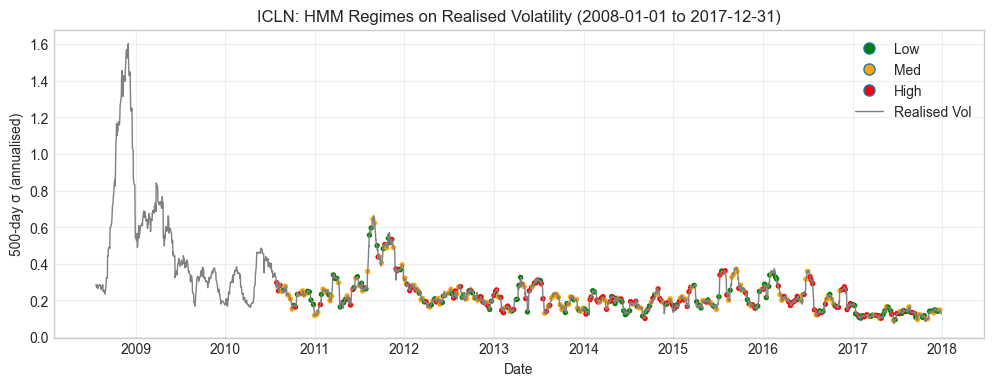

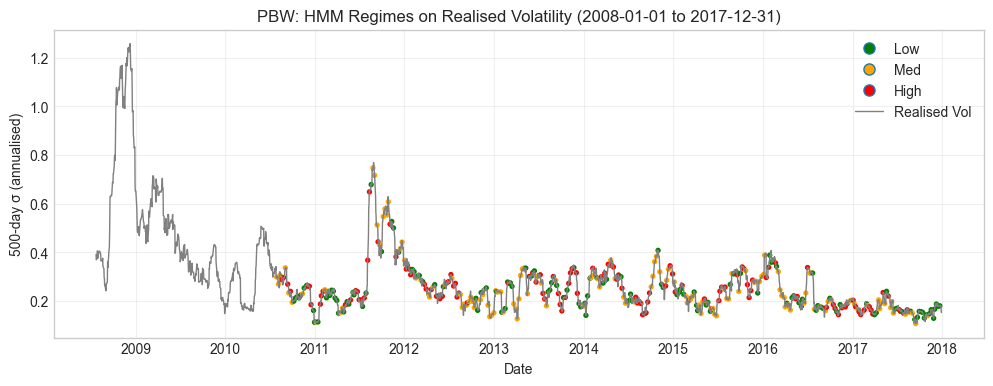

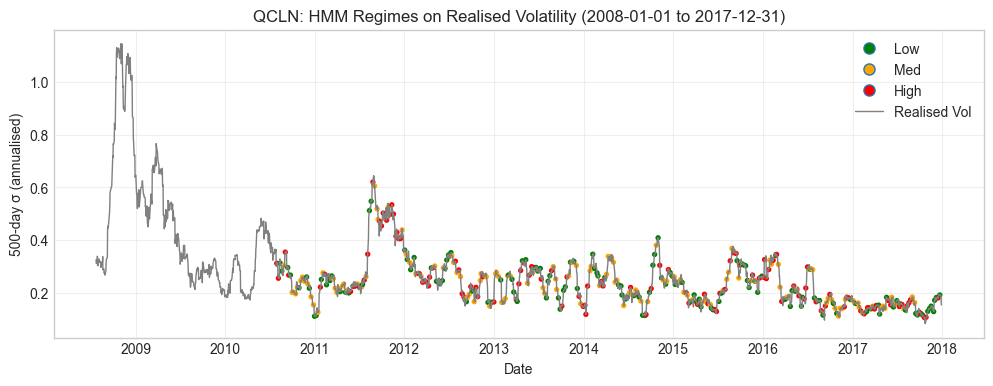

In [32]:
plot_hmm_states_scatter(
    realised_vol_daily_ICLN,
    states_hmm["ICLN"],
    id2label=id2label_ICLN,
    ticker="ICLN",
    ylabel="500-day σ (annualised)",
    start_date = "2008-01-01",
    end_date = "2017-12-31"
)


plot_hmm_states_scatter(
    realised_vol_daily_PBW,
    states_hmm["PBW"],
    id2label=id2label_PBW,
    ticker="PBW",
    ylabel="500-day σ (annualised)",
    start_date = "2008-01-01",
    end_date = "2017-12-31"
)

plot_hmm_states_scatter(
    realised_vol_daily_QCLN,
    states_hmm["QCLN"],
    id2label=id2label_QCLN,
    ticker="QCLN",
    ylabel="500-day σ (annualised)",
    start_date = "2008-01-01",
    end_date = "2017-12-31"
)

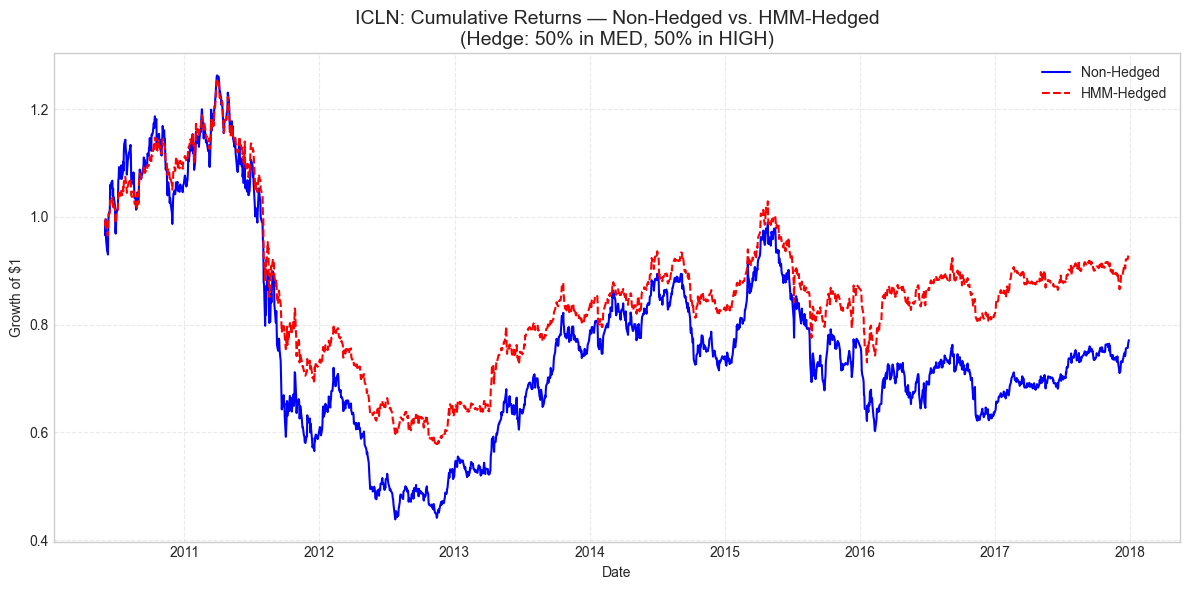

In [360]:
etf = "ICLN"
de_risk_med = 0.5
de_risk_high = 0.5

hedged = hedge_by_hmm_state(
    equity_ret   = renewable_df[etf],   # daily returns
    state_series = states_hmm[etf],     # weekly IDs (0/1/2)
    safe_ret     = bond_returns["SHY"],    # daily bond returns
    de_risk_med  = de_risk_med,
    de_risk_high = de_risk_high,
    id2label     = id2label[etf],          # {0:'high',1:'med',2:'low'} for example
)

plot_cumulative_returns_HMM(etf,
                            renewable_df,
                            hedged,
                            start_date="2010-06-01",
                            end_date="2017-12-31",
                            de_risk_med = de_risk_med,
                            de_risk_high = de_risk_high
                            )

In [361]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

def merge_hmm_metrics_with_unhedged(
    absolute_df: pd.DataFrame,
    improvement_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Merge absolute and improvement stats for HMM grid, preserving the Unhedged row.
    """
    # Separate the unhedged row from the absolute_df
    unhedged = absolute_df[absolute_df["Strategy"] == "Unhedged"]
    
    # Filter out Unhedged before merging
    hedged_abs = absolute_df[absolute_df["Strategy"] != "Unhedged"]

    # Merge on med/high de-risk grid
    merged = pd.merge(
        hedged_abs,
        improvement_df,
        how="inner",
        on=["De-risk Med (%)", "De-risk High (%)"]
    )

    # Reattach the unhedged row (no improvements, so fill with 0 or NaN)
    for col in ["Avg Return Improve", "Avg VaR Reduction", "Avg CVaR Reduction",
                "Avg MDD Reduction", "Avg Sharpe Improve", "Avg Vol Reduction"]:
        unhedged[col] = 0.0

    # Combine back
    merged_full = pd.concat([merged, unhedged], ignore_index=True)

    return merged_full


def plot_hmm_risk_frontier(
    merged_df: pd.DataFrame,
    unhedged_row: pd.Series,
    etf_name: str,
    risk_col: str = "Avg VaR Reduction",
    return_col: str = "Avg Weekly Return",
    figsize=(12, 4)
):
    """
    Plot HMM-style frontier with separate med/high de-risk levels.
    Colors = Med %; Shapes = High %; Unhedged shown as black star.
    """
    fig, ax = plt.subplots(figsize=figsize)

    med_levels = sorted(merged_df["De-risk Med (%)"].dropna().unique())
    high_levels = sorted(merged_df["De-risk High (%)"].dropna().unique())

    palette = sns.color_palette("viridis", len(med_levels))
    med_colors = {med: palette[i] for i, med in enumerate(med_levels)}

    markers = {25: "o", 50: "o", 75: "s", 90: "^", 100: "P"}

    for med in med_levels:
        sub = merged_df[merged_df["De-risk Med (%)"] == med]
        sub = sub.sort_values("De-risk High (%)")
        
        ax.plot(
            sub[return_col],
            sub[risk_col],
            color=med_colors[med],
            lw=2,
            label=f"Med {med}%"
        )

        for idx, row in sub.iterrows():
            high = row["De-risk High (%)"]
            ax.scatter(
                row[return_col],
                row[risk_col],
                color=med_colors[med],
                marker=markers.get(high, "o"),
                s=100,
                edgecolor="black",
                linewidth=0.5
            )

    # Plot unhedged
    ax.scatter(
        unhedged_row[return_col],
        0,
        color="black",
        s=250,
        marker="*",
        label="Unhedged",
        zorder=5
    )

    ax.axhline(0, color="grey", linestyle="--", lw=1)
    ax.axvline(unhedged_row[return_col], color="grey", linestyle="--", lw=1)

    ax.set_title(f"{etf_name}: HMM Frontier (VaR Reduction vs Return)", fontsize=14)
    ax.set_xlabel("Avg Weekly Return", fontsize=12)
    ax.set_ylabel("Average VaR Reduction (%)", fontsize=12)
    ax.grid(alpha=0.4, linestyle="--")

    # Build legends
    med_patches = [
        mpatches.Patch(color=med_colors[m], label=f"Med {m}%") for m in med_levels
    ]

    high_handles = [
        mlines.Line2D([], [], color='black', marker=markers[h], linestyle='None',
                      markersize=8, label=f"High {h}%")
        for h in high_levels
    ]

    leg1 = ax.legend(handles=med_patches, title="Med De-risk", loc='upper left', bbox_to_anchor=(1.02, 1))
    leg2 = ax.legend(handles=high_handles, title="High De-risk", loc='upper left', bbox_to_anchor=(1.02, 0.5))
    ax.add_artist(leg1)

    plt.tight_layout()
    plt.show()

    

In [362]:
med_list = [0, 0.25, 0.40, 0.50]
high_list = [0.50, 0.75, 0.90, 1.0]
start_date = "2010-01-01"
end_date = "2017-12-31"

etf = "ICLN"
# gives improvements 
grid_ICLN_yearly_improvements = period_sensitivity_averages_HMM(
    rets       = renewable_df[etf],
    states     = states_hmm[etf],
    bond_rets  = bond_returns["SHY"],
    start_date      = start_date,
    end_date        = end_date,
    med_list   = med_list,
    high_list  = high_list,
    id2label   = id2label[etf]  # from map_states_by_mean_vol
)
grid_ICLN_stats = compute_period_stats_HMM_weekly(
    returns=renewable_df[etf],
    states=states_hmm[etf],
    bond_returns=bond_returns["SHY"],
    start_date=start_date,
    end_date=end_date,
    med_list=med_list,
    high_list=high_list,
    id2label=id2label[etf]
)
#########################################################
etf = "PBW"
grid_PBW_yearly_improvements = period_sensitivity_averages_HMM(
    rets       = renewable_df[etf],
    states     = states_hmm[etf],
    bond_rets  = bond_returns["SHY"],
    start_date      = start_date,
    end_date        = end_date,
    med_list   = med_list,
    high_list  = high_list,
    id2label   = id2label[etf]  # from map_states_by_mean_vol
)
grid_PBW_stats = compute_period_stats_HMM_weekly(
    returns=renewable_df[etf],
    states=states_hmm[etf],
    bond_returns=bond_returns["SHY"],
    start_date=start_date,
    end_date=end_date,
    med_list=med_list,
    high_list=high_list,
    id2label=id2label[etf]
)

#########################################################
etf = "QCLN"
grid_QCLN_yearly_improvements = period_sensitivity_averages_HMM(
    rets       = renewable_df[etf],
    states     = states_hmm[etf],
    bond_rets  = bond_returns["SHY"],
    start_date      = start_date,
    end_date        = end_date,
    med_list   = med_list,
    high_list  = high_list,
    id2label   = id2label[etf]  # from map_states_by_mean_vol
)
grid_QCLN_stats = compute_period_stats_HMM_weekly(
    returns=renewable_df[etf],
    states=states_hmm[etf],
    bond_returns=bond_returns["SHY"],
    start_date=start_date,
    end_date=end_date,
    med_list=med_list,
    high_list=high_list,
    id2label=id2label[etf]
)

ETF: ICLN, Med Level: 0%, Points found: 4
ETF: ICLN, Med Level: 25.0%, Points found: 4
ETF: ICLN, Med Level: 40.0%, Points found: 4
ETF: ICLN, Med Level: 50.0%, Points found: 4
ETF: PBW, Med Level: 0%, Points found: 4
ETF: PBW, Med Level: 25.0%, Points found: 4
ETF: PBW, Med Level: 40.0%, Points found: 4
ETF: PBW, Med Level: 50.0%, Points found: 4
ETF: QCLN, Med Level: 0%, Points found: 4
ETF: QCLN, Med Level: 25.0%, Points found: 4
ETF: QCLN, Med Level: 40.0%, Points found: 4
ETF: QCLN, Med Level: 50.0%, Points found: 4


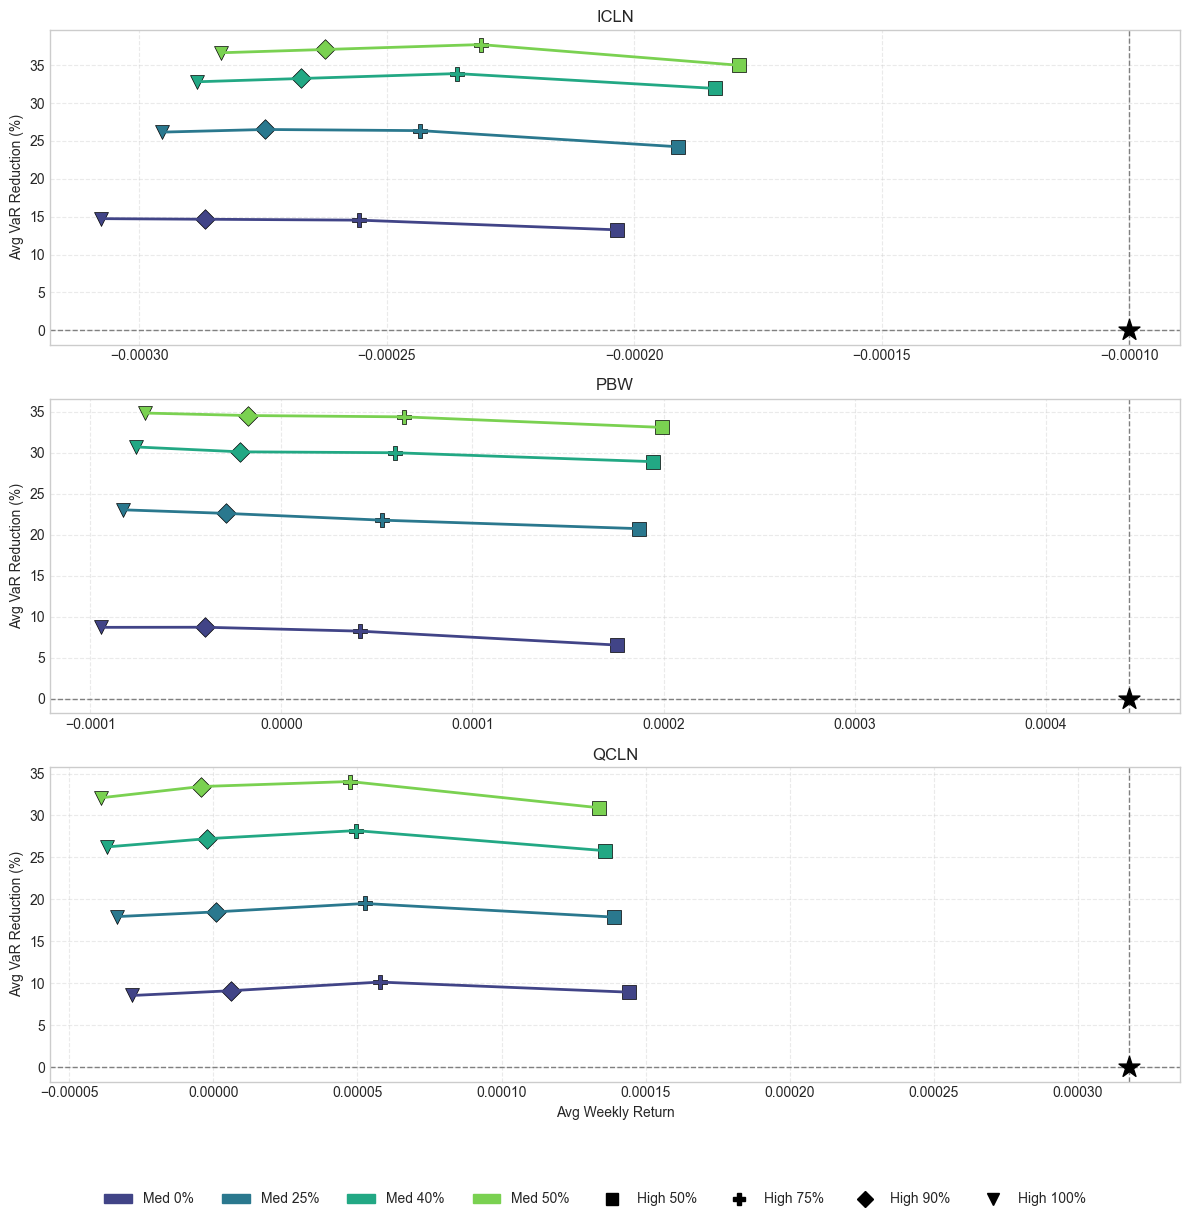


ICLN unique De-risk Med (%) values:
[0.0, 25.0, 40.0, 50.0, nan]

PBW unique De-risk Med (%) values:
[0.0, 25.0, 40.0, 50.0, nan]

QCLN unique De-risk Med (%) values:
[0.0, 25.0, 40.0, 50.0, nan]


In [363]:
merged_hmm_ICLN = merge_hmm_metrics_with_unhedged(grid_ICLN_stats, grid_ICLN_yearly_improvements)
unhedged_row_ICLN = merged_hmm_ICLN[merged_hmm_ICLN["Strategy"] == "Unhedged"].iloc[0]


merged_hmm_PBW = merge_hmm_metrics_with_unhedged(grid_PBW_stats, grid_PBW_yearly_improvements)
unhedged_row_PBW = merged_hmm_PBW[merged_hmm_PBW["Strategy"] == "Unhedged"].iloc[0]


merged_hmm_QCLN = merge_hmm_metrics_with_unhedged(grid_QCLN_stats, grid_QCLN_yearly_improvements)
unhedged_row_QCLN = merged_hmm_QCLN[merged_hmm_QCLN["Strategy"] == "Unhedged"].iloc[0]


# Prepare subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=False, sharey=False)
etfs = ["ICLN", "PBW", "QCLN"]
merged_dfs = [merged_hmm_ICLN, merged_hmm_PBW, merged_hmm_QCLN]
unhedged_rows = [unhedged_row_ICLN, unhedged_row_PBW, unhedged_row_QCLN]

# Shared legend configuration
med_levels = [0, 0.25, 0.40, 0.50]
high_levels = [0.50, 0.75, 0.90, 1.0]
palette = sns.color_palette("viridis", len(med_levels))
med_colors = {med: palette[i] for i, med in enumerate(med_levels)}
markers = {0.50: "s",     # square
    0.75: "P",     # triangle up
    0.9: "D",      # diamond
    1.0: "v"      # triangle down
}

for ax, etf_name, df, unhedged_row in zip(axes, etfs, merged_dfs, unhedged_rows):
    for med in med_levels:
        # Convert medium level to percentage for filtering
        med_pct = med * 100
        
        # Filter the dataframe for this medium level
        sub = df[df["De-risk Med (%)"].round(2) == med_pct].sort_values("De-risk High (%)")
        
        # Debug print to check what data we're getting
        print(f"ETF: {etf_name}, Med Level: {med_pct}%, Points found: {len(sub)}")
        
        if len(sub) > 0:  # Only plot if we have data
            ax.plot(
                sub["Avg Weekly Return"],
                sub["Avg VaR Reduction"],
                color=med_colors[med],
                lw=2,
                label=f"Med {med_pct:.0f}%"
            )
            
            for idx, row in sub.iterrows():
                high = row["De-risk High (%)"] / 100
                ax.scatter(
                    row["Avg Weekly Return"],
                    row["Avg VaR Reduction"],
                    color=med_colors[med],
                    marker=markers.get(high, "o"),
                    s=100,
                    edgecolor="black",
                    linewidth=0.5
                )

    # Plot unhedged
    ax.scatter(
        unhedged_row["Avg Weekly Return"],
        0,
        color="black",
        s=250,
        marker="*",
        zorder=5,
        label="Unhedged"
    )

    ax.axhline(0, color="grey", linestyle="--", lw=1)
    ax.axvline(unhedged_row["Avg Weekly Return"], color="grey", linestyle="--", lw=1)
    ax.set_title(f"{etf_name}", fontsize=12)
    ax.set_ylabel("Avg VaR Reduction (%)")
    ax.grid(alpha=0.4, linestyle="--")

# Common X label on the last axis
axes[-1].set_xlabel("Avg Weekly Return")

# Build common legends
med_patches = [mpatches.Patch(color=med_colors[m], label=f"Med {m*100:.0f}%") for m in med_levels]
high_handles = [mlines.Line2D([], [], color='black', marker=markers[h], linestyle='None',
                             markersize=8, label=f"High {h*100:.0f}%") for h in high_levels]

# Draw legends at the bottom
fig.legend(handles=med_patches + high_handles, loc='lower center', ncol=len(med_levels) + len(high_levels),
           bbox_to_anchor=(0.5, -0.02), frameon=False, fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# Print the unique medium levels in each DataFrame to debug
for etf, df in zip(etfs, merged_dfs):
    print(f"\n{etf} unique De-risk Med (%) values:")
    print(sorted(df["De-risk Med (%)"].unique()))

In [531]:
med_list = [0.50]
high_list = [0.50]
start_date = "2018-01-01"
end_date = "2024-12-31"

etf = "ICLN"
# gives improvements 
grid_ICLN_yearly_improvements_test = period_sensitivity_averages_HMM(
    rets       = renewable_df[etf],
    states     = states_hmm[etf],
    bond_rets  = bond_returns["SHY"],
    start_date      = start_date,
    end_date        = end_date,
    med_list   = med_list,
    high_list  = high_list,
    id2label   = id2label[etf]  # from map_states_by_mean_vol
)
grid_ICLN_stats_test = compute_period_stats_HMM_weekly(
    returns=renewable_df[etf],
    states=states_hmm[etf],
    bond_returns=bond_returns["SHY"],
    start_date=start_date,
    end_date=end_date,
    med_list=med_list,
    high_list=high_list,
    id2label=id2label[etf]
)
#########################################################
etf = "PBW"
grid_PBW_yearly_improvements_test = period_sensitivity_averages_HMM(
    rets       = renewable_df[etf],
    states     = states_hmm[etf],
    bond_rets  = bond_returns["SHY"],
    start_date      = start_date,
    end_date        = end_date,
    med_list   = med_list,
    high_list  = high_list,
    id2label   = id2label[etf]  # from map_states_by_mean_vol
)
grid_PBW_stats_test = compute_period_stats_HMM_weekly(
    returns=renewable_df[etf],
    states=states_hmm[etf],
    bond_returns=bond_returns["SHY"],
    start_date=start_date,
    end_date=end_date,
    med_list=med_list,
    high_list=high_list,
    id2label=id2label[etf]
)

#########################################################
etf = "QCLN"
grid_QCLN_yearly_improvements_test = period_sensitivity_averages_HMM(
    rets       = renewable_df[etf],
    states     = states_hmm[etf],
    bond_rets  = bond_returns["SHY"],
    start_date      = start_date,
    end_date        = end_date,
    med_list   = med_list,
    high_list  = high_list,
    id2label   = id2label[etf]  # from map_states_by_mean_vol
)
grid_QCLN_stats_test = compute_period_stats_HMM_weekly(
    returns=renewable_df[etf],
    states=states_hmm[etf],
    bond_returns=bond_returns["SHY"],
    start_date=start_date,
    end_date=end_date,
    med_list=med_list,
    high_list=high_list,
    id2label=id2label[etf]
)

print("ICLN")
print(grid_ICLN_stats_test)
print(grid_ICLN_yearly_improvements_test)
print("PBW")
print(grid_PBW_stats_test)
print(grid_PBW_yearly_improvements_test)
print("QCLN")
print(grid_QCLN_stats_test)
print(grid_QCLN_yearly_improvements)


ICLN
        Strategy  De-risk Med (%)  De-risk High (%)  Avg Weekly Return  \
0       Unhedged              NaN               NaN          -0.000343   
1  Hedged 50/50%             50.0              50.0          -0.000070   

   VaR (5%)  CVaR (5%)  Max Drawdown  Sharpe Ratio  Volatility  
0 -0.025996  -0.036258     -0.251370      -0.16211    0.109949  
1 -0.016028  -0.023572     -0.134747      -0.04883    0.074136  
   De-risk Med (%)  De-risk High (%)  Avg Return Improve  Avg VaR Reduction  \
0               50                50           62.358493          37.420558   

   Avg CVaR Reduction  Avg MDD Reduction  Avg Sharpe Improve  \
0           34.401186          35.717714          144.445294   

   Avg Vol Reduction  Years Used  
0          32.526628           7  
PBW
        Strategy  De-risk Med (%)  De-risk High (%)  Avg Weekly Return  \
0       Unhedged              NaN               NaN          -0.001058   
1  Hedged 50/50%             50.0              50.0          -0.000

In [254]:
def plot_weekly_excess_pnl_hmm(
    returns: pd.Series,
    states: pd.Series,
    bond_returns: pd.Series,
    start_date: str,
    end_date: str,
    de_risk_med: float,
    de_risk_high: float,
    id2label: dict[int, str] | None = None,
    title: str | None = None,
) -> None:
    """
    Plot cumulative excess returns with weekly resets to $1 for both hedged and unhedged strategies.
    
    Parameters
    ----------
    returns : pd.Series
        Daily equity returns
    states : pd.Series
        HMM states
    bond_returns : pd.Series
        Daily bond returns
    start_date, end_date : str
        Date range for analysis in 'YYYY-MM-DD' format
    de_risk_med, de_risk_high : float
        De-risking percentages for medium and high volatility states
    id2label : dict[int, str] | None
        Mapping of state IDs to labels
    title : str | None
        Optional plot title
    """
    
    # Align and filter data
    common_idx = returns.index.intersection(states.index).intersection(bond_returns.index)
    rets = returns.loc[common_idx]
    states = states.loc[common_idx]
    bonds = bond_returns.loc[common_idx]
    
    # Filter by date range
    mask = (rets.index >= start_date) & (rets.index <= end_date)
    rets = rets[mask]
    states = states[mask]
    bonds = bonds[mask]
    
    # Get hedged returns
    hedged_daily = hedge_by_hmm_state(
        equity_ret=rets,
        state_series=states,
        safe_ret=bonds,
        de_risk_med=de_risk_med,
        de_risk_high=de_risk_high,
        id2label=id2label
    )
    
    # Convert to weekly returns
    raw_weekly = rets.resample('W-FRI').agg(lambda x: (1 + x).prod() - 1)
    hedged_weekly = hedged_daily.resample('W-FRI').agg(lambda x: (1 + x).prod() - 1)
    
    
    # Cumulate the excess returns
    raw_cum_excess = pd.Series(0, index=raw_weekly.index)
    hedged_cum_excess = pd.Series(0, index=hedged_weekly.index)
    
    for i in range(len(raw_weekly)):
        if i == 0:
            raw_cum_excess.iloc[i] = raw_weekly.iloc[i]
            hedged_cum_excess.iloc[i] = hedged_weekly.iloc[i]
        else:
            # Add this week's return to the cumulative excess
            raw_cum_excess.iloc[i] = raw_cum_excess.iloc[i-1] + raw_weekly.iloc[i]
            hedged_cum_excess.iloc[i] = hedged_cum_excess.iloc[i-1] + hedged_weekly.iloc[i]
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Plot cumulative excess returns
    plt.plot(raw_cum_excess.index, raw_cum_excess.values, 
            label='Unhedged', color='red', alpha=0.7)
    plt.plot(hedged_cum_excess.index, hedged_cum_excess.values, 
            label=f'Hedged ({int(de_risk_med*100)}%/{int(de_risk_high*100)}%)', 
            color='blue', alpha=0.7)
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # Formatting
    if title is None:
        title = f'Cumulative Excess Returns (Weekly Reset)\n{start_date} to {end_date}'
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Excess Return')
    
    # Add legend
    plt.legend(loc = "upper right")
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add summary statistics
    stats_text = (
        f'Unhedged Final: {raw_cum_excess.iloc[-1]:.2%}\n'
        f'Hedged Final: {hedged_cum_excess.iloc[-1]:.2%}\n'
        f'Unhedged Vol: {np.std(raw_weekly)*np.sqrt(52):.2%}\n'
        f'Hedged Vol: {np.std(hedged_weekly)*np.sqrt(52):.2%}'
    )
    
    # Position the text box in the top left
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_weekly_excess_pnl_hmm(
#     returns=renewable_df["ICLN"],
#     states=states_hmm["ICLN"],
#     bond_returns=bond_returns,
#     start_date='2010-01-01',
#     end_date='2017-12-31',
#     de_risk_med=0.30,
#     de_risk_high=0.60,
#     id2label=id2label["ICLN"],
#     title="ICLN Weekly Excess PnL"
# )

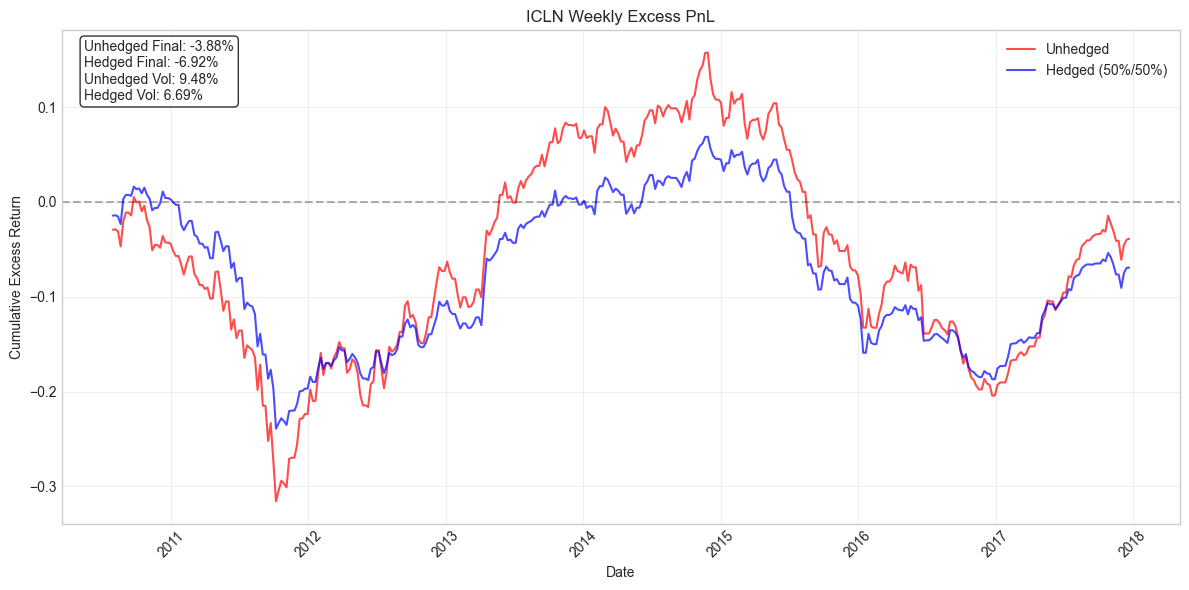

In [366]:
etf = "ICLN"
plot_weekly_excess_pnl_hmm(
    returns=renewable_df[etf],
    states=states_hmm[etf],
    bond_returns=bond_returns["SHY"],
    start_date="2010-01-01",
    end_date="2017-12-31",
    de_risk_med=champion_med,
    de_risk_high=champion_high,
    id2label=id2label[etf],
    title="ICLN Weekly Excess PnL"
)

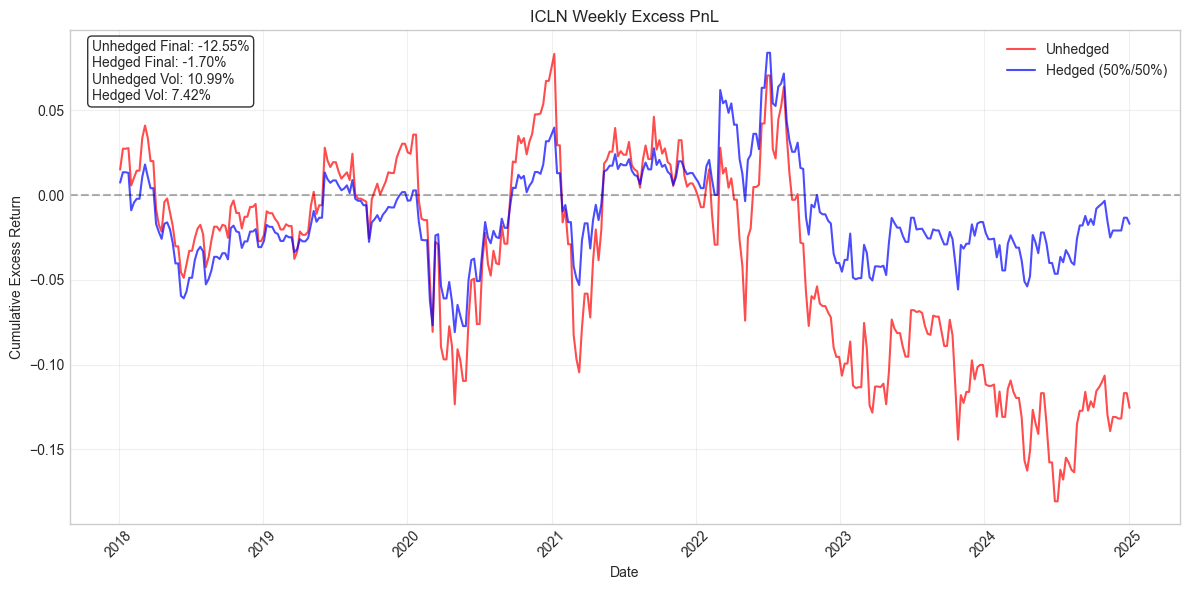

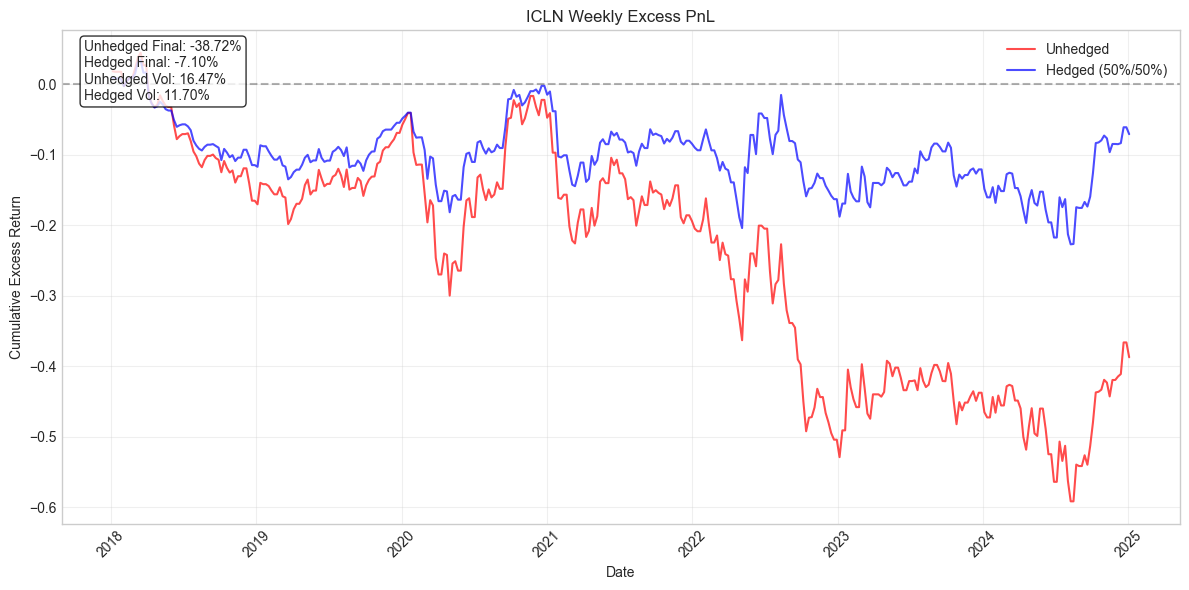

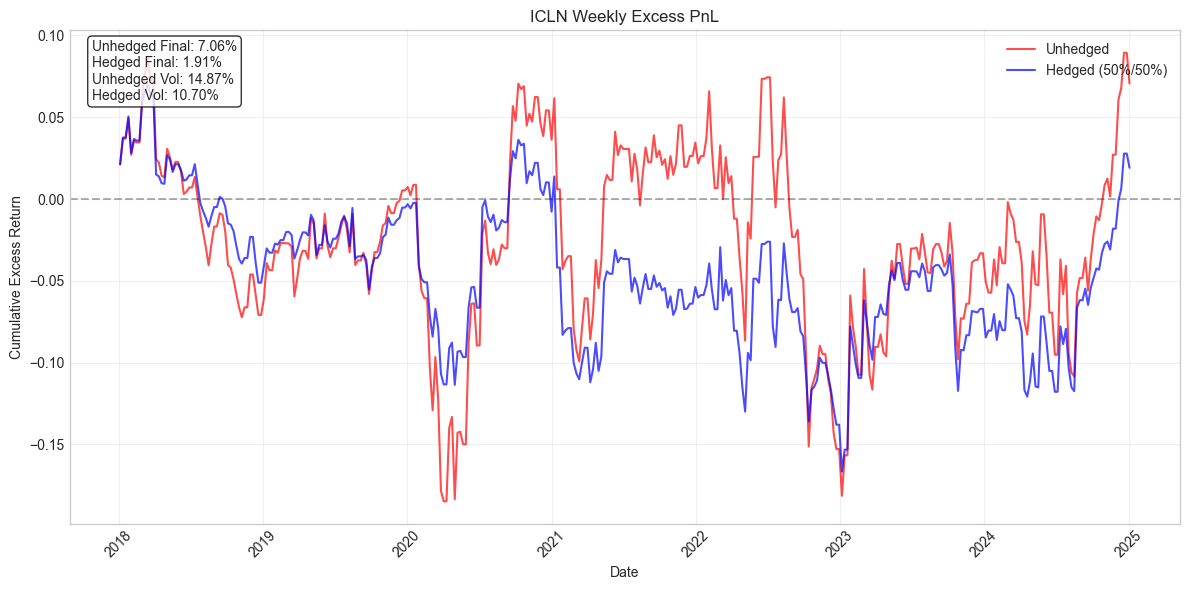

In [ ]:

start_date = "2018-01-01"
end_date = "2024-12-31"
champion_med = 0.50
champion_high = 0.50
etf = "ICLN"
plot_weekly_excess_pnl_hmm(
    returns=renewable_df[etf],
    states=states_hmm[etf],
    bond_returns=bond_returns["SHY"],
    start_date=start_date,
    end_date=end_date,
    de_risk_med=champion_med,
    de_risk_high=champion_high,
    id2label=id2label[etf],
    title="ICLN Weekly Excess PnL"
)

etf = "PBW"
plot_weekly_excess_pnl_hmm(
    returns=renewable_df[etf],
    states=states_hmm[etf],
    bond_returns=bond_returns["SHY"],
    start_date=start_date,
    end_date=end_date,
    de_risk_med=champion_med,
    de_risk_high=champion_high,
    id2label=id2label[etf],
    title="PBW Weekly Excess PnL"
)

etf = "QCLN"
plot_weekly_excess_pnl_hmm(
    returns=renewable_df[etf],
    states=states_hmm[etf],
    bond_returns=bond_returns["SHY"],
    start_date=start_date,
    end_date=end_date,
    de_risk_med=champion_med,
    de_risk_high=champion_high,
    id2label=id2label[etf],
    title="QCLN Weekly Excess PnL"
)

# Comparison to "placebo" (de-risking at random days)

In [378]:
import random

# ------------------------------------------------------------------ helpers
def _extract_blocks(label_series, active_set):
    """Return [(length, label), ...] for consecutive active blocks."""
    blocks, current_len = [], 0
    current_lbl = None

    for lbl in label_series:
        if lbl in active_set:
            if lbl == current_lbl:
                current_len += 1
            else:
                if current_len:
                    blocks.append((current_len, current_lbl))
                current_len, current_lbl = 1, lbl
        else:
            if current_len:
                blocks.append((current_len, current_lbl))
                current_len = 0
                current_lbl = None
    if current_len:
        blocks.append((current_len, current_lbl))
    return blocks


def _place_blocks_once(n_weeks, blocks, rng):
    """
    Attempt to lay down all blocks in random order. Returns a char array
    or None if no non-overlapping placement is possible.
    """
    out = np.full(n_weeks, "low", dtype=object)
    occupied = np.zeros(n_weeks, dtype=bool)

    # make a copy and shuffle in-place with stdlib.random (avoids dtype issues)
    blocks_shuffled = blocks.copy()
    random.shuffle(blocks_shuffled)

    for length, lbl in blocks_shuffled:
        length = int(length)                 # ensure numeric
        possible = np.where(~occupied)[0]
        possible = possible[possible <= n_weeks - length]
        possible = [p for p in possible if not occupied[p : p + length].any()]
        if not possible:
            return None
        start = rng.choice(possible)
        out[start : start + length] = lbl
        occupied[start : start + length] = True

    return out


def _place_blocks_randomly(n_weeks, blocks, rng):
    """
    Place blocks into an empty calendar of length n_weeks without overlap.
    Returns an array of labels ('low','med','high'), default 'low'.
    """
    out = np.full(n_weeks, "low", dtype=object)
    occupied = np.zeros(n_weeks, dtype=bool)

    for _, length, lbl in blocks:
        # find all start positions that fit
        possible = np.where(~occupied)[0]
        possible = possible[possible <= n_weeks - length]
        possible = [p for p in possible if not occupied[p : p + length].any()]
        start = rng.choice(possible)
        out[start : start + length] = lbl
        occupied[start : start + length] = True

    return out

def random_timing_schedules(label_series, n_draws=1000, seed=0):
    """
    Produce placebo schedules that (a) keep block lengths if possible,
    else (b) fall back to a simple random permutation of the weekly labels.
    """
    rng = np.random.default_rng(seed)
    is_numeric = np.issubdtype(label_series.dtype, np.number)
    active = {1, 2} if is_numeric else {"med", "high"}     # active states

    blocks = _extract_blocks(label_series, active)
    n_weeks = len(label_series)

    schedules = []

    for _ in range(n_draws):
        sched = None
        # up to 100 placement attempts
        for _try in range(100):
            sched = _place_blocks_once(n_weeks, blocks, rng)
            if sched is not None:
                break
        if sched is None:  # still no fit → fallback: permute whole vector
            sched = label_series.sample(frac=1, random_state=rng).values
        schedules.append(pd.Series(sched, index=label_series.index))

    return schedules


In [381]:

grid_df_ICLN_yearly_avg = period_sensitivity_averages_HMM(
    rets       = renewable_df["ICLN"],
    states     = states_hmm["ICLN"],
    bond_rets  = bond_returns["SHY"],
    start_date = "2018-01-01",
    end_date = "2024-12-31",
    med_list   = [0.25, 0.40, 0.60],
    high_list  = [0.50, 0.75, 0.90],
    id2label = id2label_ICLN,
) 
grid_df_ICLN_yearly_avg

De-risk Med (%)  De-risk High (%)  Avg Return Improve  Avg VaR Reduction  \
0               25                50           11.458020          29.169317   
1               25                75           -9.015530          37.219459   
2               25                90          -21.386507          38.376847   
3               40                50           41.927693          33.443054   
4               40                75           20.985120          43.006534   
5               40                90            8.333300          45.532142   
6               60                50           82.016856          42.238948   
7               60                75           61.307433          49.767044   
8               60                90           48.276813          52.951781   

   Avg CVaR Reduction  Avg MDD Reduction  Avg Sharpe Improve  \
0           24.400768          24.177140           16.538678   
1           29.050891          28.593627          -30.119989   
2           29.119642          30.148397          -60.049923   
3           30.696959          31.908627           89.366463   
4           35.379458          37.120313           45.072726   
5           35.678255          39.077848           14.006575   
6           37.466342          38.670536          201.837472   
7           42.897994          46.147699          168.699150   
8           43.383960          49.691012          138.107829   

   Avg Vol Reduction  Years Used  
0          24.586984           7  
1          29.592234           7  
2          31.232624           7  
3          29.618290           7  
4          34.988164           7  
5          36.741162           7  
6          35.013228           7  
7          40.873336           7  
8          42.780742           7

In [379]:
def overall_metrics(
    unhedged_returns: pd.Series,
    hedged_returns: pd.Series,
) -> dict:
    """
    Full-period hedge effectiveness.  All outputs are IMPROVEMENTS:
        +Return  +VaR/CVaR/MDD  +Sharpe  +Vol  ⇒ hedge is better.

    Parameters
    ----------
    unhedged_returns, hedged_returns : pd.Series
        Daily returns (decimal) with a common DatetimeIndex.

    Returns
    -------
    dict
        {
          'Return Improvement', 'VaR Reduction', 'CVaR Reduction',
          'Max Drawdown Reduction', 'Sharpe Ratio Improvement',
          'Volatility Reduction'
        }   # all in percent
    """
    # ── align ──────────────────────────────────────────────────────────────
    idx   = unhedged_returns.index.intersection(hedged_returns.index)
    raw   = unhedged_returns.loc[idx]
    hedg  = hedged_returns.loc[idx]


    # ── Now RESAMPLE TO WEEKLY ───────────────────────────────
    raw = raw.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)
    hedg = hedged.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)


    # ── performance & risk deltas ─────────────────────────────
    R_raw = raw.mean()
    R_hdg = heg.mean()
    return_improve = (R_hdg - R_raw) / abs(R_raw) * 100.0


    # ── VaR & CVaR (95 %) improvements ────────────────────────────────────
    var_raw, var_hdg = raw.quantile(0.05), hedg.quantile(0.05)
    cvar_raw = raw [raw  <= var_raw ].mean()
    cvar_hdg = hedg[hedg <= var_hdg].mean()

    var_improve  = (abs(var_raw)  - abs(var_hdg))  / abs(var_raw)  * 100.0
    cvar_improve = (abs(cvar_raw) - abs(cvar_hdg)) / abs(cvar_raw) * 100.0

    # ── Max-drawdown improvement ───────────────────────────────────────────
    def _mdd(r):
        path = (1 + r).cumprod()
        return (path / path.cummax() - 1).min()

    mdd_raw, mdd_hdg = _mdd(raw), _mdd(hedg)
    mdd_improve = (abs(mdd_raw) - abs(mdd_hdg)) / abs(mdd_raw) * 100.0

    # ── Sharpe improvement (rf = 0) ────────────────────────────────────────
    sharpe_raw = raw.mean()  / raw.std(ddof=0)  * np.sqrt(252)
    sharpe_hdg = hedg.mean() / hedg.std(ddof=0) * np.sqrt(252)
    sharpe_improve = (
        (sharpe_hdg - sharpe_raw) / abs(sharpe_raw) * 100.0
        if sharpe_raw != 0 else np.nan
    )

    # ── Volatility improvement ─────────────────────────────────────────────
    vol_improve = (raw.std(ddof=0) - hedg.std(ddof=0)) / raw.std(ddof=0) * 100.0

    return {
        "Return Improvement":       return_improve,
        "VaR Reduction":            var_improve,
        "CVaR Reduction":           cvar_improve,
        "Max Drawdown Reduction":   mdd_improve,
        "Sharpe Ratio Improvement": sharpe_improve,
        "Volatility Reduction":     vol_improve,
    }

In [227]:
grid_df_PBW_yearly_avg = period_sensitivity_averages_HMM(
    rets       = renewable_df["PBW"],
    states     = states_hmm["PBW"],
    bond_rets  = bond_returns["SHY"],
    start_date = "2018-01-01",
    end_date = "2024-12-31",
    med_list   = [0.25, 0.40, 0.60],
    high_list  = [0.50, 0.75, 0.90],
    id2label = id2label_PBW,
) 
grid_df_ICLN_yearly_avg

In [439]:
from itertools import product
import pandas as pd

# ------------------------------------------------------------------
# Parameter grid
med_grid  = [0.5]
high_grid = [0.50]
years_eval = list(range(2018, 2025))
n_draws = 1000                # placebo schedules per fund
start_date = "2018-01-01"
end_date = "2024-12-31"
# ------------------------------------------------------------------

# Mapping from numeric IDs to 'low/med/high' for each ETF
id2label = {
    "ICLN": id2label_ICLN,
    "PBW" : id2label_PBW,
    "QCLN": id2label_QCLN,
}

# Containers
emp_dist = {}        # will hold a DataFrame per ticker
real_grid = {}       # optional: store the real grid for each ticker
shed_all = {}

for ticker in ["ICLN", "PBW", "QCLN"]:
    # real grid (model timing) – useful for later comparison
    real_grid[ticker] = period_sensitivity_averages_HMM(
        rets      = renewable_df[ticker],
        states    = states_hmm[ticker],          # weekly HMM states
        bond_rets = bond_returns["SHY"],
        start_date = "2018-01-01",
        end_date = "2024-12-31",
        med_list  = med_grid,
        high_list = high_grid,
        id2label  = id2label[ticker],            # numeric → text
    )


    # numeric → 'low/med/high' for placebo generation
    state_str = states_hmm[ticker].map(id2label[ticker])

    placebo_tables = []
    for sched in random_timing_schedules(state_str, n_draws=n_draws):
        grid = period_sensitivity_averages_HMM(
            rets      = renewable_df[ticker],
            states    = sched,                   # placebo timing
            bond_rets = bond_returns["SHY"],
            start_date = "2018-01-01",
            end_date = "2024-12-31",
            med_list  = med_grid,
            high_list = high_grid,
            id2label  = None                     # already 'low/med/high'
        )
        grid["run_id"] = len(placebo_tables)
        placebo_tables.append(grid)

        
    # concatenate to one big empirical distribution
    emp_dist[ticker] = pd.concat(placebo_tables, ignore_index=True)



In [440]:
emp_dist["ICLN"].to_csv("random_derisk_ICLN.csv", index=True)
emp_dist["PBW"].to_csv("random_derisk_PBW.csv", index=True)
emp_dist["QCLN"].to_csv("random_derisk_QCLN.csv", index=True)

In [441]:
emp_dist["ICLN"]

De-risk Med (%)  De-risk High (%)  Avg Return Improve  Avg VaR Reduction  \
0                 50                50           84.076280          35.461395   
1                 50                50           10.738965          35.882210   
2                 50                50          -28.215948          36.955800   
3                 50                50           29.982501          37.479992   
4                 50                50          -14.244033          28.566595   
..               ...               ...                 ...                ...   
995               50                50           59.298714          39.427134   
996               50                50          -69.722943          24.725699   
997               50                50          -42.154104          35.809752   
998               50                50          -56.920905          38.843655   
999               50                50           20.691981          44.153164   

     Avg CVaR Reduction  Avg MDD Reduction  Avg Sharpe Improve  \
0             34.476577          34.326286          202.459046   
1             27.526122          28.888604          -16.722423   
2             16.731869          18.469544          -93.850390   
3             29.675169          31.947039           57.776163   
4             23.041413          23.942829          -61.177225   
..                  ...                ...                 ...   
995           28.416093          32.762254          138.600142   
996           17.164298          14.557521         -180.778531   
997           19.703921          25.683673         -129.388524   
998           25.879451          26.463823         -180.864648   
999           38.029786          36.181478           31.293689   

     Avg Vol Reduction  Years Used  run_id  
0            29.541449           7       0  
1            29.050729           7       1  
2            25.226855           7       2  
3            33.012108           7       3  
4            24.714535           7       4  
..                 ...         ...     ...  
995          32.965663           7     995  
996          26.349984           7     996  
997          29.052091           7     997  
998          29.765231           7     998  
999          34.820531           7     999  

[1000 rows x 10 columns]

In [442]:
import pandas as pd

def add_pvalues(real_grid, null_dist, metrics):
    out = real_grid.copy()
    for m in metrics:
        pvals = []
        for _, row in real_grid.iterrows():
            med, high = row["De-risk Med (%)"], row["De-risk High (%)"]
            real_val  = row[m]
            null_vals = null_dist.query(
                "`De-risk Med (%)`==@med and `De-risk High (%)`==@high"
            )[m]
            pvals.append((null_vals >= real_val).mean())   # one-sided
        out[f"{m} p"] = pvals
    return out

metrics = ["Avg Return Improve",
           "Avg VaR Reduction",
           "Avg CVaR Reduction",
           "Avg MDD Reduction",
           "Avg Vol Reduction"]

In [443]:
grid_icln_p = add_pvalues(real_grid["ICLN"], emp_dist["ICLN"], metrics)

# Show nicely
display(grid_icln_p.style.format("{:.2f}", subset=metrics)
                        .format("{:.2%}", subset=[f"{m} p" for m in metrics])
                        .background_gradient(subset=[f"{m} p" for m in metrics],
                                             cmap="RdYlGn_r", vmin=0, vmax=0.1))

In [470]:
print("ICLN")
print(grid_icln_p)  
print("PBW")
print(grid_PBW_p)
print("QCLN")
print(grid_QCLN_p)

ICLN
   De-risk Med (%)  De-risk High (%)  Avg Return Improve  Avg VaR Reduction  \
0               50                50           62.358493          37.420558   

   Avg CVaR Reduction  Avg MDD Reduction  Avg Sharpe Improve  \
0           34.401186          35.717714          144.445294   

   Avg Vol Reduction  Years Used  Avg Return Improve p  Avg VaR Reduction p  \
0          32.526628           7                 0.161                0.579   

   Avg CVaR Reduction p  Avg MDD Reduction p  Avg Vol Reduction p  
0                 0.135                0.153                0.219  
PBW
   De-risk Med (%)  De-risk High (%)  Avg Return Improve  Avg VaR Reduction  \
0               50                50           57.964024          37.377226   

   Avg CVaR Reduction  Avg MDD Reduction  Avg Sharpe Improve  \
0           29.474189          33.296397            92.24023   

   Avg Vol Reduction  Years Used  Avg Return Improve p  Avg VaR Reduction p  \
0          28.923346           7         

In [444]:
grid_PBW_p = add_pvalues(real_grid["PBW"], emp_dist["PBW"], metrics)

# Show nicely
display(grid_PBW_p.style.format("{:.2f}", subset=metrics)
                        .format("{:.2%}", subset=[f"{m} p" for m in metrics])
                        .background_gradient(subset=[f"{m} p" for m in metrics],
                                             cmap="RdYlGn_r", vmin=0, vmax=0.1))

In [445]:
grid_QCLN_p = add_pvalues(real_grid["QCLN"], emp_dist["QCLN"], metrics)

# Show nicely
display(grid_QCLN_p.style.format("{:.2f}", subset=metrics)
                        .format("{:.2%}", subset=[f"{m} p" for m in metrics])
                        .background_gradient(subset=[f"{m} p" for m in metrics],
                                             cmap="RdYlGn_r", vmin=0, vmax=0.1))

# Even simpler placebo (no clustering)

In [446]:
def shuffle_timing_schedules(label_series, n_draws=1000, seed=0):
    """
    Fast placebo generator that keeps the same number of 'low','med','high'
    labels but randomly permutes their order (one draw per permutation).
    """
    rng = np.random.default_rng(seed)
    arr = label_series.values
    schedules = []
    for _ in range(n_draws):
        shuffled = rng.permutation(arr)
        schedules.append(pd.Series(shuffled, index=label_series.index))
    return schedules


In [451]:
# ------------------------------------------------------------------
# Parameter grid
med_grid  = [0.5]
high_grid = [0.50]
years_eval = list(range(2018, 2025))
n_draws = 1000                 # placebo schedules per fund
# ------------------------------------------------------------------

# Containers
emp_dist_shuffle = {}        # will hold a DataFrame per ticker

for ticker in ["ICLN", "PBW", "QCLN"]:
    placebo_tables = []
    for sched in shuffle_timing_schedules(state_str, n_draws=100):
        grid = period_sensitivity_averages_HMM(
            rets      = renewable_df[ticker],
            states    = sched,                   # placebo timing
            bond_rets = bond_returns["SHY"],
            start_date = "2018-01-01",
            end_date = "2024-12-31",
            med_list  = med_grid,
            high_list = high_grid,
            id2label  = None                     # already 'low/med/high'
        )
        grid["run_id"] = len(placebo_tables)
        placebo_tables.append(grid)

    # concatenate to one big empirical distribution
    emp_dist_shuffle[ticker] = pd.concat(placebo_tables, ignore_index=True)



In [452]:
grid_ICLN_p_shuffle = add_pvalues(real_grid["ICLN"], emp_dist_shuffle["ICLN"], metrics)

# Show nicely
display(grid_ICLN_p_shuffle.style.format("{:.2f}", subset=metrics)
                        .format("{:.2%}", subset=[f"{m} p" for m in metrics])
                        .background_gradient(subset=[f"{m} p" for m in metrics],
                                             cmap="RdYlGn_r", vmin=0, vmax=0.1))

In [453]:
grid_PBW_p_shuffle = add_pvalues(real_grid["PBW"], emp_dist_shuffle["PBW"], metrics)

# Show nicely
display(grid_PBW_p_shuffle.style.format("{:.2f}", subset=metrics)
                        .format("{:.2%}", subset=[f"{m} p" for m in metrics])
                        .background_gradient(subset=[f"{m} p" for m in metrics],
                                             cmap="RdYlGn_r", vmin=0, vmax=0.1))

In [458]:
states_hmm["QCLN"].value_counts()

QCLN
1    257
0    248
2    248
Name: count, dtype: int64

In [454]:
grid_QCLN_p_shuffle = add_pvalues(real_grid["QCLN"], emp_dist_shuffle["QCLN"], metrics)

# Show nicely
display(grid_QCLN_p_shuffle.style.format("{:.2f}", subset=metrics)
                        .format("{:.2%}", subset=[f"{m} p" for m in metrics])
                        .background_gradient(subset=[f"{m} p" for m in metrics],
                                             cmap="RdYlGn_r", vmin=0, vmax=0.1))

In [270]:
real_grid["QCLN"]

De-risk Med (%)  De-risk High (%)  Avg Return Improve  Avg VaR Reduction  \
0               25                50           -0.100396          22.162800   
1               25                75           -0.242481          24.094436   
2               25                90           -0.316324          24.094436   
3               40                50            0.027014          29.776645   
4               40                75           -0.121748          32.286605   
5               40                90           -0.199416          32.286605   
6               60                50            0.183712          36.490971   
7               60                75            0.025858          41.906164   
8               60                90           -0.057035          41.906164   

   Avg CVaR Reduction  Avg MDD Reduction  Avg Sharpe Improve  \
0           19.074599          18.966658         -397.304813   
1           19.685564          19.782032         -879.830903   
2           19.685564          20.087161        -1171.282632   
3           24.220202          23.726790          -79.092617   
4           25.056199          24.722783         -581.730068   
5           25.056199          25.008944         -886.807235   
6           27.050177          27.648185          389.636515   
7           27.886175          30.289108         -134.194916   
8           27.886175          30.557424         -454.522703   

   Avg Vol Reduction  Years Used  
0          20.560651           7  
1          23.900414           7  
2          24.867936           7  
3          25.508646           7  
4          29.074872           7  
5          30.110726           7  
6          30.745772           7  
7          34.590075           7  
8          35.710813           7

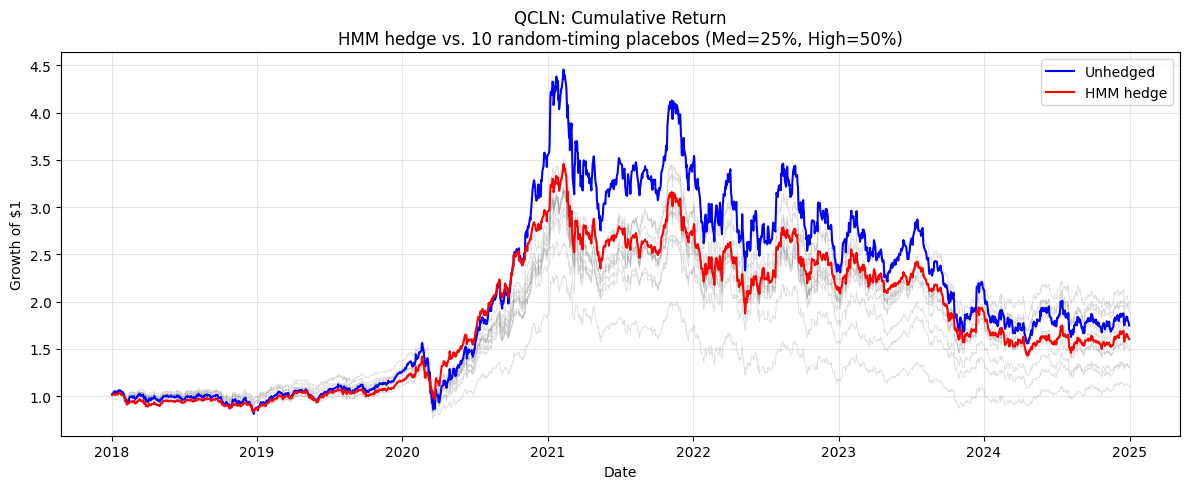

In [295]:
# ─────────────────────────────────────────────────────────────────────────────
# 1.  helper: clustered placebo schedules
# ─────────────────────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd
import random
from dataclasses import dataclass

@dataclass
class Seg:
    start: int
    length: int

def random_timing_schedules(label_series: pd.Series,
                         n_draws: int = 100,
                         seed: int = 0):
    """
    Faster clustered placebo generator.
    Keeps every (run-length, label) pair but relocates them.
    """
    rng = np.random.default_rng(seed)

    # -------- extract (length, label) blocks ------------------------------
    blocks, cur_lbl, cur_len = [], None, 0
    for lbl in label_series:
        if lbl == cur_lbl:
            cur_len += 1
        else:
            if cur_len:
                blocks.append((cur_len, cur_lbl))
            cur_lbl, cur_len = lbl, 1
    blocks.append((cur_len, cur_lbl))

    n = len(label_series)
    schedules = []

    for _ in range(n_draws):
        out = np.full(n, "low", dtype=object)
        free = [Seg(0, n)]                              # one big free segment

        # shuffle block order once per draw
        blocks_shuf = blocks.copy()
        random.shuffle(blocks_shuf)

        for length, lbl in blocks_shuf:
            length = int(length)

            # pick a random *segment* that can fit the block
            big_enough = [seg for seg in free if seg.length >= length]
            if not big_enough:                          # pathological: fallback
                rng.shuffle(out)                        # scatter labels randomly
                break

            seg = rng.choice(big_enough)
            free.remove(seg)

            # choose random offset inside that segment
            offset = rng.integers(0, seg.length - length + 1)
            start = seg.start + offset
            out[start : start + length] = lbl

            # push back leftover left / right pieces
            if offset:                      # left remainder
                free.append(Seg(seg.start, offset))
            right_len = seg.length - offset - length
            if right_len:
                free.append(Seg(start + length, right_len))

        schedules.append(pd.Series(out, index=label_series.index, name="state"))

    return schedules


# ─────────────────────────────────────────────────────────────────────────────
# 2.  plotting routine
# ─────────────────────────────────────────────────────────────────────────────
def plot_placebo_vs_real(
    equity_ret   : pd.Series,
    bond_ret     : pd.Series,
    state_series : pd.Series,         # weekly HMM states (numeric or text)
    *,
    id2label     : dict[int, str],
    de_risk_med  : float,
    de_risk_high : float,
    n_draws      : int = 100,
    seed         : int = 0,
    ticker       : str = "",
    figsize      : tuple = (12, 5)
):
    """
    Draw cumulative return curves:
      • unhedged (blue)
      • HMM-timed hedge (red)
      • n placebo hedges (thin grey)
    """

    # ── ensure monotonic indexes ------------------------------------------
    equity_ret   = equity_ret.sort_index()
    bond_ret     = bond_ret.sort_index()
    state_series = state_series.sort_index()

    # ── real hedge ---------------------------------------------------------
    hedged_real = hedge_by_hmm_state(
        equity_ret   = equity_ret,
        state_series = state_series,
        safe_ret     = bond_ret,
        de_risk_med  = de_risk_med,
        de_risk_high = de_risk_high,
        id2label     = id2label,
    )
    cum_raw  = (1 + equity_ret).cumprod()
    cum_real = (1 + hedged_real).cumprod()

    # ── generate placebo hedges -------------------------------------------
    state_txt = state_series.map(id2label) if id2label else state_series
    placebos  = random_timing_schedules(state_txt, n_draws=n_draws, seed=seed)

    cum_placebos = []
    for sched in placebos:
        hedged_fake = hedge_by_hmm_state(
            equity_ret   = equity_ret,
            state_series = sched,          # already sorted
            safe_ret     = bond_ret,
            de_risk_med  = de_risk_med,
            de_risk_high = de_risk_high,
            id2label     = None            # labels already text
        )
        cum_placebos.append((1 + hedged_fake).cumprod())

    # ── plot ---------------------------------------------------------------
    plt.figure(figsize=figsize)
    for s in cum_placebos:
        plt.plot(s.index, s, color="grey", alpha=0.25, linewidth=0.7)

    plt.plot(cum_raw.index,  cum_raw,  color="blue", label="Unhedged")
    plt.plot(cum_real.index, cum_real, color="red",  label="HMM hedge")

    plt.title(f"{ticker}: Cumulative Return\n"
              f"HMM hedge vs. {n_draws} random-timing placebos "
              f"(Med={int(de_risk_med*100)}%, High={int(de_risk_high*100)}%)")
    plt.ylabel("Growth of $1")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 3.  example call  (change ticker / weights as desired)
# ─────────────────────────────────────────────────────────────────────────────
# choose your window
time_start = "2018-01-01"
time_end   = "2024-12-31"
etf = "QCLN"

# 1) slice every daily series
eq   = renewable_df[etf].loc[time_start:time_end]
bond = bond_returns["SHY"].loc[time_start:time_end]

# 2) slice the weekly-state series
states_week = states_hmm[etf].loc[time_start:time_end]

# 3) run the placebo / plot on that window only
plot_placebo_vs_real(
    equity_ret   = eq,
    bond_ret     = bond,
    state_series = states_week,
    id2label     = id2label[etf],
    de_risk_med  = 0.25,
    de_risk_high = 0.5,
    n_draws      = 10,
    seed         = 1,
    ticker       = etf
)

# NOT WORKING

In [ ]:
def run_hmm_hedging_strategy(ticker,
                           start_train='2010-01-01',
                           end_train='2015-12-31',
                           start_test='2016-01-01',
                           end_full='2020-12-31',
                           forecast_horizon=22,
                           rolling_window=750,
                           n_states=3,
                           de_risk_high=0.50,
                           de_risk_medium=0.25,
                           de_risk_low=0.00,
                           hmm_iterations=100,
                           hmm_tolerance=1e-2,
                           random_state=0):
    """Main function to run HMM-based hedging strategy."""

    # Compute volatility
    ret_full, realized_vol_full = compute_realized_volatility(
        renewable_df, ticker, start_train, end_full, forecast_horizon)

    # Get HMM states
    states_series = rolling_hmm_states(
        realized_vol_full, rolling_window, n_states,
        hmm_iterations, hmm_tolerance, random_state)

    # Identify states
    sorted_states = get_state_means(
        realized_vol_full, rolling_window, n_states,
        hmm_iterations, hmm_tolerance, random_state)
    low_vol_state, medium_vol_state, high_vol_state = sorted_states

    # Plot states
    plot_volatility_states(realized_vol_full, states_series, ticker, n_states)

    # Apply hedging
    raw_returns = ret_full.loc[states_series.index]
    hedged_returns = apply_hedging_strategy(
        raw_returns, states_series, de_risk_high, de_risk_medium, de_risk_low,
        high_vol_state, medium_vol_state, low_vol_state)

    # Get test period returns
    test_returns = raw_returns.loc[start_test:end_full]
    test_hedged = hedged_returns.loc[start_test:end_full]

    # Plot cumulative returns
    final_orig, final_hedged = plot_cumulative_returns(test_returns, test_hedged, ticker)

    # Compute risk metrics
    metrics_comparison = compute_risk_metrics(test_returns, test_hedged)
    print("\nRisk Metrics Comparisondates:")
    print(metrics_comparison)

    # Return results
    return {
        'ticker': ticker,
        'states_series': states_series,
        'raw_returns': raw_returns,
        'hedged_returns': hedged_returns,
        'metrics_comparison': metrics_comparison,
        'final_returns': {
            'original': final_orig,
            'hedged': final_hedged
        },
        'state_means': {
            'low': sorted_states[0],
            'medium': sorted_states[1],
            'high': sorted_states[2]
        }
    }

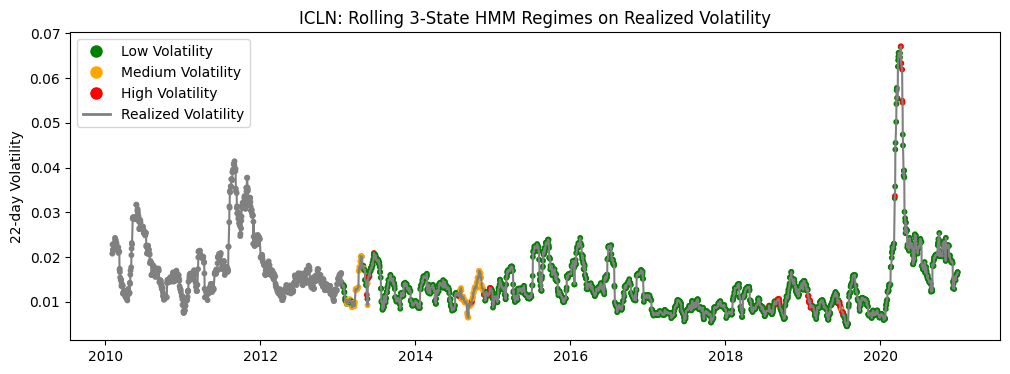

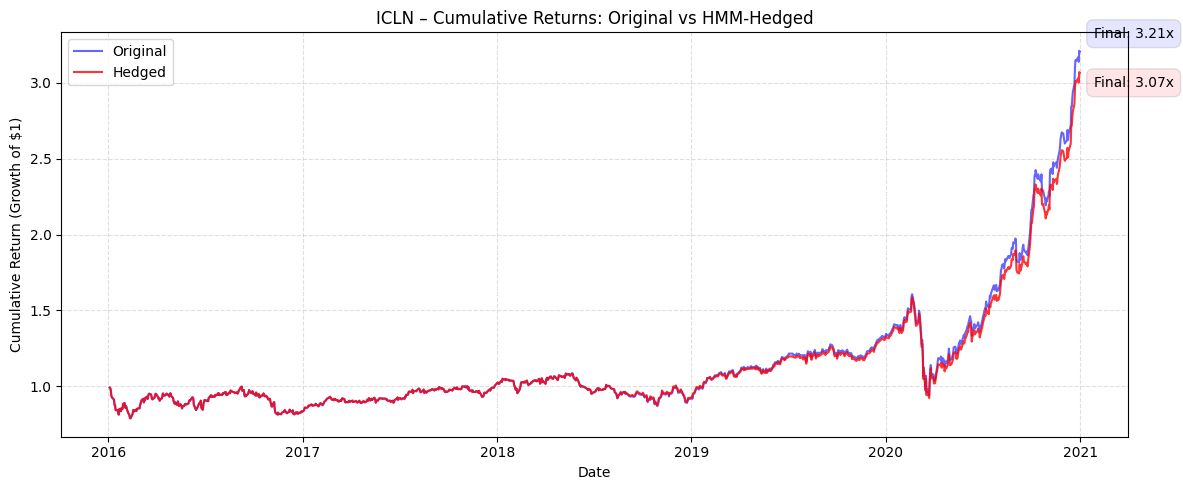


Risk Metrics Comparison:
              Original  Hedged  Percent Change (%)
VaR (95%)      -0.0206 -0.0206             -0.0000
CVaR (95%)     -0.0369 -0.0368             -0.3400
Max Drawdown    0.1841  0.1841              0.0000


In [ ]:
# Example usage:
results = run_hmm_hedging_strategy('ICLN',
                                  start_train='2010-01-01',
                                  end_train='2015-12-31',
                                  start_test='2016-01-01',
                                  end_full='2020-12-31',
                                  forecast_horizon=22,
                                  rolling_window=500,
                                  n_states=3,
                                  de_risk_high=0.66,
                                  de_risk_medium=0.33,
                                  de_risk_low=0.00)

# GARCH signal Options Hedging (will probably drop this, struggling with Options Data currently)

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# Parameters
rolling_window = 500
forecast_horizon = 22
de_risk_pct = 0.5
percentile_threshold = 0.9

# Restrict data to 2008–2019
renewable_df.index = pd.to_datetime(renewable_df.index)
renewable_subset = renewable_df.loc["2008":"2019"]

hedged_returns = {}
hedge_log = {}  # Store decision logs
hedge_trigger_dates_dict = {}  # NEW: stores dates with hedge activation

for col in renewable_subset.columns:
    print(f"Processing {col}...")
    returns = renewable_subset[col].dropna() * 100
    forecast_vols = []
    decisions = []
    hedge_dates = []

    for i in range(rolling_window, len(returns) - forecast_horizon):
        window = returns.iloc[i - rolling_window:i]
        model = arch_model(window, vol='Garch', p=1, q=1)
        try:
            res = model.fit(disp="off")
            forecast = res.forecast(horizon=forecast_horizon)
            avg_vol = np.mean(np.sqrt(forecast.variance.values[-1]) / 100)
            forecast_vols.append(avg_vol)
        except:
            forecast_vols.append(np.nan)

    valid_index = returns.index[rolling_window:-forecast_horizon]
    vol_signal = pd.Series(forecast_vols, index=valid_index)
    threshold = vol_signal.quantile(percentile_threshold)

    raw_returns = returns.loc[valid_index] / 100
    hedged = raw_returns.copy()

    for date in valid_index:
        vol = vol_signal.loc[date]
        if vol > threshold:
            decision = f"{date.date()}: De-risked (Vol={vol:.4f} > {threshold:.4f})"
            hedged.loc[date] *= (1 - de_risk_pct)
            hedge_dates.append(date)  # store hedge activation date
        else:
            decision = f"{date.date()}: Full exposure (Vol={vol:.4f} <= {threshold:.4f})"
        decisions.append(decision)

    hedged_returns[col] = hedged
    hedge_log[col] = decisions


In [ ]:
one_month_sql = """
SELECT  o.date,
        o.exdate,
        o.cp_flag,
        o.strike_price/1000.0  AS strike,
        o.best_bid   AS bid,
        o.best_offer AS ask,
        o.volume
FROM    optionm.opprcd2010   o
JOIN    optionm.secnmd       s  USING (secid)
WHERE   s.ticker = 'PBW'
  AND   o.date     BETWEEN '2010-01-01' AND '2010-12-01'
  AND   (o.exdate - o.date) BETWEEN 10 AND 100
  LIMIT 1000;
"""

df = conn.raw_sql(one_month_sql, date_cols=["date", "exdate"])
print(df.head(), f"\n{len(df)} rows returned")

In [ ]:
hedge_trigger_dates = pd.read_csv("hedge_trigger_dates.txt", index_col="date", parse_dates=True)
hedge_trigger_dates

ValueError: 'date' is not in list

In [ ]:
def get_best_put_option(conn, date, symbol="PBW", secid=13541):
    year = date.year
    try:
        sql = f"""
        SELECT o.date, o.exdate, o.strike_price/1000.0 AS strike,
               o.best_bid, o.best_offer, o.cp_flag
        FROM optionm.opprcd{year} o
        JOIN optionm.secnmd s USING (secid)
        WHERE s.ticker = '{symbol}'
          AND o.cp_flag = 'P'
          AND o.date = '{date.strftime('%Y-%m-%d')}'
          AND (o.exdate - o.date) BETWEEN 25 AND 35
          AND o.best_bid IS NOT NULL AND o.best_offer IS NOT NULL
        """
        options_df = conn.raw_sql(sql, date_cols=["date", "exdate"])
        if options_df.empty:
            return None

        # Load ETF price series (e.g., cumulative PBW price path)
        S0 = (1 + renewable_df[symbol]).cumprod().loc[date]
        options_df["mid"] = (options_df["best_bid"] + options_df["best_offer"]) / 2
        options_df["moneyness"] = options_df["strike"] / S0

        candidates = options_df[(options_df["moneyness"] >= 0.95) & (options_df["moneyness"] <= 1.00)]
        if candidates.empty:
            return None

        best = candidates.iloc[(candidates["moneyness"] - 0.975).abs().argsort()].iloc[0]
        return {
            "cost": best["mid"] / S0,
            "strike": best["strike"],
            "expiry": best["exdate"],
            "spot": S0
        }
    except Exception as e:
        print(f"Option lookup failed for {date.date()}: {e}")
        return None


In [ ]:
conn = wrds.Connection(wrds_username='simengut')

# Parameters
rolling_window = 500
forecast_horizon = 22
percentile_threshold = 0.9

# Restrict data to 2008–2019
renewable_df.index = pd.to_datetime(renewable_df.index)
renewable_subset = renewable_df.loc["2008":"2019"]

hedged_returns = {}
hedge_log = {}  # Store decision logs

for col in renewable_subset.columns:
    print(f"Processing {col}...")
    returns = renewable_subset[col].dropna() * 100
    forecast_vols = []
    decisions = []
    hedge_dates = []

    for i in range(rolling_window, len(returns) - forecast_horizon):
        window = returns.iloc[i - rolling_window:i]
        model = arch_model(window, vol='Garch', p=1, q=1)
        try:
            res = model.fit(disp="off")
            forecast = res.forecast(horizon=forecast_horizon)
            avg_vol = np.mean(np.sqrt(forecast.variance.values[-1]) / 100)
            forecast_vols.append(avg_vol)
        except:
            forecast_vols.append(np.nan)

    valid_index = returns.index[rolling_window:-forecast_horizon]
    vol_signal = pd.Series(forecast_vols, index=valid_index)
    threshold = vol_signal.quantile(percentile_threshold)

    raw_returns = returns.loc[valid_index] / 100
    hedged = raw_returns.copy()

    for date in valid_index:
        vol = vol_signal.loc[date]

        if vol > threshold:
            decision = f"{date.date()}: Hedged (Vol={vol:.4f} > {threshold:.4f})"

            option = get_best_put_option(conn, date, symbol=col)
            if option:
                cost = option["cost"]
                hedged.loc[date] -= cost

                expiry = option["expiry"]
                strike = option["strike"]
                spot = option["spot"]

                # Save expiry payoff for later (optional: store for final post-loop adjustment)
                if expiry in renewable_df.index:
                    ST = (1 + renewable_df[col]).cumprod().loc[expiry]
                    payoff = max(0, strike - ST) / spot
                    hedged.loc[expiry] += payoff

            hedge_dates.append(date)



            hedge_dates.append(date)  # store hedge activation da
        else:
            decision = f"{date.date()}: Full exposure (Vol={vol:.4f} <= {threshold:.4f})"
        decisions.append(decision)

    hedged_returns[col] = hedged
    hedge_log[col] = decisions
    hedge_trigger_dates_dict[col] = hedge_dates  # save hedge dates per ETF

# Save returns
hedged_renewable_df = pd.DataFrame(hedged_returns)
hedged_renewable_df.to_csv("renewable_hedged_returns.csv")


Loading library list...
Done
Processing ICLN...


KeyboardInterrupt: 

# Compare GARCH and HMM 

In [552]:
print("HMM test")
print("ICLN")
print(grid_ICLN_stats_test)
print("PBW")
print(grid_PBW_stats_test)
print("QCLN")
print(grid_QCLN_stats_test)


HMM test
ICLN
        Strategy  De-risk Med (%)  De-risk High (%)  Avg Weekly Return  \
0       Unhedged              NaN               NaN          -0.000343   
1  Hedged 50/50%             50.0              50.0          -0.000070   

   VaR (5%)  CVaR (5%)  Max Drawdown  Sharpe Ratio  Volatility  
0 -0.025996  -0.036258     -0.251370      -0.16211    0.109949  
1 -0.016028  -0.023572     -0.134747      -0.04883    0.074136  
PBW
        Strategy  De-risk Med (%)  De-risk High (%)  Avg Weekly Return  \
0       Unhedged              NaN               NaN          -0.001058   
1  Hedged 50/50%             50.0              50.0          -0.000215   

   VaR (5%)  CVaR (5%)  Max Drawdown  Sharpe Ratio  Volatility  
0 -0.039153  -0.050314     -0.516025     -0.334087    0.164678  
1 -0.025367  -0.033349     -0.268152     -0.095716    0.116967  
QCLN
        Strategy  De-risk Med (%)  De-risk High (%)  Avg Weekly Return  \
0       Unhedged              NaN               NaN           0.000

In [535]:
#hmm
# grid_PBW_stats_test

Strategy  De-risk Med (%)  De-risk High (%)  Avg Weekly Return  \
0       Unhedged              NaN               NaN          -0.001058   
1  Hedged 50/50%             50.0              50.0          -0.000215   

   VaR (5%)  CVaR (5%)  Max Drawdown  Sharpe Ratio  Volatility  
0 -0.039153  -0.050314     -0.516025     -0.334087    0.164678  
1 -0.025367  -0.033349     -0.268152     -0.095716    0.116967

In [536]:
grid_ICLN_stats_test

Strategy  De-risk Med (%)  De-risk High (%)  Avg Weekly Return  \
0       Unhedged              NaN               NaN          -0.000343   
1  Hedged 50/50%             50.0              50.0          -0.000070   

   VaR (5%)  CVaR (5%)  Max Drawdown  Sharpe Ratio  Volatility  
0 -0.025996  -0.036258     -0.251370      -0.16211    0.109949  
1 -0.016028  -0.023572     -0.134747      -0.04883    0.074136

In [554]:
etf = "ICLN"
# ──────────────────────────────────────────────────────
garch_ICLN = single_period_stats_GARCH_weekly(
    renewable_df[etf],
    garch_forecast[etf],    
    bond_returns["SHY"],
    "2018-01-01",
    "2024-12-31",
    0.5,
    0.5,
)
etf = "PBW"
# ──────────────────────────────────────────────────────
garch_PBW = single_period_stats_GARCH_weekly(
    renewable_df[etf],
    garch_forecast[etf],    
    bond_returns["SHY"],
    "2018-01-01",
    "2024-12-31",
    0.5,
    0.5,
)
etf = "QCLN"
# ──────────────────────────────────────────────────────
garch_QCLN = single_period_stats_GARCH_weekly(
    renewable_df[etf],
    garch_forecast[etf],    
    bond_returns["SHY"],
    "2018-01-01",
    "2024-12-31",
    0.5,
    0.5,
)
print("GARCH test")
print("ICLN")
print(garch_ICLN)
print("PBW")
print(garch_PBW)
print("QCLN")
print(garch_QCLN)


GARCH test
ICLN
{'Avg Weekly Return': 0.0010181062191825978, 'VaR (5%)': -0.041309139589406185, 'CVaR (5%)': -0.05546118858898718, 'Max Drawdown': -0.470233273697372, 'Sharpe Ratio': 0.2889602023269021, 'Volatility': 0.1832138923324883}
PBW
{'Avg Weekly Return': 0.001220243350116183, 'VaR (5%)': -0.047644633852852225, 'CVaR (5%)': -0.06396424650433453, 'Max Drawdown': -0.5737441320801506, 'Sharpe Ratio': 0.2684663075170531, 'Volatility': 0.2363523929423098}
QCLN
{'Avg Weekly Return': 0.001788029107679383, 'VaR (5%)': -0.04322668198444543, 'CVaR (5%)': -0.05954442519363088, 'Max Drawdown': -0.39760491458014324, 'Sharpe Ratio': 0.4318701777214625, 'Volatility': 0.21529042382568578}


In [546]:
hmm_ICLN

{'Avg Weekly Return': 0.0010181062191825978,
 'VaR (5%)': -0.041309139589406185,
 'CVaR (5%)': -0.05546118858898718,
 'Max Drawdown': -0.470233273697372,
 'Sharpe Ratio': 0.2889602023269021,
 'Volatility': 0.1832138923324883}

In [555]:
def plot_weekly_pnl_comparison(
    returns: pd.Series,
    bond_returns: pd.Series,
    garch_forecast: pd.Series,
    hmm_states: pd.Series,
    start_date: str,
    end_date: str,
    garch_vol_thr: float,
    garch_de_risk: float,
    hmm_de_risk_med: float,
    hmm_de_risk_high: float,
    id2label: dict[int, str] | None = None,
    title: str | None = None,
) -> None:
    """
    Plot cumulative returns with weekly resets comparing unhedged, GARCH-hedged, and HMM-hedged strategies.
    
    Parameters
    ----------
    returns : pd.Series
        Daily equity returns
    bond_returns : pd.Series
        Daily bond returns
    garch_forecast : pd.Series
        GARCH volatility forecasts
    hmm_states : pd.Series
        HMM states
    start_date, end_date : str
        Date range for analysis in 'YYYY-MM-DD' format
    garch_vol_thr : float
        Volatility threshold for GARCH strategy
    garch_de_risk : float
        De-risking percentage for GARCH strategy
    hmm_de_risk_med, hmm_de_risk_high : float
        De-risking percentages for medium and high volatility states in HMM strategy
    id2label : dict[int, str] | None
        Mapping of state IDs to labels for HMM
    title : str | None
        Optional plot title
    """
    
    # Align and filter data
    common_idx = returns.index.intersection(hmm_states.index).intersection(bond_returns.index).intersection(garch_forecast.index)
    rets = returns.loc[common_idx]
    hmm_states = hmm_states.loc[common_idx]
    bonds = bond_returns.loc[common_idx]
    garch_vol = garch_forecast.loc[common_idx]
    
    # Filter by date range
    mask = (rets.index >= start_date) & (rets.index <= end_date)
    rets = rets[mask]
    hmm_states = hmm_states[mask]
    bonds = bonds[mask]
    garch_vol = garch_vol[mask]
    
    # Get hedged returns for both strategies
    hmm_hedged_daily = hedge_by_hmm_state(
        equity_ret=rets,
        state_series=hmm_states,
        safe_ret=bonds,
        de_risk_med=hmm_de_risk_med,
        de_risk_high=hmm_de_risk_high,
        id2label=id2label
    )
    
    garch_hedged_daily = compute_hedged_returns(
        rets,
        garch_vol,
        bonds,
        garch_vol_thr,
        garch_de_risk
    )
    
    # Convert to weekly returns
    raw_weekly = rets.resample('W-FRI').agg(lambda x: (1 + x).prod() - 1)
    hmm_weekly = hmm_hedged_daily.resample('W-FRI').agg(lambda x: (1 + x).prod() - 1)
    garch_weekly = garch_hedged_daily.resample('W-FRI').agg(lambda x: (1 + x).prod() - 1)
    
    # Cumulate the returns
    raw_cum = pd.Series(0, index=raw_weekly.index)
    hmm_cum = pd.Series(0, index=hmm_weekly.index)
    garch_cum = pd.Series(0, index=garch_weekly.index)
    
    for i in range(len(raw_weekly)):
        if i == 0:
            raw_cum.iloc[i] = raw_weekly.iloc[i]
            hmm_cum.iloc[i] = hmm_weekly.iloc[i]
            garch_cum.iloc[i] = garch_weekly.iloc[i]
        else:
            raw_cum.iloc[i] = raw_cum.iloc[i-1] + raw_weekly.iloc[i]
            hmm_cum.iloc[i] = hmm_cum.iloc[i-1] + hmm_weekly.iloc[i]
            garch_cum.iloc[i] = garch_cum.iloc[i-1] + garch_weekly.iloc[i]
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Plot cumulative returns
# Plot cumulative returns
    plt.plot(raw_cum.index, raw_cum.values, 
        label='Unhedged', color='grey', alpha=0.7, linestyle='--')
    plt.plot(garch_cum.index, garch_cum.values, 
            label=f'GARCH ({int(garch_vol_thr*100)}%/{int(garch_de_risk*100)}%)', 
            color='blue', alpha=0.7)
    plt.plot(hmm_cum.index, hmm_cum.values, 
            label=f'HMM ({int(hmm_de_risk_med*100)}%/{int(hmm_de_risk_high*100)}%)', 
            color='green', alpha=0.7)
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # Formatting
    if title is None:
        title = f'Strategy Comparison: Cumulative Returns (Weekly Reset)\n{start_date} to {end_date}'
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    
    # Add legend
    plt.legend(loc="upper right")
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add summary statistics
    stats_text = (
        f'Unhedged Final: {raw_cum.iloc[-1]:.2%}\n'
        f'GARCH Final: {garch_cum.iloc[-1]:.2%}\n'
        f'HMM Final: {hmm_cum.iloc[-1]:.2%}\n'
        f'Unhedged Vol: {np.std(raw_weekly)*np.sqrt(52):.2%}\n'
        f'GARCH Vol: {np.std(garch_weekly)*np.sqrt(52):.2%}\n'
        f'HMM Vol: {np.std(hmm_weekly)*np.sqrt(52):.2%}'
    )
    
    # Position the text box in the top left
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

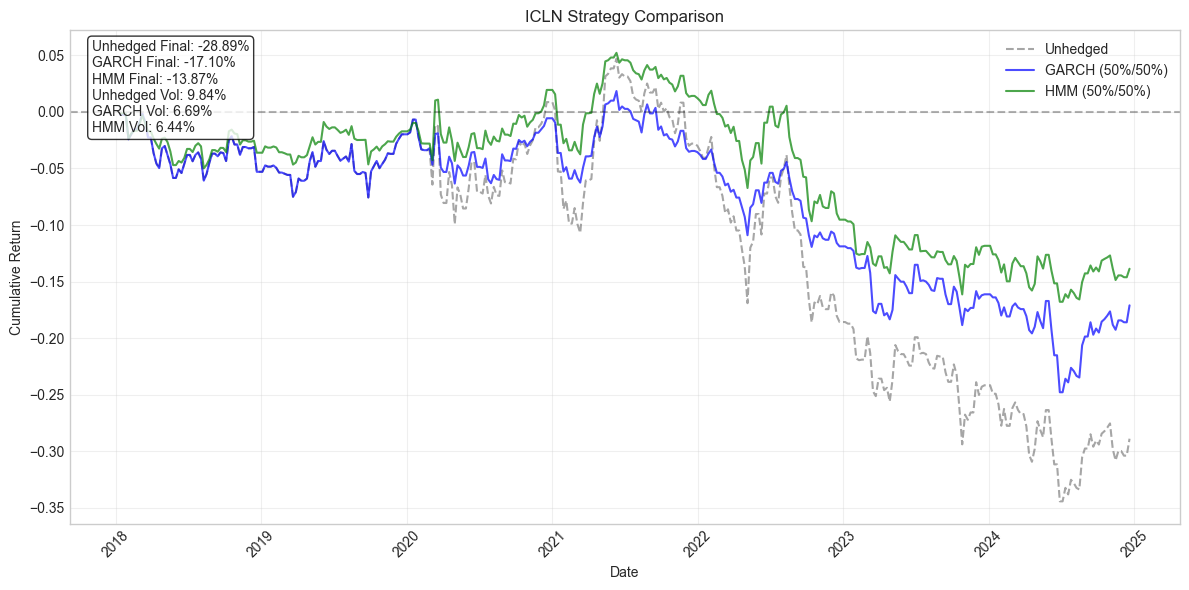

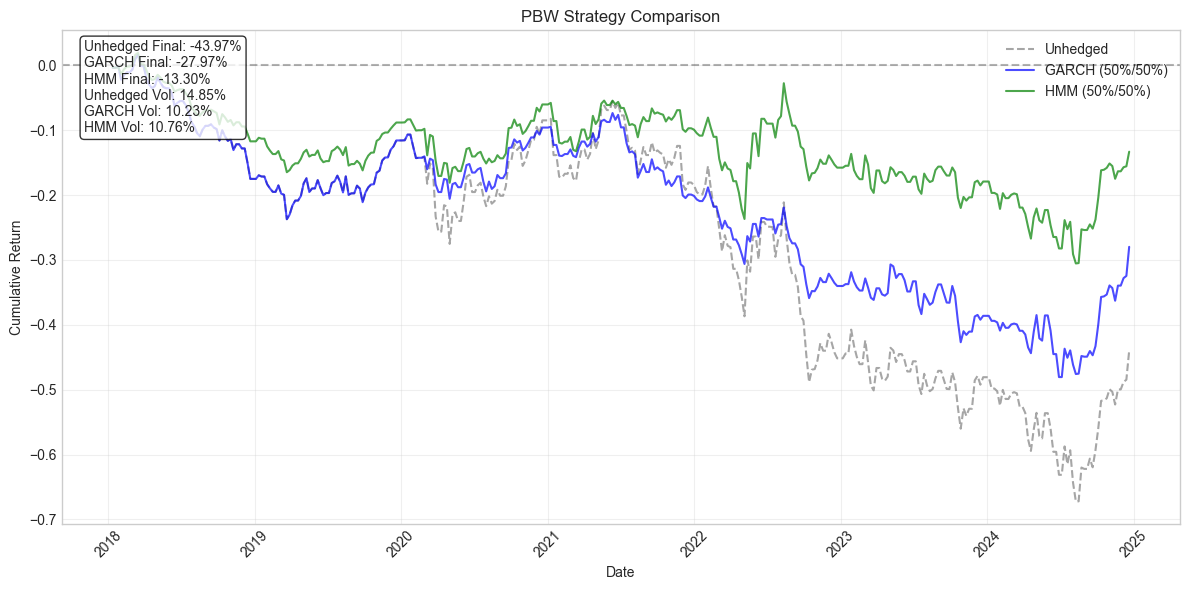

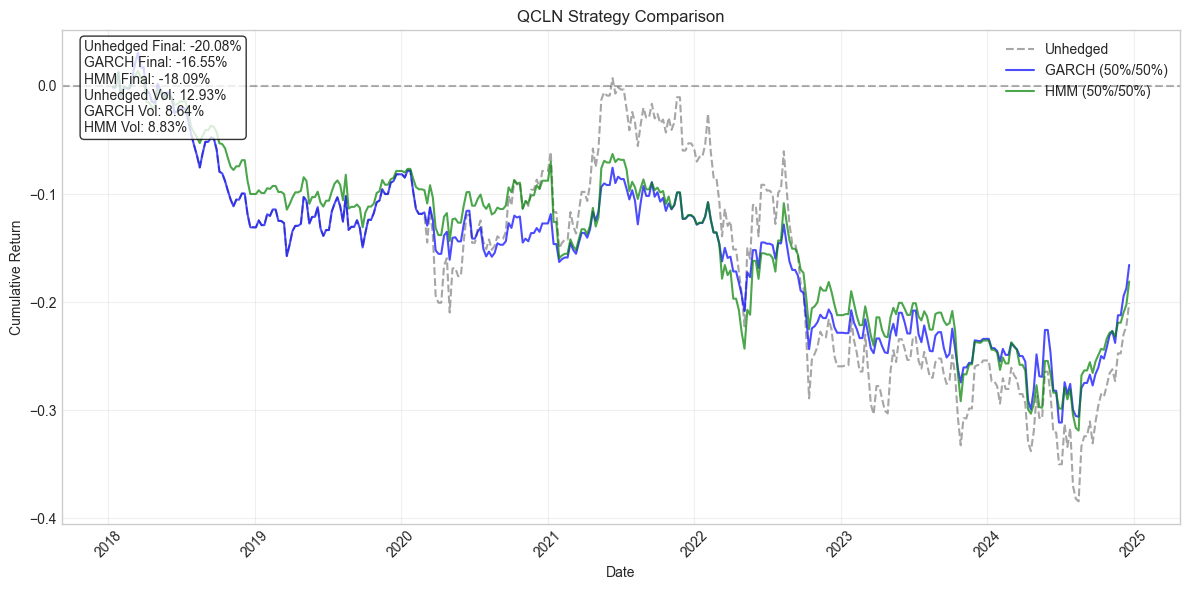

In [556]:
etf = "ICLN"
# Example usage:
plot_weekly_pnl_comparison(
    returns=renewable_df[etf],
    bond_returns=bond_returns["SHY"],
    garch_forecast=garch_forecast[etf],
    hmm_states=states_hmm[etf],
    start_date='2018-01-01',
    end_date='2024-12-31',
    garch_vol_thr=0.5,
    garch_de_risk=0.5,
    hmm_de_risk_med=0.5,
    hmm_de_risk_high=0.5,
    id2label=id2label[etf],
    title="ICLN Strategy Comparison"
)

etf = "PBW"
# Example usage:
plot_weekly_pnl_comparison(
    returns=renewable_df[etf],
    bond_returns=bond_returns["SHY"],
    garch_forecast=garch_forecast[etf],
    hmm_states=states_hmm[etf],
    start_date='2018-01-01',
    end_date='2024-12-31',
    garch_vol_thr=0.5,
    garch_de_risk=0.5,
    hmm_de_risk_med=0.5,
    hmm_de_risk_high=0.5,
    id2label=id2label[etf],
    title="PBW Strategy Comparison"
)
etf = "QCLN"
# Example usage:
plot_weekly_pnl_comparison(
    returns=renewable_df[etf],
    bond_returns=bond_returns["SHY"],
    garch_forecast=garch_forecast[etf],
    hmm_states=states_hmm[etf],
    start_date='2018-01-01',
    end_date='2024-12-31',
    garch_vol_thr=0.5,
    garch_de_risk=0.5,
    hmm_de_risk_med=0.5,
    hmm_de_risk_high=0.5,
    id2label=id2label[etf],
    title="QCLN Strategy Comparison")